In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks
# from google.colab import drive

# ✅ 参数设置
# drive.mount('/content/drive')



In [17]:
# start_index = 11
# end_index = 30
# range_tag = f"{start_index}-{end_index}"
range_tag = "11-30"
LOGITS_PATH = f"../logits/deepseek-math-7b-zebralogic-{range_tag}.json"
ERROR_INDEX_PATH = f"../error_fix_index/deepseek-math-7b-zebralogic-{range_tag}-index.json"
SAVE_PATH = f"../output/sequential_dynamics/deepseek-math-7b-zebralogic-{range_tag}/"


# start_index = 700
# end_index = 731
# range_tag = f"{start_index}-{end_index}"
# LOGITS_PATH = f"../logits/deepseek7b-gsm-{range_tag}.json"
# ERROR_INDEX_PATH = f"../error_fix_index/deepseek-7b-{range_tag}-index.json"
# SAVE_PATH = f"../output/sequential_dynamics/deepseek7b-gsm-{range_tag}/"


# start_index = 901
# end_index = 950
# range_tag = f"{start_index}-{end_index}"
# LOGITS_PATH = f"../logits/deepseek-math-7b-gsm-{range_tag}.json"
# ERROR_INDEX_PATH = f"../error_fix_index/deepseek-math-7b-gsm-{range_tag}-index.json"
# SAVE_PATH = f"../output/sequential_dynamics/deepseek-math-7b-gsm-{range_tag}/"

# start_index = 0
# end_index = 10
# range_tag = f"{start_index}-{end_index}"
# level = "level_5"
# discipline = "algebra"
# LOGITS_PATH = f"../logits/deepseek-math-7b-math-{range_tag}-{discipline}-{level}.json"
# ERROR_INDEX_PATH = f"../error_fix_index/deepseek-math-7b-math-{range_tag}-{discipline}-{level}-index.json"
# SAVE_PATH = f"../output/sequential_dynamics/deepseek-math-7b-math-{range_tag}-{discipline}-{level}/"


os.makedirs(SAVE_PATH, exist_ok=True)

In [18]:
import warnings
warnings.filterwarnings('ignore')


In [19]:

# ✅ 加载数据
with open(LOGITS_PATH, "r") as f:
    logits_data = json.load(f)



In [20]:
with open(ERROR_INDEX_PATH, "r") as f:
    index_data = json.load(f)

In [ ]:
# -*- coding: utf-8 -*-
"""
Error vs Fix Region Step Analysis (Corrected Version)
- Error region 只存在于负样本 (negative sampling)
- Fix region 只存在于对应的正样本 (positive sampling)
- 通过 correct_sampling_id 找到对应关系
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks
from google.colab import drive

# # ✅ 参数设置
# drive.mount('/content/drive')

# start_index = 700
# end_index = 731
# range_tag = f"{start_index}-{end_index}"
# BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
# LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
# ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
# SAVE_PATH = f"{BASE_PATH}/output/step_cross2"
# os.makedirs(SAVE_PATH, exist_ok=True)

# # ✅ 加载数据
# with open(LOGITS_PATH, "r") as f:
#     logits_data = json.load(f)

# with open(ERROR_INDEX_PATH, "r") as f:
#     index_data = json.load(f)

def compute_token_similarities(token_level):
    """计算token之间的cosine similarity"""
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    """基于similarity valleys找到step boundaries"""
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

def map_token_range_to_steps(similarities, start_idx, end_idx, steps):
    """
    将token范围映射到对应的step集合

    Args:
        similarities: token间的相似度序列
        start_idx: 范围起始token index
        end_idx: 范围结束token index
        steps: step边界列表

    Returns:
        set: 包含该范围的step索引集合
    """
    if start_idx is None or end_idx is None or start_idx == -1 or end_idx == -1:
        return set()

    affected_steps = set()
    for i in range(len(steps) - 1):
        step_start, step_end = steps[i], steps[i+1]
        # 检查token范围与step是否有重叠
        if not (end_idx < step_start or start_idx >= step_end):
            affected_steps.add(i)
    return affected_steps

# ✅ 输出 JSON 路径
json_save_path = os.path.join(SAVE_PATH, f"stepwise_error_fix_{range_tag}.json")

# ✅ 创建总字典 - 分别处理error和fix region
qid_to_step_data = {}

# 首先建立负样本到正样本的映射关系
neg_to_pos_mapping = {}
for qid, sid_dict in index_data.items():
    for neg_sid, region_info in sid_dict.items():
        correct_sid = region_info.get("correct_sampling_id")
        if correct_sid:
            neg_to_pos_mapping[(qid, neg_sid)] = (qid, correct_sid)

print(f"✅ 找到 {len(neg_to_pos_mapping)} 个负样本->正样本映射")

# 处理所有样本
for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid not in sample or "token_probs" not in sample[sid]:
            continue

        token_level = sample[sid]["token_probs"]
        similarities = compute_token_similarities(token_level)
        steps = find_steps(similarities)

        for i in range(len(steps) - 1):
            s_idx, e_idx = steps[i], steps[i+1]

            # 提取基础特征
            vecs = [
                token_level[j]["hidden_vector"]
                for j in range(s_idx, e_idx)
                if "hidden_vector" in token_level[j]
            ]
            ents = [
                token_level[j]["topk_info"]["entropy"]
                for j in range(s_idx, e_idx)
                if "topk_info" in token_level[j] and "entropy" in token_level[j]["topk_info"]
            ]
            probs = [
                token_level[j]["chosen_prob"]
                for j in range(s_idx, e_idx)
                if "chosen_prob" in token_level[j]
            ]

            if not vecs:
                continue

            step_key = f"step_{i}"
            step_info = {
                "start": s_idx,
                "end": e_idx,
                "vec_mean": np.mean(vecs, axis=0).tolist(),
                "entropy_mean": float(np.mean(ents)) if ents else 0.0,
                "prob_mean": float(np.mean(probs)) if probs else 0.0,
                "is_error_step": False,
                "is_fix_step": False,
                "step_type": "normal"
            }

            # 检查是否是负样本的error region
            if qid in index_data and sid in index_data[qid]:
                region_info = index_data[qid][sid]
                error_start = region_info.get("error_token_begin_index")
                error_end = region_info.get("error_token_end_index")

                if error_start is not None and error_end is not None:
                    try:
                        error_steps = map_token_range_to_steps(similarities, error_start, error_end, steps)
                        if i in error_steps:
                            step_info["is_error_step"] = True
                            step_info["step_type"] = "error"
                    except Exception as e:
                        print(f"❌ Error region mapping failed: qid={qid}, sid={sid} -> {e}")
                        continue

            # 检查是否是正样本的fix region
            # 通过reverse mapping找到这个正样本对应的负样本
            for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
                if pos_qid == qid and pos_sid == sid:
                    # 这是一个正样本，检查fix region
                    neg_region_info = index_data[neg_qid][neg_sid]
                    fix_start = neg_region_info.get("fix_token_begin_index")
                    fix_end = neg_region_info.get("fix_token_end_index")

                    if fix_start is not None and fix_end is not None:
                        try:
                            fix_steps = map_token_range_to_steps(similarities, fix_start, fix_end, steps)
                            if i in fix_steps:
                                step_info["is_fix_step"] = True
                                step_info["step_type"] = "fix"
                                # 记录对应的负样本信息
                                step_info["corresponding_negative"] = f"{neg_qid}_{neg_sid}"
                        except Exception as e:
                            print(f"❌ Fix region mapping failed: qid={qid}, sid={sid} -> {e}")
                            continue
                    break

            # 保存到主结构
            if qid not in qid_to_step_data:
                qid_to_step_data[qid] = {}
            if sid not in qid_to_step_data[qid]:
                qid_to_step_data[qid][sid] = {}
            qid_to_step_data[qid][sid][step_key] = step_info

# ✅ 保存为 JSON 文件
with open(json_save_path, "w") as f:
    json.dump(qid_to_step_data, f, indent=2)

print(f"✅ Error/Fix step-wise 信息已保存到: {json_save_path}")

# ✅ 构建配对列表 (使用映射关系)
paired_comparisons = []
for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
    if (neg_qid in qid_to_step_data and neg_sid in qid_to_step_data[neg_qid] and
        pos_qid in qid_to_step_data and pos_sid in qid_to_step_data[pos_qid]):
        paired_comparisons.append((neg_qid, neg_sid, pos_qid, pos_sid))

print(f"✅ 共找到 {len(paired_comparisons)} 个有效的error-fix配对")

# ✅ Error vs Fix Region 可视化对比
def visualize_error_fix_comparison():
    """可视化Error vs Fix region的对比"""

    vis_dir = os.path.join(SAVE_PATH, "error_fix_comparison")
    os.makedirs(vis_dir, exist_ok=True)

    for neg_qid, neg_sid, pos_qid, pos_sid in paired_comparisons:
        neg_steps = qid_to_step_data[neg_qid][neg_sid]
        pos_steps = qid_to_step_data[pos_qid][pos_sid]

        # 对齐步骤索引
        neg_indices = {int(k.replace("step_", "")): k for k in neg_steps}
        pos_indices = {int(k.replace("step_", "")): k for k in pos_steps}
        common_indices = sorted(set(neg_indices.keys()) & set(pos_indices.keys()))

        if len(common_indices) < 2:
            continue

        # 收集向量和步骤信息
        vecs_neg, vecs_pos = [], []
        neg_step_types, pos_step_types = [], []
        labels = []

        for idx in common_indices:
            neg_key = neg_indices[idx]
            pos_key = pos_indices[idx]

            try:
                vec_neg = np.array(neg_steps[neg_key]["vec_mean"])
                vec_pos = np.array(pos_steps[pos_key]["vec_mean"])

                vecs_neg.append(vec_neg)
                vecs_pos.append(vec_pos)
                neg_step_types.append(neg_steps[neg_key]["step_type"])
                pos_step_types.append(pos_steps[pos_key]["step_type"])
                labels.append(f"step_{idx}")
            except KeyError:
                continue

        if len(vecs_neg) < 2:
            continue

        # PCA降维
        X = np.concatenate([vecs_neg, vecs_pos], axis=0)
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(X)
        explained = pca.explained_variance_ratio_

        # 可视化
        plt.figure(figsize=(14, 8))

        # 绘制散点
        for i, label in enumerate(labels):
            idx_neg = i
            idx_pos = i + len(vecs_neg)

            # 负样本 - 根据是否是error region着色
            if neg_step_types[i] == "error":
                neg_color, neg_marker = "red", "s"
                neg_label_suffix = "_ERROR"
            else:
                neg_color, neg_marker = "gray", "o"
                neg_label_suffix = "_normal"

            plt.scatter(reduced[idx_neg, 0], reduced[idx_neg, 1],
                       color=neg_color, marker=neg_marker, alpha=0.7, s=100)
            plt.text(reduced[idx_neg, 0] - 0.5, reduced[idx_neg, 1],
                    f"{label}{neg_label_suffix}", fontsize=8, color=neg_color,
                    ha='right')

            # 正样本 - 根据是否是fix region着色
            if pos_step_types[i] == "fix":
                pos_color, pos_marker = "orange", "s"
                pos_label_suffix = "_FIX"
            else:
                pos_color, pos_marker = "blue", "o"
                pos_label_suffix = "_normal"

            plt.scatter(reduced[idx_pos, 0], reduced[idx_pos, 1],
                       color=pos_color, marker=pos_marker, alpha=0.7, s=100)
            plt.text(reduced[idx_pos, 0] + 0.5, reduced[idx_pos, 1],
                    f"{label}{pos_label_suffix}", fontsize=8, color=pos_color,
                    ha='left')

            # 连线
            plt.plot([reduced[idx_neg, 0], reduced[idx_pos, 0]],
                    [reduced[idx_neg, 1], reduced[idx_pos, 1]],
                    linestyle="--", color="gray", linewidth=0.8, alpha=0.4)

        # 图例
        legend_elements = [
            plt.scatter([], [], color='red', marker='s', s=100, label='Error Region (Negative)'),
            plt.scatter([], [], color='gray', marker='o', s=100, label='Normal (Negative)'),
            plt.scatter([], [], color='orange', marker='s', s=100, label='Fix Region (Positive)'),
            plt.scatter([], [], color='blue', marker='o', s=100, label='Normal (Positive)')
        ]

        title = (
            f"Error vs Fix Region Step Comparison (PCA)\n"
            f"Negative: {neg_qid}_{neg_sid} | Positive: {pos_qid}_{pos_sid}\n"
            f"Explained Variance: PC1={explained[0]:.2f}, PC2={explained[1]:.2f}"
        )
        plt.title(title, fontsize=12)
        plt.xlabel(f"PC1 ({explained[0]:.1%})")
        plt.ylabel(f"PC2 ({explained[1]:.1%})")
        plt.legend(handles=legend_elements, loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # 保存
        filename = f"error_fix_pca_{neg_qid}_{neg_sid}_vs_{pos_qid}_{pos_sid}.png"
        save_path = os.path.join(vis_dir, filename)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✅ Error/Fix PCA图保存: {save_path}")

# ✅ 熵值对比可视化
def visualize_entropy_comparison():
    """可视化Error vs Fix region的熵值对比"""

    ent_dir = os.path.join(SAVE_PATH, "entropy_error_fix")
    os.makedirs(ent_dir, exist_ok=True)

    for neg_qid, neg_sid, pos_qid, pos_sid in paired_comparisons:
        neg_steps = qid_to_step_data[neg_qid][neg_sid]
        pos_steps = qid_to_step_data[pos_qid][pos_sid]

        # 对齐步骤
        neg_indices = {int(k.replace("step_", "")): k for k in neg_steps}
        pos_indices = {int(k.replace("step_", "")): k for k in pos_steps}
        common_indices = sorted(set(neg_indices.keys()) & set(pos_indices.keys()))

        if len(common_indices) < 2:
            continue

        # 提取数据
        ent_neg, ent_pos = [], []
        neg_step_types, pos_step_types = [], []

        for idx in common_indices:
            neg_key = neg_indices[idx]
            pos_key = pos_indices[idx]
            try:
                ent_neg.append(neg_steps[neg_key]["entropy_mean"])
                ent_pos.append(pos_steps[pos_key]["entropy_mean"])
                neg_step_types.append(neg_steps[neg_key]["step_type"])
                pos_step_types.append(pos_steps[pos_key]["step_type"])
            except:
                continue

        labels = [f"step_{idx}" for idx in common_indices]
        if not ent_neg or not ent_pos:
            continue

        # 绘图
        x = np.arange(len(labels))
        plt.figure(figsize=(14, 7))

        # 基础线条
        plt.plot(x, ent_neg, color='gray', linewidth=2, alpha=0.6,
                label="Negative (baseline)", marker='o', markersize=4)
        plt.plot(x, ent_pos, color='blue', linewidth=2, alpha=0.8,
                label="Positive (baseline)", marker='o', markersize=4)

        # 高亮特殊区域
        for i, (neg_type, pos_type) in enumerate(zip(neg_step_types, pos_step_types)):
            # Error region (负样本)
            if neg_type == "error":
                plt.scatter(x[i], ent_neg[i], color='red', s=150,
                           edgecolor='darkred', linewidth=2, zorder=5,
                           marker='s', label='Error Region' if i == 0 or 'Error Region' not in plt.gca().get_legend_handles_labels()[1] else "")

            # Fix region (正样本)
            if pos_type == "fix":
                plt.scatter(x[i], ent_pos[i], color='orange', s=150,
                           edgecolor='darkorange', linewidth=2, zorder=5,
                           marker='s', label='Fix Region' if i == 0 or 'Fix Region' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.xticks(x, labels, rotation=45)
        plt.xlabel("Step Index")
        plt.ylabel("Mean Entropy")
        plt.title(f"Error vs Fix Region Entropy Comparison\n"
                 f"Negative: {neg_qid}_{neg_sid} | Positive: {pos_qid}_{pos_sid}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        save_path = os.path.join(ent_dir, f"entropy_error_fix_{neg_qid}_{neg_sid}_vs_{pos_qid}_{pos_sid}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"📊 Error/Fix 熵值图保存: {save_path}")

# ✅ 统计分析
def analyze_error_fix_statistics():
    """统计分析Error vs Fix region的特征"""

    stats = {
        "negative_samples": {"total_steps": 0, "error_steps": 0, "normal_steps": 0},
        "positive_samples": {"total_steps": 0, "fix_steps": 0, "normal_steps": 0},
        "entropy_stats": {"error": [], "fix": [], "neg_normal": [], "pos_normal": []},
        "prob_stats": {"error": [], "fix": [], "neg_normal": [], "pos_normal": []}
    }

    # 分析负样本
    for qid, sid_dict in index_data.items():
        for neg_sid in sid_dict.keys():
            if qid in qid_to_step_data and neg_sid in qid_to_step_data[qid]:
                steps = qid_to_step_data[qid][neg_sid]
                for step_key, step_info in steps.items():
                    stats["negative_samples"]["total_steps"] += 1

                    if step_info["step_type"] == "error":
                        stats["negative_samples"]["error_steps"] += 1
                        stats["entropy_stats"]["error"].append(step_info["entropy_mean"])
                        stats["prob_stats"]["error"].append(step_info["prob_mean"])
                    else:
                        stats["negative_samples"]["normal_steps"] += 1
                        stats["entropy_stats"]["neg_normal"].append(step_info["entropy_mean"])
                        stats["prob_stats"]["neg_normal"].append(step_info["prob_mean"])

    # 分析正样本
    for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
        if pos_qid in qid_to_step_data and pos_sid in qid_to_step_data[pos_qid]:
            steps = qid_to_step_data[pos_qid][pos_sid]
            for step_key, step_info in steps.items():
                stats["positive_samples"]["total_steps"] += 1

                if step_info["step_type"] == "fix":
                    stats["positive_samples"]["fix_steps"] += 1
                    stats["entropy_stats"]["fix"].append(step_info["entropy_mean"])
                    stats["prob_stats"]["fix"].append(step_info["prob_mean"])
                else:
                    stats["positive_samples"]["normal_steps"] += 1
                    stats["entropy_stats"]["pos_normal"].append(step_info["entropy_mean"])
                    stats["prob_stats"]["pos_normal"].append(step_info["prob_mean"])

    # 打印统计结果
    print("\n" + "="*60)
    print("ERROR vs FIX REGION 统计分析")
    print("="*60)

    print("\n📊 负样本统计:")
    neg_total = stats["negative_samples"]["total_steps"]
    neg_error = stats["negative_samples"]["error_steps"]
    neg_normal = stats["negative_samples"]["normal_steps"]
    print(f"  总步骤: {neg_total}")
    print(f"  Error区域: {neg_error} ({neg_error/neg_total*100:.1f}%)")
    print(f"  Normal区域: {neg_normal} ({neg_normal/neg_total*100:.1f}%)")

    print("\n📊 正样本统计:")
    pos_total = stats["positive_samples"]["total_steps"]
    pos_fix = stats["positive_samples"]["fix_steps"]
    pos_normal = stats["positive_samples"]["normal_steps"]
    print(f"  总步骤: {pos_total}")
    print(f"  Fix区域: {pos_fix} ({pos_fix/pos_total*100:.1f}%)")
    print(f"  Normal区域: {pos_normal} ({pos_normal/pos_total*100:.1f}%)")

    print("\n📈 熵值对比:")
    for region_type, values in stats["entropy_stats"].items():
        if values:
            print(f"  {region_type}: mean={np.mean(values):.3f} ± {np.std(values):.3f}")

    print("\n📈 概率对比:")
    for region_type, values in stats["prob_stats"].items():
        if values:
            print(f"  {region_type}: mean={np.mean(values):.3f} ± {np.std(values):.3f}")

    return stats

# ✅ 执行分析
print("🎯 开始 Error vs Fix Region 分析...")

# 统计分析
stats = analyze_error_fix_statistics()

# 可视化
print("\n📊 生成 PCA 对比图...")
visualize_error_fix_comparison()

print("\n📈 生成熵值对比图...")
visualize_entropy_comparison()

print("\n✅ Error vs Fix Region 分析完成！")

✅ 找到 27 个负样本->正样本映射
✅ Error/Fix step-wise 信息已保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross_2/stepwise_error_fix_700-731.json
✅ 共找到 27 个有效的error-fix配对
🎯 开始 Error vs Fix Region 分析...

ERROR vs FIX REGION 统计分析

📊 负样本统计:
  总步骤: 204
  Error区域: 39 (19.1%)
  Normal区域: 165 (80.9%)

📊 正样本统计:
  总步骤: 192
  Fix区域: 38 (19.8%)
  Normal区域: 154 (80.2%)

📈 熵值对比:
  error: mean=0.307 ± 0.209
  fix: mean=0.191 ± 0.105
  neg_normal: mean=0.215 ± 0.209
  pos_normal: mean=0.211 ± 0.191

📈 概率对比:
  error: mean=0.856 ± 0.108
  fix: mean=0.919 ± 0.048
  neg_normal: mean=0.897 ± 0.114
  pos_normal: mean=0.903 ± 0.097

📊 生成 PCA 对比图...
✅ Error/Fix PCA图保存: /content/drive/MyDrive/Cluster-proj/output/step_cross_2/error_fix_comparison/error_fix_pca_q_700_sampling0_vs_q_700_sampling1.png
✅ Error/Fix PCA图保存: /content/drive/MyDrive/Cluster-proj/output/step_cross_2/error_fix_comparison/error_fix_pca_q_700_sampling2_vs_q_700_sampling1.png
✅ Error/Fix PCA图保存: /content/drive/MyDrive/Cluster-proj/output/step_cross

In [ ]:
# -*- coding: utf-8 -*-
"""
Error vs Fix Region Distribution Metrics Analysis
统计正负样本fix region和error region的分布特征
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import pdist
from google.colab import drive

# ✅ 参数设置
# drive.mount('/content/drive')

start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
SAVE_PATH = f"{BASE_PATH}/output/step_cross2"
os.makedirs(SAVE_PATH, exist_ok=True)

# # ✅ 加载数据
# with open(LOGITS_PATH, "r") as f:
#     logits_data = json.load(f)

# with open(ERROR_INDEX_PATH, "r") as f:
#     index_data = json.load(f)

def compute_token_similarities(token_level):
    """计算token之间的cosine similarity"""
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    """基于similarity valleys找到step boundaries"""
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

def map_token_range_to_steps(similarities, start_idx, end_idx, steps):
    """将token范围映射到对应的step集合"""
    if start_idx is None or end_idx is None or start_idx == -1 or end_idx == -1:
        return set()

    affected_steps = set()
    for i in range(len(steps) - 1):
        step_start, step_end = steps[i], steps[i+1]
        if not (end_idx < step_start or start_idx >= step_end):
            affected_steps.add(i)
    return affected_steps

def compute_distribution_metrics(vectors, entropies, probs=None):
    """
    计算分布特征metrics

    Args:
        vectors: list of hidden vectors for tokens in this step
        entropies: list of entropy values
        probs: list of probability values (optional)

    Returns:
        dict: distribution metrics
    """
    if not vectors or len(vectors) == 0:
        return None

    vectors = np.array(vectors)
    entropies = np.array(entropies)
    if probs:
        probs = np.array(probs)

    metrics = {}

    # === 隐向量分布特征 ===

    # 1. Step内方差 (按维度)
    metrics['vector_variance_per_dim'] = np.var(vectors, axis=0).tolist()
    metrics['vector_variance_mean'] = float(np.mean(np.var(vectors, axis=0)))
    metrics['vector_variance_std'] = float(np.std(np.var(vectors, axis=0)))

    # 2. 向量间距离统计
    if len(vectors) > 1:
        # 成对距离
        pairwise_dists = pdist(vectors, metric='euclidean')
        metrics['pairwise_distance_mean'] = float(np.mean(pairwise_dists))
        metrics['pairwise_distance_std'] = float(np.std(pairwise_dists))
        metrics['pairwise_distance_min'] = float(np.min(pairwise_dists))
        metrics['pairwise_distance_max'] = float(np.max(pairwise_dists))

        # 向量spread (最大距离)
        metrics['vector_spread'] = float(np.max(pairwise_dists))

        # 余弦相似度统计
        cosine_dists = pdist(vectors, metric='cosine')
        metrics['cosine_distance_mean'] = float(np.mean(cosine_dists))
        metrics['cosine_distance_std'] = float(np.std(cosine_dists))
    else:
        metrics['pairwise_distance_mean'] = 0.0
        metrics['pairwise_distance_std'] = 0.0
        metrics['pairwise_distance_min'] = 0.0
        metrics['pairwise_distance_max'] = 0.0
        metrics['vector_spread'] = 0.0
        metrics['cosine_distance_mean'] = 0.0
        metrics['cosine_distance_std'] = 0.0

    # 3. 质心偏差
    centroid = np.mean(vectors, axis=0)
    centroid_deviations = [np.linalg.norm(vec - centroid) for vec in vectors]
    metrics['centroid_deviation_mean'] = float(np.mean(centroid_deviations))
    metrics['centroid_deviation_std'] = float(np.std(centroid_deviations))
    metrics['centroid_deviation_max'] = float(np.max(centroid_deviations))

    # 4. 有效维度数 (PCA解释方差)
    if len(vectors) > 1 and vectors.shape[1] > 1:
        try:
            # 使用较小的成分数避免维度问题
            n_components = min(len(vectors)-1, vectors.shape[1], 50)
            pca = PCA(n_components=n_components)
            pca.fit(vectors)

            # 累积解释方差
            cumsum_var = np.cumsum(pca.explained_variance_ratio_)
            metrics['effective_dim_80'] = int(np.argmax(cumsum_var >= 0.8) + 1)
            metrics['effective_dim_90'] = int(np.argmax(cumsum_var >= 0.9) + 1)
            metrics['effective_dim_95'] = int(np.argmax(cumsum_var >= 0.95) + 1)
            metrics['total_explained_variance'] = float(np.sum(pca.explained_variance_ratio_))

            # 主成分贡献度分布
            metrics['pc1_contribution'] = float(pca.explained_variance_ratio_[0])
            if len(pca.explained_variance_ratio_) > 1:
                metrics['pc2_contribution'] = float(pca.explained_variance_ratio_[1])
            else:
                metrics['pc2_contribution'] = 0.0

        except Exception as e:
            print(f"PCA计算失败: {e}")
            metrics['effective_dim_80'] = 1
            metrics['effective_dim_90'] = 1
            metrics['effective_dim_95'] = 1
            metrics['total_explained_variance'] = 1.0
            metrics['pc1_contribution'] = 1.0
            metrics['pc2_contribution'] = 0.0
    else:
        metrics['effective_dim_80'] = 1
        metrics['effective_dim_90'] = 1
        metrics['effective_dim_95'] = 1
        metrics['total_explained_variance'] = 1.0
        metrics['pc1_contribution'] = 1.0
        metrics['pc2_contribution'] = 0.0

    # === 熵分布特征 ===

    # 5. 熵值统计
    metrics['entropy_mean'] = float(np.mean(entropies))
    metrics['entropy_std'] = float(np.std(entropies))
    metrics['entropy_min'] = float(np.min(entropies))
    metrics['entropy_max'] = float(np.max(entropies))
    metrics['entropy_range'] = float(np.max(entropies) - np.min(entropies))

    # 熵分布形状
    if len(entropies) > 1:
        metrics['entropy_skewness'] = float(skew(entropies))
        metrics['entropy_kurtosis'] = float(kurtosis(entropies))
    else:
        metrics['entropy_skewness'] = 0.0
        metrics['entropy_kurtosis'] = 0.0

    # 熵分位数
    metrics['entropy_q25'] = float(np.percentile(entropies, 25))
    metrics['entropy_q50'] = float(np.percentile(entropies, 50))
    metrics['entropy_q75'] = float(np.percentile(entropies, 75))

    # === 概率分布特征 (如果有) ===
    if probs is not None and len(probs) > 0:
        metrics['prob_mean'] = float(np.mean(probs))
        metrics['prob_std'] = float(np.std(probs))
        metrics['prob_min'] = float(np.min(probs))
        metrics['prob_max'] = float(np.max(probs))
        metrics['prob_range'] = float(np.max(probs) - np.min(probs))

        if len(probs) > 1:
            metrics['prob_skewness'] = float(skew(probs))
            metrics['prob_kurtosis'] = float(kurtosis(probs))
        else:
            metrics['prob_skewness'] = 0.0
            metrics['prob_kurtosis'] = 0.0

        metrics['prob_q25'] = float(np.percentile(probs, 25))
        metrics['prob_q50'] = float(np.percentile(probs, 50))
        metrics['prob_q75'] = float(np.percentile(probs, 75))

    # === 综合复杂度指标 ===

    # 6. 信息密度 (熵 × 向量方差)
    metrics['information_density'] = float(metrics['entropy_mean'] * metrics['vector_variance_mean'])

    # 7. 表征复杂度 (维度 × 方差 × 熵)
    metrics['representation_complexity'] = float(
        metrics['effective_dim_80'] * metrics['vector_variance_mean'] * metrics['entropy_mean']
    )

    # 8. step内token数量
    metrics['token_count'] = len(vectors)

    return metrics

# ✅ 建立负样本到正样本的映射关系
neg_to_pos_mapping = {}
for qid, sid_dict in index_data.items():
    for neg_sid, region_info in sid_dict.items():
        correct_sid = region_info.get("correct_sampling_id")
        if correct_sid:
            neg_to_pos_mapping[(qid, neg_sid)] = (qid, correct_sid)

print(f"✅ 找到 {len(neg_to_pos_mapping)} 个负样本->正样本映射")

# ✅ 提取error和fix region的分布特征
distribution_results = {
    "error_regions": [],     # 负样本的error regions
    "fix_regions": [],       # 正样本的fix regions
    "negative_normal": [],   # 负样本的normal regions
    "positive_normal": [],   # 正样本的normal regions
    "metadata": {
        "total_error_steps": 0,
        "total_fix_steps": 0,
        "total_neg_normal_steps": 0,
        "total_pos_normal_steps": 0,
        "range_tag": range_tag
    }
}

for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
    # 检查数据完整性
    if (neg_qid not in logits_data or neg_sid not in logits_data[neg_qid] or
        pos_qid not in logits_data or pos_sid not in logits_data[pos_qid]):
        continue

    # === 处理负样本 (error region) ===
    neg_sample = logits_data[neg_qid][neg_sid]
    if "token_probs" not in neg_sample:
        continue

    neg_tokens = neg_sample["token_probs"]
    neg_similarities = compute_token_similarities(neg_tokens)
    neg_steps = find_steps(neg_similarities)

    # 获取error region范围
    region_info = index_data[neg_qid][neg_sid]
    error_start = region_info.get("error_token_begin_index")
    error_end = region_info.get("error_token_end_index")

    if error_start is not None and error_end is not None and error_start != -1 and error_end != -1:
        error_steps = map_token_range_to_steps(neg_similarities, error_start, error_end, neg_steps)

        # 分析每个step
        for i in range(len(neg_steps) - 1):
            step_start, step_end = neg_steps[i], neg_steps[i+1]

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []

            for j in range(step_start, step_end):
                if j < len(neg_tokens):
                    token = neg_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])

            if step_vectors and step_entropies:
                metrics = compute_distribution_metrics(step_vectors, step_entropies, step_probs)
                if metrics:
                    step_info = {
                        "qid": neg_qid,
                        "sid": neg_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_error_step": i in error_steps,
                        "metrics": metrics
                    }

                    if i in error_steps:
                        distribution_results["error_regions"].append(step_info)
                        distribution_results["metadata"]["total_error_steps"] += 1
                    else:
                        distribution_results["negative_normal"].append(step_info)
                        distribution_results["metadata"]["total_neg_normal_steps"] += 1

    # === 处理正样本 (fix region) ===
    pos_sample = logits_data[pos_qid][pos_sid]
    if "token_probs" not in pos_sample:
        continue

    pos_tokens = pos_sample["token_probs"]
    pos_similarities = compute_token_similarities(pos_tokens)
    pos_steps = find_steps(pos_similarities)

    # 获取fix region范围
    fix_start = region_info.get("fix_token_begin_index")
    fix_end = region_info.get("fix_token_end_index")

    if fix_start is not None and fix_end is not None and fix_start != -1 and fix_end != -1:
        fix_steps = map_token_range_to_steps(pos_similarities, fix_start, fix_end, pos_steps)

        # 分析每个step
        for i in range(len(pos_steps) - 1):
            step_start, step_end = pos_steps[i], pos_steps[i+1]

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []

            for j in range(step_start, step_end):
                if j < len(pos_tokens):
                    token = pos_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])

            if step_vectors and step_entropies:
                metrics = compute_distribution_metrics(step_vectors, step_entropies, step_probs)
                if metrics:
                    step_info = {
                        "qid": pos_qid,
                        "sid": pos_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_fix_step": i in fix_steps,
                        "corresponding_negative": f"{neg_qid}_{neg_sid}",
                        "metrics": metrics
                    }

                    if i in fix_steps:
                        distribution_results["fix_regions"].append(step_info)
                        distribution_results["metadata"]["total_fix_steps"] += 1
                    else:
                        distribution_results["positive_normal"].append(step_info)
                        distribution_results["metadata"]["total_pos_normal_steps"] += 1

# ✅ 保存结果到JSON
json_save_path = os.path.join(SAVE_PATH, f"distribution_metrics_{range_tag}.json")
with open(json_save_path, "w") as f:
    json.dump(distribution_results, f, indent=2)

print(f"✅ 分布特征metrics已保存到: {json_save_path}")

# ✅ 打印统计摘要
print("\n" + "="*60)
print("分布特征统计摘要")
print("="*60)

metadata = distribution_results["metadata"]
print(f"Error region步骤数: {metadata['total_error_steps']}")
print(f"Fix region步骤数: {metadata['total_fix_steps']}")
print(f"负样本正常步骤数: {metadata['total_neg_normal_steps']}")
print(f"正样本正常步骤数: {metadata['total_pos_normal_steps']}")

# ✅ 计算各区域的统计摘要
def compute_summary_stats(region_data, region_name):
    """计算某个区域的统计摘要"""
    if not region_data:
        return

    print(f"\n📊 {region_name} 统计摘要:")

    # 关键metrics统计
    key_metrics = [
        'vector_variance_mean', 'vector_spread', 'centroid_deviation_mean',
        'entropy_mean', 'entropy_std', 'entropy_range',
        'effective_dim_80', 'information_density', 'token_count'
    ]

    for metric in key_metrics:
        values = []
        for step in region_data:
            if metric in step["metrics"]:
                values.append(step["metrics"][metric])

        if values:
            print(f"  {metric}: {np.mean(values):.3f} ± {np.std(values):.3f} "
                  f"(min: {np.min(values):.3f}, max: {np.max(values):.3f})")

# 打印各区域统计
compute_summary_stats(distribution_results["error_regions"], "Error Regions")
compute_summary_stats(distribution_results["fix_regions"], "Fix Regions")
compute_summary_stats(distribution_results["negative_normal"], "Negative Normal")
compute_summary_stats(distribution_results["positive_normal"], "Positive Normal")

# ✅ 生成对比分析报告
comparison_report = {
    "error_vs_fix": {},
    "error_vs_neg_normal": {},
    "fix_vs_pos_normal": {}
}

def compare_regions(region1, region2, comparison_name):
    """对比两个区域的分布特征"""
    if not region1 or not region2:
        return {}

    key_metrics = [
        'vector_variance_mean', 'vector_spread', 'centroid_deviation_mean',
        'entropy_mean', 'entropy_std', 'entropy_range', 'effective_dim_80',
        'information_density', 'token_count'
    ]

    comparison = {}
    for metric in key_metrics:
        values1 = [step["metrics"][metric] for step in region1 if metric in step["metrics"]]
        values2 = [step["metrics"][metric] for step in region2 if metric in step["metrics"]]

        if values1 and values2:
            mean1, mean2 = np.mean(values1), np.mean(values2)
            comparison[metric] = {
                "region1_mean": float(mean1),
                "region2_mean": float(mean2),
                "difference": float(mean2 - mean1),
                "ratio": float(mean2 / mean1) if mean1 != 0 else None,
                "effect_size": float((mean2 - mean1) / np.sqrt((np.var(values1) + np.var(values2)) / 2))
            }

    return comparison

# 进行对比分析
comparison_report["error_vs_fix"] = compare_regions(
    distribution_results["error_regions"],
    distribution_results["fix_regions"],
    "Error vs Fix"
)

comparison_report["error_vs_neg_normal"] = compare_regions(
    distribution_results["error_regions"],
    distribution_results["negative_normal"],
    "Error vs Negative Normal"
)

comparison_report["fix_vs_pos_normal"] = compare_regions(
    distribution_results["fix_regions"],
    distribution_results["positive_normal"],
    "Fix vs Positive Normal"
)

# 保存对比报告
comparison_save_path = os.path.join(SAVE_PATH, f"distribution_comparison_{range_tag}.json")
with open(comparison_save_path, "w") as f:
    json.dump(comparison_report, f, indent=2)

print(f"\n✅ 对比分析报告已保存到: {comparison_save_path}")

# 打印关键对比结果
print("\n" + "="*60)
print("关键对比结果")
print("="*60)

def print_key_comparisons(comparison_data, title):
    print(f"\n🔍 {title}:")
    key_metrics = ['vector_variance_mean', 'entropy_mean', 'information_density', 'effective_dim_80']

    for metric in key_metrics:
        if metric in comparison_data:
            comp = comparison_data[metric]
            print(f"  {metric}: {comp['region1_mean']:.3f} → {comp['region2_mean']:.3f} "
                  f"(差异: {comp['difference']:.3f}, 倍数: {comp['ratio']:.2f})")

print_key_comparisons(comparison_report["error_vs_fix"], "Error vs Fix Regions")
print_key_comparisons(comparison_report["error_vs_neg_normal"], "Error vs Negative Normal")
print_key_comparisons(comparison_report["fix_vs_pos_normal"], "Fix vs Positive Normal")

print("\n✅ 分布特征分析完成！")

✅ 找到 27 个负样本->正样本映射
✅ 分布特征metrics已保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/distribution_metrics_700-731.json

分布特征统计摘要
Error region步骤数: 39
Fix region步骤数: 38
负样本正常步骤数: 157
正样本正常步骤数: 147

📊 Error Regions 统计摘要:
  vector_variance_mean: 0.053 ± 0.009 (min: 0.039, max: 0.068)
  vector_spread: 27.908 ± 2.365 (min: 22.997, max: 32.458)
  centroid_deviation_mean: 14.487 ± 1.232 (min: 12.385, max: 16.656)
  entropy_mean: 0.307 ± 0.209 (min: 0.000, max: 0.801)
  entropy_std: 0.401 ± 0.155 (min: 0.000, max: 0.618)
  entropy_range: 1.247 ± 0.389 (min: 0.000, max: 1.583)
  effective_dim_80: 12.051 ± 4.019 (min: 3.000, max: 22.000)
  information_density: 0.016 ± 0.010 (min: 0.000, max: 0.037)
  token_count: 25.897 ± 10.947 (min: 5.000, max: 55.000)

📊 Fix Regions 统计摘要:
  vector_variance_mean: 0.054 ± 0.007 (min: 0.043, max: 0.071)
  vector_spread: 27.912 ± 1.976 (min: 24.897, max: 33.185)
  centroid_deviation_mean: 14.675 ± 0.932 (min: 13.149, max: 16.856)
  entropy_mean: 0.182 ± 0.

In [ ]:
qid_to_step_data.keys()

dict_keys(['q_700', 'q_701', 'q_702', 'q_703', 'q_704', 'q_705', 'q_706', 'q_707', 'q_708', 'q_709', 'q_710', 'q_711', 'q_712', 'q_713', 'q_714', 'q_715', 'q_716', 'q_717', 'q_718', 'q_719', 'q_720', 'q_721', 'q_722', 'q_723', 'q_724', 'q_725', 'q_726', 'q_727', 'q_728', 'q_729', 'q_730'])

In [22]:
# -*- coding: utf-8 -*-
"""
Sequential Dynamics Analysis - Error vs Fix Regions
分析正负样本的序列动态性特征
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.signal import find_peaks
from scipy.stats import pearsonr, spearmanr
# from google.colab import drive

# ✅ 参数设置
# drive.mount('/content/drive')

# start_index = 700
# end_index = 731
# range_tag = f"{start_index}-{end_index}"
# BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
# LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
# ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
# SAVE_PATH = f"{BASE_PATH}/output/step_cross2"
# os.makedirs(SAVE_PATH, exist_ok=True)

# # ✅ 加载数据
# with open(LOGITS_PATH, "r") as f:
#     logits_data = json.load(f)

# with open(ERROR_INDEX_PATH, "r") as f:
#     index_data = json.load(f)

def compute_token_similarities(token_level):
    """计算token之间的cosine similarity"""
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    """基于similarity valleys找到step boundaries"""
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

def map_token_range_to_steps(similarities, start_idx, end_idx, steps):
    """将token范围映射到对应的step集合"""
    if start_idx is None or end_idx is None or start_idx == -1 or end_idx == -1:
        return set()

    affected_steps = set()
    for i in range(len(steps) - 1):
        step_start, step_end = steps[i], steps[i+1]
        if not (end_idx < step_start or start_idx >= step_end):
            affected_steps.add(i)
    return affected_steps

def compute_sequential_dynamics(vectors, entropies, probs=None):
    """
    计算序列动态性metrics

    Args:
        vectors: list of hidden vectors for tokens in this step
        entropies: list of entropy values
        probs: list of probability values (optional)

    Returns:
        dict: sequential dynamics metrics
    """
    if not vectors or len(vectors) < 2:
        return None

    vectors = np.array(vectors)
    entropies = np.array(entropies)
    if probs:
        probs = np.array(probs)

    metrics = {}

    # === 1. Token间变化特征 ===

    # 相邻token向量变化
    vector_diffs = np.diff(vectors, axis=0)  # (n-1, dim)
    vector_changes = np.linalg.norm(vector_diffs, axis=1)  # (n-1,)

    metrics['vector_change_mean'] = float(np.mean(vector_changes))
    metrics['vector_change_std'] = float(np.std(vector_changes))
    metrics['vector_change_max'] = float(np.max(vector_changes))
    metrics['vector_change_min'] = float(np.min(vector_changes))

    # 轨迹平滑度 (变化的变化)
    if len(vector_changes) > 1:
        change_acceleration = np.abs(np.diff(vector_changes))
        metrics['trajectory_smoothness'] = float(1 / (1 + np.mean(change_acceleration)))
        metrics['acceleration_mean'] = float(np.mean(change_acceleration))
        metrics['acceleration_std'] = float(np.std(change_acceleration))
    else:
        metrics['trajectory_smoothness'] = 1.0
        metrics['acceleration_mean'] = 0.0
        metrics['acceleration_std'] = 0.0

    # 语义漂移 (累积变化)
    cumulative_drift = np.cumsum(vector_changes)
    metrics['semantic_drift_total'] = float(cumulative_drift[-1])
    metrics['semantic_drift_mean'] = float(np.mean(cumulative_drift))
    metrics['semantic_drift_progression'] = float(cumulative_drift[-1] / len(vectors))

    # 进展一致性 (变化方向一致性)
    if len(vector_diffs) > 1:
        # 计算相邻变化向量的余弦相似度
        consistency_scores = []
        for i in range(len(vector_diffs) - 1):
            v1, v2 = vector_diffs[i], vector_diffs[i+1]
            # 避免零向量
            if np.linalg.norm(v1) > 1e-8 and np.linalg.norm(v2) > 1e-8:
                cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
                consistency_scores.append(cos_sim)

        if consistency_scores:
            metrics['progression_consistency'] = float(np.mean(consistency_scores))
            metrics['consistency_std'] = float(np.std(consistency_scores))
        else:
            metrics['progression_consistency'] = 0.0
            metrics['consistency_std'] = 0.0
    else:
        metrics['progression_consistency'] = 0.0
        metrics['consistency_std'] = 0.0

    # 局部波动性 (滑动窗口变化)
    window_size = min(3, len(vector_changes))
    if window_size > 1:
        local_volatilities = []
        for i in range(len(vector_changes) - window_size + 1):
            window = vector_changes[i:i+window_size]
            volatility = np.std(window)
            local_volatilities.append(volatility)
        metrics['local_volatility_mean'] = float(np.mean(local_volatilities))
        metrics['local_volatility_max'] = float(np.max(local_volatilities))
    else:
        metrics['local_volatility_mean'] = 0.0
        metrics['local_volatility_max'] = 0.0

    # === 2. 熵变化模式 ===

    # 熵值变化
    entropy_changes = np.abs(np.diff(entropies))
    metrics['entropy_change_mean'] = float(np.mean(entropy_changes))
    metrics['entropy_change_std'] = float(np.std(entropy_changes))
    metrics['entropy_change_max'] = float(np.max(entropy_changes))
    metrics['entropy_change_min'] = float(np.min(entropy_changes))
    # 熵值趋势 (线性回归斜率)
    if len(entropies) > 1:
        x = np.arange(len(entropies))
        slope, intercept = np.polyfit(x, entropies, 1)
        metrics['entropy_trend_slope'] = float(slope)
        metrics['entropy_trend_intercept'] = float(intercept)

        # 趋势拟合度 (R²)
        y_pred = slope * x + intercept
        ss_res = np.sum((entropies - y_pred) ** 2)
        ss_tot = np.sum((entropies - np.mean(entropies)) ** 2)
        metrics['entropy_trend_r_squared'] = float(1 - (ss_res / (ss_tot + 1e-8)))
    else:
        metrics['entropy_trend_slope'] = 0.0
        metrics['entropy_trend_intercept'] = float(entropies[0])
        metrics['entropy_trend_r_squared'] = 0.0

    # 熵值加速度 (变化的变化)
    if len(entropy_changes) > 1:
        entropy_acceleration = np.abs(np.diff(entropy_changes))
        metrics['entropy_acceleration_mean'] = float(np.mean(entropy_acceleration))
        metrics['entropy_acceleration_std'] = float(np.std(entropy_acceleration))
    else:
        metrics['entropy_acceleration_mean'] = 0.0
        metrics['entropy_acceleration_std'] = 0.0

    # 不确定性震荡 (熵值波动频率)
    if len(entropies) > 2:
        # 寻找熵值的局部极值
        peaks_high, _ = find_peaks(entropies, distance=1)
        peaks_low, _ = find_peaks(-entropies, distance=1)
        total_oscillations = len(peaks_high) + len(peaks_low)
        metrics['uncertainty_oscillation_freq'] = float(total_oscillations / len(entropies))

        # 震荡强度 (峰谷差异)
        if total_oscillations > 0:
            peak_values = entropies[peaks_high] if len(peaks_high) > 0 else []
            valley_values = entropies[peaks_low] if len(peaks_low) > 0 else []

            if len(peak_values) > 0 and len(valley_values) > 0:
                metrics['oscillation_amplitude'] = float(np.mean(peak_values) - np.mean(valley_values))
            else:
                metrics['oscillation_amplitude'] = 0.0
        else:
            metrics['oscillation_amplitude'] = 0.0
    else:
        metrics['uncertainty_oscillation_freq'] = 0.0
        metrics['oscillation_amplitude'] = 0.0

    # === 3. 概率动态性 (如果有概率数据) ===
    if probs is not None and len(probs) > 1:
        # 概率变化
        prob_changes = np.abs(np.diff(probs))
        metrics['prob_change_mean'] = float(np.mean(prob_changes))
        metrics['prob_change_std'] = float(np.std(prob_changes))
        metrics['prob_change_max'] = float(np.max(prob_changes))

        # 概率趋势
        x = np.arange(len(probs))
        slope, intercept = np.polyfit(x, probs, 1)
        metrics['prob_trend_slope'] = float(slope)
        metrics['prob_trend_intercept'] = float(intercept)

        # 概率-熵相关性
        if len(probs) == len(entropies):
            corr_pearson, p_pearson = pearsonr(probs, entropies)
            corr_spearman, p_spearman = spearmanr(probs, entropies)
            metrics['prob_entropy_correlation_pearson'] = float(corr_pearson)
            metrics['prob_entropy_correlation_spearman'] = float(corr_spearman)
            metrics['prob_entropy_p_value_pearson'] = float(p_pearson)
            metrics['prob_entropy_p_value_spearman'] = float(p_spearman)

    # === 4. 综合动态性指标 ===

    # 整体动态复杂度 (变化强度 × 不一致性)
    change_intensity = metrics['vector_change_mean'] + metrics['entropy_change_mean']
    inconsistency = 1 - metrics['progression_consistency']
    metrics['dynamic_complexity'] = float(change_intensity * inconsistency)

    # 稳定性评分 (1 - 标准化波动)
    normalized_volatility = metrics['local_volatility_mean'] / (metrics['vector_change_mean'] + 1e-8)
    metrics['stability_score'] = float(1 / (1 + normalized_volatility))

    # 序列长度
    metrics['sequence_length'] = len(vectors)

    return metrics

# ✅ 建立负样本到正样本的映射关系
neg_to_pos_mapping = {}
for qid, sid_dict in index_data.items():
    for neg_sid, region_info in sid_dict.items():
        correct_sid = region_info.get("correct_sampling_id")
        if correct_sid:
            neg_to_pos_mapping[(qid, neg_sid)] = (qid, correct_sid)

print(f"✅ 找到 {len(neg_to_pos_mapping)} 个负样本->正样本映射")

# ✅ 提取error和fix region的序列动态性特征
sequential_results = {
    "error_regions": [],     # 负样本的error regions
    "fix_regions": [],       # 正样本的fix regions
    "negative_normal": [],   # 负样本的normal regions
    "positive_normal": [],   # 正样本的normal regions
    "metadata": {
        "total_error_steps": 0,
        "total_fix_steps": 0,
        "total_neg_normal_steps": 0,
        "total_pos_normal_steps": 0,
        "range_tag": range_tag
    }
}

for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
    # 检查数据完整性
    if (neg_qid not in logits_data or neg_sid not in logits_data[neg_qid] or
        pos_qid not in logits_data or pos_sid not in logits_data[pos_qid]):
        continue

    # === 处理负样本 (error region) ===
    neg_sample = logits_data[neg_qid][neg_sid]
    if "token_probs" not in neg_sample:
        continue

    neg_tokens = neg_sample["token_probs"]
    neg_similarities = compute_token_similarities(neg_tokens)
    neg_steps = find_steps(neg_similarities)

    # 获取error region范围
    region_info = index_data[neg_qid][neg_sid]
    error_start = region_info.get("error_token_begin_index")
    error_end = region_info.get("error_token_end_index")

    if error_start is not None and error_end is not None and error_start != -1 and error_end != -1:
        error_steps = map_token_range_to_steps(neg_similarities, error_start, error_end, neg_steps)

        # 分析每个step
        for i in range(len(neg_steps) - 1):
            step_start, step_end = neg_steps[i], neg_steps[i+1]

            # 确保step至少有2个token才能计算动态性
            if step_end - step_start < 2:
                continue

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []

            for j in range(step_start, step_end):
                if j < len(neg_tokens):
                    token = neg_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])

            if len(step_vectors) >= 2 and len(step_entropies) >= 2:
                metrics = compute_sequential_dynamics(step_vectors, step_entropies, step_probs)
                if metrics:
                    step_info = {
                        "qid": neg_qid,
                        "sid": neg_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_error_step": i in error_steps,
                        "metrics": metrics
                    }

                    if i in error_steps:
                        sequential_results["error_regions"].append(step_info)
                        sequential_results["metadata"]["total_error_steps"] += 1
                    else:
                        sequential_results["negative_normal"].append(step_info)
                        sequential_results["metadata"]["total_neg_normal_steps"] += 1

    # === 处理正样本 (fix region) ===
    pos_sample = logits_data[pos_qid][pos_sid]
    if "token_probs" not in pos_sample:
        continue

    pos_tokens = pos_sample["token_probs"]
    pos_similarities = compute_token_similarities(pos_tokens)
    pos_steps = find_steps(pos_similarities)

    # 获取fix region范围
    fix_start = region_info.get("fix_token_begin_index")
    fix_end = region_info.get("fix_token_end_index")

    if fix_start is not None and fix_end is not None and fix_start != -1 and fix_end != -1:
        fix_steps = map_token_range_to_steps(pos_similarities, fix_start, fix_end, pos_steps)

        # 分析每个step
        for i in range(len(pos_steps) - 1):
            step_start, step_end = pos_steps[i], pos_steps[i+1]

            # 确保step至少有2个token才能计算动态性
            if step_end - step_start < 2:
                continue

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []

            for j in range(step_start, step_end):
                if j < len(pos_tokens):
                    token = pos_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])

            if len(step_vectors) >= 2 and len(step_entropies) >= 2:
                metrics = compute_sequential_dynamics(step_vectors, step_entropies, step_probs)
                if metrics:
                    step_info = {
                        "qid": pos_qid,
                        "sid": pos_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_fix_step": i in fix_steps,
                        "corresponding_negative": f"{neg_qid}_{neg_sid}",
                        "metrics": metrics
                    }

                    if i in fix_steps:
                        sequential_results["fix_regions"].append(step_info)
                        sequential_results["metadata"]["total_fix_steps"] += 1
                    else:
                        sequential_results["positive_normal"].append(step_info)
                        sequential_results["metadata"]["total_pos_normal_steps"] += 1

# ✅ 保存结果到JSON
json_save_path = os.path.join(SAVE_PATH, f"sequential_dynamics_{range_tag}.json")
with open(json_save_path, "w") as f:
    json.dump(sequential_results, f, indent=2)

print(f"✅ 序列动态性metrics已保存到: {json_save_path}")

# ✅ 打印统计摘要
print("\n" + "="*60)
print("序列动态性统计摘要")
print("="*60)

metadata = sequential_results["metadata"]
print(f"Error region步骤数: {metadata['total_error_steps']}")
print(f"Fix region步骤数: {metadata['total_fix_steps']}")
print(f"负样本正常步骤数: {metadata['total_neg_normal_steps']}")
print(f"正样本正常步骤数: {metadata['total_pos_normal_steps']}")

# ✅ 计算各区域的统计摘要
def compute_sequential_summary(region_data, region_name):
    """计算序列动态性的统计摘要"""
    if not region_data:
        return

    print(f"\n📊 {region_name} 序列动态性统计:")

    # 关键动态性metrics
    key_metrics = [
        'vector_change_mean', 'trajectory_smoothness', 'semantic_drift_total',
        'progression_consistency', 'local_volatility_mean', 'entropy_change_mean',
        'entropy_change_min',
        'entropy_trend_slope', 'uncertainty_oscillation_freq', 'dynamic_complexity',
        'stability_score', 'sequence_length'
    ]

    for metric in key_metrics:
        values = []
        for step in region_data:
            if metric in step["metrics"]:
                values.append(step["metrics"][metric])

        if values:
            print(f"  {metric}: {np.mean(values):.3f} ± {np.std(values):.3f} "
                  f"(min: {np.min(values):.3f}, max: {np.max(values):.3f})")

# 打印各区域统计
compute_sequential_summary(sequential_results["error_regions"], "Error Regions")
compute_sequential_summary(sequential_results["fix_regions"], "Fix Regions")
compute_sequential_summary(sequential_results["negative_normal"], "Negative Normal")
compute_sequential_summary(sequential_results["positive_normal"], "Positive Normal")

# ✅ 生成对比分析报告
def compare_sequential_regions(region1, region2, comparison_name):
    """对比两个区域的序列动态性特征"""
    if not region1 or not region2:
        return {}

    key_metrics = [
        'vector_change_mean', 'trajectory_smoothness', 'semantic_drift_total',
        'progression_consistency', 'local_volatility_mean', 'entropy_change_mean','entropy_change_min',
        'entropy_trend_slope', 'uncertainty_oscillation_freq', 'dynamic_complexity',
        'stability_score'
    ]

    comparison = {}
    for metric in key_metrics:
        values1 = [step["metrics"][metric] for step in region1 if metric in step["metrics"]]
        values2 = [step["metrics"][metric] for step in region2 if metric in step["metrics"]]

        if values1 and values2:
            mean1, mean2 = np.mean(values1), np.mean(values2)
            comparison[metric] = {
                "region1_mean": float(mean1),
                "region2_mean": float(mean2),
                "difference": float(mean2 - mean1),
                "ratio": float(mean2 / mean1) if mean1 != 0 else None,
                "effect_size": float((mean2 - mean1) / np.sqrt((np.var(values1) + np.var(values2)) / 2))
            }

    return comparison

# 进行对比分析
sequential_comparison = {
    "error_vs_fix": compare_sequential_regions(
        sequential_results["error_regions"],
        sequential_results["fix_regions"],
        "Error vs Fix"
    ),
    "error_vs_neg_normal": compare_sequential_regions(
        sequential_results["error_regions"],
        sequential_results["negative_normal"],
        "Error vs Negative Normal"
    ),
    "fix_vs_pos_normal": compare_sequential_regions(
        sequential_results["fix_regions"],
        sequential_results["positive_normal"],
        "Fix vs Positive Normal"
    )
}

# 保存对比报告
comparison_save_path = os.path.join(SAVE_PATH, f"sequential_comparison_{range_tag}.json")
with open(comparison_save_path, "w") as f:
    json.dump(sequential_comparison, f, indent=2)

print(f"\n✅ 序列动态性对比报告已保存到: {comparison_save_path}")

# ✅ 打印关键对比结果
print("\n" + "="*60)
print("序列动态性关键对比结果")
print("="*60)

def print_sequential_comparisons(comparison_data, title):
    print(f"\n🔍 {title}:")
    key_metrics = [
        'trajectory_smoothness', 'progression_consistency', 'entropy_change_mean', 'entropy_change_min',
        'dynamic_complexity', 'stability_score', 'entropy_trend_slope'
    ]
    # key_metrics = [
    #     'vector_change_mean', 'trajectory_smoothness', 'semantic_drift_total',
    #     'progression_consistency', 'local_volatility_mean', 'entropy_change_mean',
    #     'entropy_change_min',
    #     'entropy_trend_slope', 'uncertainty_oscillation_freq', 'dynamic_complexity',
    #     'stability_score'
    # ]


    for metric in key_metrics:
        if metric in comparison_data:
            comp = comparison_data[metric]
            print(f"  {metric}: {comp['region1_mean']:.3f} → {comp['region2_mean']:.3f} "
                  f"(差异: {comp['difference']:.3f}, 倍数: {comp['ratio']:.2f})")

print_sequential_comparisons(sequential_comparison["error_vs_fix"], "Error vs Fix Regions")
print_sequential_comparisons(sequential_comparison["error_vs_neg_normal"], "Error vs Negative Normal")
print_sequential_comparisons(sequential_comparison["fix_vs_pos_normal"], "Fix vs Positive Normal")

# ✅ 生成可视化
def visualize_sequential_dynamics():
    """可视化序列动态性对比"""

    vis_dir = os.path.join(SAVE_PATH, "sequential_dynamics_vis")
    os.makedirs(vis_dir, exist_ok=True)

    # 提取关键指标进行可视化
    regions = {
        "Error": sequential_results["error_regions"],
        "Fix": sequential_results["fix_regions"],
        "Neg Normal": sequential_results["negative_normal"],
        "Pos Normal": sequential_results["positive_normal"]
    }

    # key_metrics = [
    #     'trajectory_smoothness', 'progression_consistency', 'entropy_change_mean','entropy_change_min',
    #     'dynamic_complexity', 'stability_score', 'uncertainty_oscillation_freq'
    # ]
    key_metrics = [
        'vector_change_mean', 'trajectory_smoothness', 'semantic_drift_total',
        'progression_consistency', 'local_volatility_mean', 'entropy_change_mean',
        'entropy_change_min',
        'entropy_trend_slope', 'uncertainty_oscillation_freq', 'dynamic_complexity',
        'stability_score', 'sequence_length'
    ]

    # 创建对比图
    fig, axes = plt.subplots(4, 3, figsize=(36, 24))
    axes = axes.flatten()

    colors = ['red', 'orange', 'gray', 'blue']

    for i, metric in enumerate(key_metrics):
        ax = axes[i]

        data_to_plot = []
        labels = []

        for region_name, region_data in regions.items():
            values = [step["metrics"][metric] for step in region_data if metric in step["metrics"]]
            if values:
                data_to_plot.append(values)
                labels.append(region_name)

        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors[:len(data_to_plot)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

        ax.set_title(metric.replace('_', ' ').title())
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, "sequential_dynamics_comparison.png"), dpi=300, bbox_inches='tight')
    plt.close()

    print(f"📊 序列动态性可视化已保存到: {vis_dir}/sequential_dynamics_comparison.png")

# 生成可视化
visualize_sequential_dynamics()

print("\n✅ 序列动态性分析完成！")

✅ 找到 22 个负样本->正样本映射
✅ 序列动态性metrics已保存到: ../output/sequential_dynamics/deepseek-math-7b-zebralogic-11-30/sequential_dynamics_11-30.json

序列动态性统计摘要
Error region步骤数: 38
Fix region步骤数: 44
负样本正常步骤数: 222
正样本正常步骤数: 159

📊 Error Regions 序列动态性统计:
  vector_change_mean: 12.401 ± 1.044 (min: 10.823, max: 16.943)
  trajectory_smoothness: 0.346 ± 0.115 (min: 0.230, max: 1.000)
  semantic_drift_total: 348.786 ± 187.592 (min: 12.278, max: 856.346)
  progression_consistency: -0.384 ± 0.070 (min: -0.488, max: 0.000)
  local_volatility_mean: 1.389 ± 0.402 (min: 0.000, max: 2.702)
  entropy_change_mean: 0.321 ± 0.147 (min: 0.060, max: 0.674)
  entropy_change_min: 0.012 ± 0.074 (min: 0.000, max: 0.459)
  entropy_trend_slope: 0.014 ± 0.078 (min: -0.073, max: 0.459)
  uncertainty_oscillation_freq: 0.284 ± 0.146 (min: 0.000, max: 0.611)
  dynamic_complexity: 17.614 ± 1.859 (min: 12.737, max: 25.911)
  stability_score: 0.900 ± 0.023 (min: 0.856, max: 1.000)
  sequence_length: 29.789 ± 16.740 (min: 2.000, max: 

In [59]:
#3

# -*- coding: utf-8 -*-
"""
Geometric Features Analysis - Error vs Fix Regions
分析正负样本的几何拓扑特征
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.signal import find_peaks
from scipy.spatial import ConvexHull, distance_matrix
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
# from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# ✅ 参数设置
# drive.mount('/content/drive')

# start_index = 700
# end_index = 731
# range_tag = f"{start_index}-{end_index}"
# BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
# LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
# ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
# SAVE_PATH = f"{BASE_PATH}/output/step_cross2"
# os.makedirs(SAVE_PATH, exist_ok=True)

# ✅ 加载数据
# with open(LOGITS_PATH, "r") as f:
#     logits_data = json.load(f)

# with open(ERROR_INDEX_PATH, "r") as f:
#     index_data = json.load(f)

def compute_token_similarities(token_level):
    """计算token之间的cosine similarity"""
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    """基于similarity valleys找到step boundaries"""
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

def map_token_range_to_steps(similarities, start_idx, end_idx, steps):
    """将token范围映射到对应的step集合"""
    if start_idx is None or end_idx is None or start_idx == -1 or end_idx == -1:
        return set()

    affected_steps = set()
    for i in range(len(steps) - 1):
        step_start, step_end = steps[i], steps[i+1]
        if not (end_idx < step_start or start_idx >= step_end):
            affected_steps.add(i)
    return affected_steps

def compute_geometric_features(vectors, entropies, probs=None):
    """
    计算几何拓扑特征

    Args:
        vectors: list of hidden vectors for tokens in this step
        entropies: list of entropy values
        probs: list of probability values (optional)

    Returns:
        dict: geometric features
    """
    if not vectors or len(vectors) < 2:
        return None

    vectors = np.array(vectors)
    entropies = np.array(entropies)
    if probs:
        probs = np.array(probs)

    n_tokens = len(vectors)
    n_dims = vectors.shape[1]

    metrics = {}

    # === 1. 向量几何特征 ===

    # 1.1 凸包特征
    try:
        if n_tokens >= 3:
            # 降维到2D计算凸包（避免高维问题）
            pca_2d = PCA(n_components=2)
            vectors_2d = pca_2d.fit_transform(vectors)

            # 计算凸包
            hull = ConvexHull(vectors_2d)
            metrics['convex_hull_area'] = float(hull.volume)  # 2D中volume就是area
            metrics['convex_hull_vertices'] = int(len(hull.vertices))
            metrics['convex_hull_ratio'] = float(len(hull.vertices) / n_tokens)

            # 凸包周长
            hull_points = vectors_2d[hull.vertices]
            perimeter = 0
            for i in range(len(hull_points)):
                p1 = hull_points[i]
                p2 = hull_points[(i + 1) % len(hull_points)]
                perimeter += np.linalg.norm(p2 - p1)
            metrics['convex_hull_perimeter'] = float(perimeter)

            # 形状紧凑度 (area / perimeter²)
            metrics['shape_compactness'] = float(metrics['convex_hull_area'] / (perimeter ** 2 + 1e-8))
        else:
            metrics['convex_hull_area'] = 0.0
            metrics['convex_hull_vertices'] = n_tokens
            metrics['convex_hull_ratio'] = 1.0
            metrics['convex_hull_perimeter'] = 0.0
            metrics['shape_compactness'] = 0.0
    except Exception as e:
        print(f"凸包计算失败: {e}")
        metrics['convex_hull_area'] = 0.0
        metrics['convex_hull_vertices'] = n_tokens
        metrics['convex_hull_ratio'] = 1.0
        metrics['convex_hull_perimeter'] = 0.0
        metrics['shape_compactness'] = 0.0

    # 1.2 有效维度数
    try:
        # 使用PCA确定有效维度
        pca = PCA()
        pca.fit(vectors)
        explained_var = pca.explained_variance_ratio_

        # 累积解释方差
        cumsum_var = np.cumsum(explained_var)

        metrics['effective_dim_80'] = int(np.argmax(cumsum_var >= 0.8) + 1)
        metrics['effective_dim_90'] = int(np.argmax(cumsum_var >= 0.9) + 1)
        metrics['effective_dim_95'] = int(np.argmax(cumsum_var >= 0.95) + 1)
        metrics['effective_dim_99'] = int(np.argmax(cumsum_var >= 0.99) + 1)

        # 主成分贡献度
        metrics['pc1_contribution'] = float(explained_var[0])
        if len(explained_var) > 1:
            metrics['pc2_contribution'] = float(explained_var[1])
            metrics['pc3_contribution'] = float(explained_var[2]) if len(explained_var) > 2 else 0.0
        else:
            metrics['pc2_contribution'] = 0.0
            metrics['pc3_contribution'] = 0.0

        # 维度分散度 (香农熵)
        pc_entropy = entropy(explained_var + 1e-8, base=2)
        metrics['dimensionality_entropy'] = float(pc_entropy)

        # 维度集中度 (前3个主成分占比)
        top3_ratio = np.sum(explained_var[:3]) if len(explained_var) >= 3 else np.sum(explained_var)
        metrics['top3_dimensions_ratio'] = float(top3_ratio)

    except Exception as e:
        print(f"PCA计算失败: {e}")
        metrics['effective_dim_80'] = 1
        metrics['effective_dim_90'] = 1
        metrics['effective_dim_95'] = 1
        metrics['effective_dim_99'] = 1
        metrics['pc1_contribution'] = 1.0
        metrics['pc2_contribution'] = 0.0
        metrics['pc3_contribution'] = 0.0
        metrics['dimensionality_entropy'] = 0.0
        metrics['top3_dimensions_ratio'] = 1.0

    # === 2. 距离度量特征 ===

    # 2.1 成对距离统计
    pairwise_dists = pdist(vectors, metric='euclidean')

    metrics['pairwise_distance_mean'] = float(np.mean(pairwise_dists))
    metrics['pairwise_distance_std'] = float(np.std(pairwise_dists))
    metrics['pairwise_distance_min'] = float(np.min(pairwise_dists))
    metrics['pairwise_distance_max'] = float(np.max(pairwise_dists))
    metrics['pairwise_distance_range'] = float(np.max(pairwise_dists) - np.min(pairwise_dists))

    # 直径 (最大距离)
    metrics['diameter'] = float(np.max(pairwise_dists))

    # 2.2 最近邻距离
    if n_tokens > 1:
        nbrs = NearestNeighbors(n_neighbors=min(2, n_tokens), metric='euclidean').fit(vectors)
        distances, indices = nbrs.kneighbors(vectors)

        # 第一最近邻距离 (除了自己)
        nearest_dists = distances[:, 1] if distances.shape[1] > 1 else distances[:, 0]
        metrics['nearest_neighbor_mean'] = float(np.mean(nearest_dists))
        metrics['nearest_neighbor_std'] = float(np.std(nearest_dists))
        metrics['nearest_neighbor_min'] = float(np.min(nearest_dists))
        metrics['nearest_neighbor_max'] = float(np.max(nearest_dists))
    else:
        metrics['nearest_neighbor_mean'] = 0.0
        metrics['nearest_neighbor_std'] = 0.0
        metrics['nearest_neighbor_min'] = 0.0
        metrics['nearest_neighbor_max'] = 0.0

    # 2.3 中心性度量
    centroid = np.mean(vectors, axis=0)
    centroid_distances = [np.linalg.norm(vec - centroid) for vec in vectors]

    metrics['centroid_distance_mean'] = float(np.mean(centroid_distances))
    metrics['centroid_distance_std'] = float(np.std(centroid_distances))
    metrics['centroid_distance_max'] = float(np.max(centroid_distances))

    # 半径 (最大质心距离)
    metrics['radius'] = float(np.max(centroid_distances))

    # 紧凑度 (平均质心距离 / 直径)
    metrics['compactness'] = float(metrics['centroid_distance_mean'] / (metrics['diameter'] + 1e-8))

    # === 3. 聚类特征 ===

    # 3.1 K-means聚类特征
    if n_tokens >= 2:
        # 尝试不同的聚类数
        max_clusters = min(5, n_tokens)
        inertias = []
        silhouette_scores = []

        for k in range(1, max_clusters + 1):
            if k == 1:
                # 单个聚类的惯性
                inertia = np.sum([np.linalg.norm(vec - centroid) ** 2 for vec in vectors])
                inertias.append(inertia)
                silhouette_scores.append(0.0)
            else:
                try:
                    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                    labels = kmeans.fit_predict(vectors)
                    inertias.append(kmeans.inertia_)

                    # 计算轮廓系数
                    if len(set(labels)) > 1:
                        from sklearn.metrics import silhouette_score
                        sil_score = silhouette_score(vectors, labels)
                        silhouette_scores.append(sil_score)
                    else:
                        silhouette_scores.append(0.0)
                except:
                    inertias.append(inertias[-1] if inertias else 0.0)
                    silhouette_scores.append(0.0)

        # 肘部法则 (惯性变化率)
        if len(inertias) > 1:
            inertia_changes = np.diff(inertias)
            metrics['elbow_point'] = int(np.argmax(-inertia_changes) + 1)  # 变化最大的k
        else:
            metrics['elbow_point'] = 1

        # 最佳轮廓系数
        metrics['best_silhouette_score'] = float(np.max(silhouette_scores))
        metrics['optimal_clusters'] = int(np.argmax(silhouette_scores) + 1)

        # 聚类内聚度 (最小惯性)
        metrics['min_inertia'] = float(np.min(inertias))
        metrics['cluster_cohesion'] = float(1 / (1 + np.min(inertias)))
    else:
        metrics['elbow_point'] = 1
        metrics['best_silhouette_score'] = 0.0
        metrics['optimal_clusters'] = 1
        metrics['min_inertia'] = 0.0
        metrics['cluster_cohesion'] = 1.0

    # 3.2 DBSCAN聚类特征
    if n_tokens >= 2:
        try:
            # 使用平均最近邻距离作为eps
            eps = metrics['nearest_neighbor_mean'] * 1.5
            dbscan = DBSCAN(eps=eps, min_samples=max(2, n_tokens // 3))
            db_labels = dbscan.fit_predict(vectors)

            n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
            n_noise = list(db_labels).count(-1)

            metrics['dbscan_clusters'] = int(n_clusters)
            metrics['dbscan_noise_ratio'] = float(n_noise / n_tokens)

            # 核心点比例
            core_samples = len(dbscan.core_sample_indices_)
            metrics['dbscan_core_ratio'] = float(core_samples / n_tokens)

        except Exception as e:
            metrics['dbscan_clusters'] = 0
            metrics['dbscan_noise_ratio'] = 0.0
            metrics['dbscan_core_ratio'] = 0.0
    else:
        metrics['dbscan_clusters'] = 0
        metrics['dbscan_noise_ratio'] = 0.0
        metrics['dbscan_core_ratio'] = 0.0

    # === 4. 流形特征 ===

    # 4.1 流形曲率估计 (基于局部PCA)
    if n_tokens >= 3:
        try:
            # 对每个点计算局部曲率
            curvatures = []
            for i in range(n_tokens):
                # 找到最近的neighbors
                dists = [np.linalg.norm(vectors[i] - vectors[j]) for j in range(n_tokens)]
                nearest_indices = np.argsort(dists)[:min(3, n_tokens)]

                if len(nearest_indices) >= 2:
                    local_points = vectors[nearest_indices]

                    # 局部PCA
                    local_pca = PCA(n_components=min(2, len(local_points)))
                    local_pca.fit(local_points)

                    # 曲率 = 1 - 第一主成分解释方差
                    curvature = 1 - local_pca.explained_variance_ratio_[0]
                    curvatures.append(curvature)

            if curvatures:
                metrics['manifold_curvature_mean'] = float(np.mean(curvatures))
                metrics['manifold_curvature_std'] = float(np.std(curvatures))
                metrics['manifold_curvature_max'] = float(np.max(curvatures))
            else:
                metrics['manifold_curvature_mean'] = 0.0
                metrics['manifold_curvature_std'] = 0.0
                metrics['manifold_curvature_max'] = 0.0
        except Exception as e:
            metrics['manifold_curvature_mean'] = 0.0
            metrics['manifold_curvature_std'] = 0.0
            metrics['manifold_curvature_max'] = 0.0
    else:
        metrics['manifold_curvature_mean'] = 0.0
        metrics['manifold_curvature_std'] = 0.0
        metrics['manifold_curvature_max'] = 0.0

    # 4.2 内在维度估计 (基于距离分布)
    if n_tokens >= 3:
        try:
            # 使用最近邻距离比率估计内在维度
            nbrs = NearestNeighbors(n_neighbors=min(3, n_tokens), metric='euclidean').fit(vectors)
            distances, indices = nbrs.kneighbors(vectors)

            if distances.shape[1] >= 3:
                # 第一和第二最近邻距离比率
                ratios = distances[:, 1] / (distances[:, 2] + 1e-8)
                mean_ratio = np.mean(ratios)

                # 内在维度估计 (经验公式)
                intrinsic_dim = -np.log(mean_ratio) / np.log(2)
                metrics['intrinsic_dimension'] = float(max(1, intrinsic_dim))
            else:
                metrics['intrinsic_dimension'] = 1.0
        except Exception as e:
            metrics['intrinsic_dimension'] = 1.0
    else:
        metrics['intrinsic_dimension'] = 1.0

    # === 5. 形状特征 ===

    # 5.1 长宽比 (基于PCA主成分)
    if n_tokens >= 2:
        try:
            pca_shape = PCA(n_components=min(3, n_tokens, n_dims))
            pca_shape.fit(vectors)

            # 主成分方向的展开距离
            transformed = pca_shape.transform(vectors)
            ranges = np.ptp(transformed, axis=0)  # 每个主成分的范围

            if len(ranges) >= 2:
                metrics['aspect_ratio_1_2'] = float(ranges[0] / (ranges[1] + 1e-8))
                if len(ranges) >= 3:
                    metrics['aspect_ratio_1_3'] = float(ranges[0] / (ranges[2] + 1e-8))
                    metrics['aspect_ratio_2_3'] = float(ranges[1] / (ranges[2] + 1e-8))
                else:
                    metrics['aspect_ratio_1_3'] = metrics['aspect_ratio_1_2']
                    metrics['aspect_ratio_2_3'] = 1.0
            else:
                metrics['aspect_ratio_1_2'] = 1.0
                metrics['aspect_ratio_1_3'] = 1.0
                metrics['aspect_ratio_2_3'] = 1.0
        except Exception as e:
            metrics['aspect_ratio_1_2'] = 1.0
            metrics['aspect_ratio_1_3'] = 1.0
            metrics['aspect_ratio_2_3'] = 1.0
    else:
        metrics['aspect_ratio_1_2'] = 1.0
        metrics['aspect_ratio_1_3'] = 1.0
        metrics['aspect_ratio_2_3'] = 1.0

    # 5.2 球形度 (体积与表面积的关系)
    if n_tokens >= 3:
        try:
            # 使用凸包体积和表面积
            volume = metrics['convex_hull_area']  # 2D中是面积
            perimeter = metrics['convex_hull_perimeter']  # 2D中是周长

            # 球形度 = (周长² / 面积) / 4π (标准化)
            if volume > 0:
                sphericity = (perimeter ** 2) / (4 * np.pi * volume)
                metrics['sphericity'] = float(1 / sphericity)  # 越接近1越球形
            else:
                metrics['sphericity'] = 0.0
        except Exception as e:
            metrics['sphericity'] = 0.0
    else:
        metrics['sphericity'] = 0.0

    # === 6. 综合几何指标 ===

    # 6.1 几何复杂度 (多个特征的综合)
    complexity_score = (
        metrics['dimensionality_entropy'] +
        (1 - metrics['compactness']) +
        metrics['manifold_curvature_mean'] +
        (1 - metrics['cluster_cohesion'])
    )
    metrics['geometric_complexity'] = float(complexity_score)

    # 6.2 结构规整度
    regularity_score = (
        metrics['best_silhouette_score'] +
        metrics['cluster_cohesion'] +
        metrics['compactness'] +
        metrics['sphericity']
    ) / 4
    metrics['structural_regularity'] = float(regularity_score)

    # 6.3 空间利用效率
    if metrics['convex_hull_area'] > 0:
        space_efficiency = metrics['convex_hull_vertices'] / metrics['convex_hull_area']
        metrics['space_efficiency'] = float(space_efficiency)
    else:
        metrics['space_efficiency'] = 0.0

    # 基础信息
    metrics['n_tokens'] = n_tokens
    metrics['n_dimensions'] = n_dims

    return metrics

# ✅ 建立负样本到正样本的映射关系
neg_to_pos_mapping = {}
for qid, sid_dict in index_data.items():
    for neg_sid, region_info in sid_dict.items():
        correct_sid = region_info.get("correct_sampling_id")
        if correct_sid:
            neg_to_pos_mapping[(qid, neg_sid)] = (qid, correct_sid)

print(f"✅ 找到 {len(neg_to_pos_mapping)} 个负样本->正样本映射")

# ✅ 提取error和fix region的几何特征
geometric_results = {
    "error_regions": [],     # 负样本的error regions
    "fix_regions": [],       # 正样本的fix regions
    "negative_normal": [],   # 负样本的normal regions
    "positive_normal": [],   # 正样本的normal regions
    "metadata": {
        "total_error_steps": 0,
        "total_fix_steps": 0,
        "total_neg_normal_steps": 0,
        "total_pos_normal_steps": 0,
        "range_tag": range_tag
    }
}

for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
    # 检查数据完整性
    if (neg_qid not in logits_data or neg_sid not in logits_data[neg_qid] or
        pos_qid not in logits_data or pos_sid not in logits_data[pos_qid]):
        continue

    # === 处理负样本 (error region) ===
    neg_sample = logits_data[neg_qid][neg_sid]
    if "token_probs" not in neg_sample:
        continue

    neg_tokens = neg_sample["token_probs"]
    neg_similarities = compute_token_similarities(neg_tokens)
    neg_steps = find_steps(neg_similarities)

    # 获取error region范围
    region_info = index_data[neg_qid][neg_sid]
    error_start = region_info.get("error_token_begin_index")
    error_end = region_info.get("error_token_end_index")

    if error_start is not None and error_end is not None and error_start != -1 and error_end != -1:
        error_steps = map_token_range_to_steps(neg_similarities, error_start, error_end, neg_steps)

        # 分析每个step
        for i in range(len(neg_steps) - 1):
            step_start, step_end = neg_steps[i], neg_steps[i+1]

            # 确保step至少有2个token才能计算几何特征
            if step_end - step_start < 2:
                continue

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []

            for j in range(step_start, step_end):
                if j < len(neg_tokens):
                    token = neg_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])

            if len(step_vectors) >= 2 and len(step_entropies) >= 2:
                metrics = compute_geometric_features(step_vectors, step_entropies, step_probs)
                if metrics:
                    step_info = {
                        "qid": neg_qid,
                        "sid": neg_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_error_step": i in error_steps,
                        "metrics": metrics
                    }

                    if i in error_steps:
                        geometric_results["error_regions"].append(step_info)
                        geometric_results["metadata"]["total_error_steps"] += 1
                    else:
                        geometric_results["negative_normal"].append(step_info)
                        geometric_results["metadata"]["total_neg_normal_steps"] += 1

    # === 处理正样本 (fix region) ===
    pos_sample = logits_data[pos_qid][pos_sid]
    if "token_probs" not in pos_sample:
        continue

    pos_tokens = pos_sample["token_probs"]
    pos_similarities = compute_token_similarities(pos_tokens)
    pos_steps = find_steps(pos_similarities)

    # 获取fix region范围
    fix_start = region_info.get("fix_token_begin_index")
    fix_end = region_info.get("fix_token_end_index")

    if fix_start is not None and fix_end is not None and fix_start != -1 and fix_end != -1:
        fix_steps = map_token_range_to_steps(pos_similarities, fix_start, fix_end, pos_steps)

        # 分析每个step
        for i in range(len(pos_steps) - 1):
            step_start, step_end = pos_steps[i], pos_steps[i+1]

            # 确保step至少有2个token才能计算几何特征
            if step_end - step_start < 2:
                continue

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []

            for j in range(step_start, step_end):
                if j < len(pos_tokens):
                    token = pos_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])

            if len(step_vectors) >= 2 and len(step_entropies) >= 2:
                metrics = compute_geometric_features(step_vectors, step_entropies, step_probs)
                if metrics:
                    step_info = {
                        "qid": pos_qid,
                        "sid": pos_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_fix_step": i in fix_steps,
                        "corresponding_negative": f"{neg_qid}_{neg_sid}",
                        "metrics": metrics
                    }

                    if i in fix_steps:
                        geometric_results["fix_regions"].append(step_info)
                        geometric_results["metadata"]["total_fix_steps"] += 1
                    else:
                        geometric_results["positive_normal"].append(step_info)
                        geometric_results["metadata"]["total_pos_normal_steps"] += 1

# ✅ 保存结果到JSON
json_save_path = os.path.join(SAVE_PATH, f"geometric_features_{range_tag}.json")
with open(json_save_path, "w") as f:
    json.dump(geometric_results, f, indent=2)

print(f"✅ 几何特征metrics已保存到: {json_save_path}")

# ✅ 打印统计摘要
print("\n" + "="*60)
print("几何特征统计摘要")
print("="*60)

metadata = geometric_results["metadata"]
print(f"Error region步骤数: {metadata['total_error_steps']}")
print(f"Fix region步骤数: {metadata['total_fix_steps']}")
print(f"负样本正常步骤数: {metadata['total_neg_normal_steps']}")
print(f"正样本正常步骤数: {metadata['total_pos_normal_steps']}")

# ✅ 计算各区域的统计摘要
def compute_geometric_summary(region_data, region_name):
    """计算几何特征的统计摘要"""
    if not region_data:
        return

    print(f"\n📊 {region_name} 几何特征统计:")

    # 关键几何metrics
    key_metrics = [
        'convex_hull_area', 'effective_dim_80', 'pairwise_distance_mean',
        'diameter', 'compactness', 'best_silhouette_score', 'cluster_cohesion',
        'manifold_curvature_mean', 'intrinsic_dimension', 'geometric_complexity',
        'structural_regularity', 'sphericity', 'n_tokens'
    ]

    for metric in key_metrics:
        values = []
        for step in region_data:
            if metric in step["metrics"]:
                values.append(step["metrics"][metric])

        if values:
            print(f"  {metric}: {np.mean(values):.3f} ± {np.std(values):.3f} "
                  f"(min: {np.min(values):.3f}, max: {np.max(values):.3f})")

# 打印各区域统计
compute_geometric_summary(geometric_results["error_regions"], "Error Regions")
compute_geometric_summary(geometric_results["fix_regions"], "Fix Regions")
compute_geometric_summary(geometric_results["negative_normal"], "Negative Normal")
compute_geometric_summary(geometric_results["positive_normal"], "Positive Normal")

# ✅ 生成对比分析报告
def compare_geometric_regions(region1, region2, comparison_name):
    """对比两个区域的几何特征"""
    if not region1 or not region2:
        return {}

    key_metrics = [
        'convex_hull_area', 'effective_dim_80', 'pairwise_distance_mean',
        'diameter', 'compactness', 'best_silhouette_score', 'cluster_cohesion',
        'manifold_curvature_mean', 'intrinsic_dimension', 'geometric_complexity',
        'structural_regularity', 'sphericity'
    ]

    comparison = {}
    for metric in key_metrics:
        values1 = [step["metrics"][metric] for step in region1 if metric in step["metrics"]]
        values2 = [step["metrics"][metric] for step in region2 if metric in step["metrics"]]

        if values1 and values2:
            mean1, mean2 = np.mean(values1), np.mean(values2)
            comparison[metric] = {
                "region1_mean": float(mean1),
                "region2_mean": float(mean2),
                "difference": float(mean2 - mean1),
                "ratio": float(mean2 / mean1) if mean1 != 0 else None,
                "effect_size": float((mean2 - mean1) / np.sqrt((np.var(values1) + np.var(values2)) / 2))
            }

    return comparison

# 进行对比分析
geometric_comparison = {
    "error_vs_fix": compare_geometric_regions(
        geometric_results["error_regions"],
        geometric_results["fix_regions"],
        "Error vs Fix"
    ),
    "error_vs_neg_normal": compare_geometric_regions(
        geometric_results["error_regions"],
        geometric_results["negative_normal"],
        "Error vs Negative Normal"
    ),
    "fix_vs_pos_normal": compare_geometric_regions(
        geometric_results["fix_regions"],
        geometric_results["positive_normal"],
        "Fix vs Positive Normal"
    )
}

# 保存对比报告
comparison_save_path = os.path.join(SAVE_PATH, f"geometric_comparison_{range_tag}.json")
with open(comparison_save_path, "w") as f:
    json.dump(geometric_comparison, f, indent=2)

print(f"\n✅ 几何特征对比报告已保存到: {comparison_save_path}")

# ✅ 打印关键对比结果
print("\n" + "="*60)
print("几何特征关键对比结果")
print("="*60)

def print_geometric_comparisons(comparison_data, title):
    print(f"\n🔍 {title}:")
    key_metrics = [
        'convex_hull_area', 'compactness', 'cluster_cohesion',
        'geometric_complexity', 'structural_regularity', 'intrinsic_dimension'
    ]

    for metric in key_metrics:
        if metric in comparison_data:
            comp = comparison_data[metric]
            print(f"  {metric}: {comp['region1_mean']:.3f} → {comp['region2_mean']:.3f} "
                  f"(差异: {comp['difference']:.3f}, 倍数: {comp['ratio']:.2f})")

print_geometric_comparisons(geometric_comparison["error_vs_fix"], "Error vs Fix Regions")
print_geometric_comparisons(geometric_comparison["error_vs_neg_normal"], "Error vs Negative Normal")
print_geometric_comparisons(geometric_comparison["fix_vs_pos_normal"], "Fix vs Positive Normal")

# ✅ 生成几何特征可视化
def visualize_geometric_features():
    """可视化几何特征对比"""

    vis_dir = os.path.join(SAVE_PATH, "geometric_features_vis")
    os.makedirs(vis_dir, exist_ok=True)

    # 提取关键指标进行可视化
    regions = {
        "Error": geometric_results["error_regions"],
        "Fix": geometric_results["fix_regions"],
        "Neg Normal": geometric_results["negative_normal"],
        "Pos Normal": geometric_results["positive_normal"]
    }

    key_metrics = [
        'convex_hull_area', 'compactness', 'cluster_cohesion',
        'geometric_complexity', 'structural_regularity', 'intrinsic_dimension'
    ]

    # 创建对比图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors = ['red', 'orange', 'gray', 'blue']

    for i, metric in enumerate(key_metrics):
        ax = axes[i]

        data_to_plot = []
        labels = []

        for region_name, region_data in regions.items():
            values = [step["metrics"][metric] for step in region_data if metric in step["metrics"]]
            if values:
                data_to_plot.append(values)
                labels.append(region_name)

        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors[:len(data_to_plot)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

        ax.set_title(metric.replace('_', ' ').title())
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, "geometric_features_comparison.png"), dpi=300, bbox_inches='tight')
    plt.close()

    print(f"📊 几何特征可视化已保存到: {vis_dir}/geometric_features_comparison.png")

    # 创建相关性热力图
    fig, ax = plt.subplots(figsize=(12, 10))

    # 计算关键指标的相关性矩阵
    correlation_metrics = [
        'convex_hull_area', 'effective_dim_80', 'compactness', 'cluster_cohesion',
        'geometric_complexity', 'structural_regularity', 'intrinsic_dimension'
    ]

    # 收集所有区域的数据
    all_data = []
    for region_data in [geometric_results["error_regions"], geometric_results["fix_regions"]]:
        for step in region_data:
            row = []
            for metric in correlation_metrics:
                if metric in step["metrics"]:
                    row.append(step["metrics"][metric])
                else:
                    row.append(np.nan)
            if not all(np.isnan(x) for x in row):
                all_data.append(row)

    if all_data:
        all_data = np.array(all_data)

        # 计算相关性矩阵
        correlation_matrix = np.corrcoef(all_data.T)

        # 绘制热力图
        im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

        # 添加标签
        ax.set_xticks(range(len(correlation_metrics)))
        ax.set_yticks(range(len(correlation_metrics)))
        ax.set_xticklabels([m.replace('_', '\n') for m in correlation_metrics], rotation=45, ha='right')
        ax.set_yticklabels([m.replace('_', '\n') for m in correlation_metrics])

        # 添加数值标注
        for i in range(len(correlation_metrics)):
            for j in range(len(correlation_metrics)):
                text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                             ha="center", va="center", color="black", fontsize=8)

        # 添加颜色条
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Correlation Coefficient')

        ax.set_title("Geometric Features Correlation Matrix")
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, "geometric_correlation_matrix.png"), dpi=300, bbox_inches='tight')
        plt.close()

        print(f"📊 几何特征相关性热力图已保存到: {vis_dir}/geometric_correlation_matrix.png")

# 生成可视化
visualize_geometric_features()

# ✅ 生成特征重要性分析
def analyze_feature_importance():
    """分析哪些几何特征最能区分error和fix"""

    print("\n" + "="*60)
    print("几何特征重要性分析")
    print("="*60)

    # 收集error和fix的特征
    error_features = []
    fix_features = []

    key_metrics = [
        'convex_hull_area', 'effective_dim_80', 'compactness', 'cluster_cohesion',
        'geometric_complexity', 'structural_regularity', 'intrinsic_dimension',
        'manifold_curvature_mean', 'sphericity'
    ]

    for step in geometric_results["error_regions"]:
        row = []
        for metric in key_metrics:
            if metric in step["metrics"]:
                row.append(step["metrics"][metric])
            else:
                row.append(0.0)
        error_features.append(row)

    for step in geometric_results["fix_regions"]:
        row = []
        for metric in key_metrics:
            if metric in step["metrics"]:
                row.append(step["metrics"][metric])
            else:
                row.append(0.0)
        fix_features.append(row)

    if error_features and fix_features:
        error_features = np.array(error_features)
        fix_features = np.array(fix_features)

        # 计算效应量 (Cohen's d)
        print("\n📊 特征区分能力排名 (按效应量):")
        effect_sizes = []

        for i, metric in enumerate(key_metrics):
            error_vals = error_features[:, i]
            fix_vals = fix_features[:, i]

            # Cohen's d
            pooled_std = np.sqrt(((len(error_vals) - 1) * np.var(error_vals) +
                                 (len(fix_vals) - 1) * np.var(fix_vals)) /
                                (len(error_vals) + len(fix_vals) - 2))

            if pooled_std > 0:
                cohens_d = (np.mean(error_vals) - np.mean(fix_vals)) / pooled_std
                effect_sizes.append((metric, abs(cohens_d), cohens_d))

        # 按效应量排序
        effect_sizes.sort(key=lambda x: x[1], reverse=True)

        for i, (metric, abs_effect, raw_effect) in enumerate(effect_sizes):
            direction = "Error > Fix" if raw_effect > 0 else "Fix > Error"
            print(f"  {i+1}. {metric}: {abs_effect:.3f} ({direction})")

        # 保存特征重要性结果
        importance_results = {
            "feature_importance": [
                {"metric": metric, "effect_size": float(abs_effect), "direction": float(raw_effect)}
                for metric, abs_effect, raw_effect in effect_sizes
            ]
        }

        importance_save_path = os.path.join(SAVE_PATH, f"geometric_feature_importance_{range_tag}_{discipline}_{level}.json")
        with open(importance_save_path, "w") as f:
            json.dump(importance_results, f, indent=2)

        print(f"\n✅ 特征重要性分析已保存到: {importance_save_path}")

# 执行特征重要性分析
analyze_feature_importance()

print("\n✅ 几何特征分析完成！")
print("\n📋 生成的文件:")
print(f"  - 原始数据: {json_save_path}")
print(f"  - 对比报告: {comparison_save_path}")
print(f"  - 可视化: geometric_features_vis/")
print(f"  - 特征重要性: geometric_feature_importance_{range_tag}.json")





✅ 找到 7 个负样本->正样本映射
✅ 几何特征metrics已保存到: ../output/step_cross/deepseek-math-7b-gsm-901-950/geometric_features_901-950.json

几何特征统计摘要
Error region步骤数: 13
Fix region步骤数: 13
负样本正常步骤数: 52
正样本正常步骤数: 51

📊 Error Regions 几何特征统计:
  convex_hull_area: 119.475 ± 14.763 (min: 101.608, max: 151.084)
  effective_dim_80: 13.154 ± 2.878 (min: 9.000, max: 18.000)
  pairwise_distance_mean: 14.927 ± 0.925 (min: 13.509, max: 17.217)
  diameter: 19.268 ± 1.406 (min: 17.637, max: 23.241)
  compactness: 0.538 ± 0.030 (min: 0.480, max: 0.575)
  best_silhouette_score: 0.118 ± 0.032 (min: 0.068, max: 0.190)
  cluster_cohesion: 0.001 ± 0.000 (min: 0.000, max: 0.001)
  manifold_curvature_mean: 0.369 ± 0.027 (min: 0.312, max: 0.412)
  intrinsic_dimension: 1.000 ± 0.000 (min: 1.000, max: 1.000)
  geometric_complexity: 5.950 ± 0.333 (min: 5.457, max: 6.476)
  structural_regularity: 0.360 ± 0.016 (min: 0.320, max: 0.384)
  sphericity: 0.784 ± 0.043 (min: 0.711, max: 0.846)
  n_tokens: 25.538 ± 6.571 (min: 17.000, max: 3

In [5]:
# -*- coding: utf-8 -*-
"""
Information Theoretic, Stability & Cognitive Load Analysis
分析正负样本的信息论度量、稳定性与认知负荷指标
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from scipy.signal import find_peaks
from scipy.stats import entropy, pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import norm
import warnings
warnings.filterwarnings('ignore')

# ✅ 参数设置
from google.colab import drive
drive.mount('/content/drive')

start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
SAVE_PATH = f"{BASE_PATH}/output/step_cross2"
os.makedirs(SAVE_PATH, exist_ok=True)

# # ✅ 加载数据
with open(LOGITS_PATH, "r") as f:
    logits_data = json.load(f)

with open(ERROR_INDEX_PATH, "r") as f:
    index_data = json.load(f)

def compute_token_similarities(token_level):
    """计算token之间的cosine similarity"""
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    """基于similarity valleys找到step boundaries"""
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

def map_token_range_to_steps(similarities, start_idx, end_idx, steps):
    """将token范围映射到对应的step集合"""
    if start_idx is None or end_idx is None or start_idx == -1 or end_idx == -1:
        return set()

    affected_steps = set()
    for i in range(len(steps) - 1):
        step_start, step_end = steps[i], steps[i+1]
        if not (end_idx < step_start or start_idx >= step_end):
            affected_steps.add(i)
    return affected_steps

def compute_information_stability_cognitive_features(vectors, entropies, probs=None, topk_probs=None):
    """
    计算信息论、稳定性与认知负荷特征

    Args:
        vectors: list of hidden vectors for tokens in this step
        entropies: list of entropy values
        probs: list of chosen token probabilities
        topk_probs: list of top-k probability distributions

    Returns:
        dict: comprehensive metrics
    """
    if not vectors or len(vectors) < 2:
        return None

    vectors = np.array(vectors)
    entropies = np.array(entropies)
    if probs:
        probs = np.array(probs)

    n_tokens = len(vectors)
    n_dims = vectors.shape[1]

    metrics = {}

    # ===== 4. 信息论度量 (Information Theoretic) =====

    # 4.1 向量信息量
    # 计算向量的信息熵 (基于激活模式)
    vector_entropies = []
    for vec in vectors:
        # 将向量值归一化到概率分布
        vec_abs = np.abs(vec)
        if np.sum(vec_abs) > 0:
            vec_prob = vec_abs / np.sum(vec_abs)
            vec_entropy = entropy(vec_prob + 1e-12, base=2)  # 避免log(0)
            vector_entropies.append(vec_entropy)

    if vector_entropies:
        metrics['vector_entropy_mean'] = float(np.mean(vector_entropies))
        metrics['vector_entropy_std'] = float(np.std(vector_entropies))
        metrics['vector_entropy_max'] = float(np.max(vector_entropies))
        metrics['vector_entropy_min'] = float(np.min(vector_entropies))
    else:
        metrics['vector_entropy_mean'] = 0.0
        metrics['vector_entropy_std'] = 0.0
        metrics['vector_entropy_max'] = 0.0
        metrics['vector_entropy_min'] = 0.0

    # 4.2 互信息估计
    # 计算相邻向量间的互信息 (基于KL散度近似)
    mutual_informations = []
    for i in range(len(vectors) - 1):
        vec1, vec2 = vectors[i], vectors[i + 1]

        # 将向量转换为概率分布
        vec1_abs = np.abs(vec1)
        vec2_abs = np.abs(vec2)

        if np.sum(vec1_abs) > 0 and np.sum(vec2_abs) > 0:
            prob1 = vec1_abs / np.sum(vec1_abs)
            prob2 = vec2_abs / np.sum(vec2_abs)

            # 使用KL散度近似互信息
            # MI ≈ H(X) - KL(P(X|Y)||P(X))
            kl_div = entropy(prob1 + 1e-12, prob2 + 1e-12, base=2)
            mutual_info = entropy(prob1 + 1e-12, base=2) - kl_div
            mutual_informations.append(mutual_info)

    if mutual_informations:
        metrics['mutual_information_mean'] = float(np.mean(mutual_informations))
        metrics['mutual_information_std'] = float(np.std(mutual_informations))
        metrics['mutual_information_max'] = float(np.max(mutual_informations))
    else:
        metrics['mutual_information_mean'] = 0.0
        metrics['mutual_information_std'] = 0.0
        metrics['mutual_information_max'] = 0.0

    # 4.3 信息增益
    # 计算每个token相对于前一个token的信息增益
    if len(entropies) > 1:
        entropy_changes = np.diff(entropies)
        information_gains = -entropy_changes  # 熵减少 = 信息增益

        metrics['information_gain_mean'] = float(np.mean(information_gains))
        metrics['information_gain_std'] = float(np.std(information_gains))
        metrics['information_gain_total'] = float(np.sum(information_gains))

        # 信息增益率 (相对于初始熵)
        if entropies[0] > 0:
            metrics['information_gain_rate'] = float(np.sum(information_gains) / entropies[0])
        else:
            metrics['information_gain_rate'] = 0.0
    else:
        metrics['information_gain_mean'] = 0.0
        metrics['information_gain_std'] = 0.0
        metrics['information_gain_total'] = 0.0
        metrics['information_gain_rate'] = 0.0

    # 4.4 压缩比估计
    # 使用PCA估计可压缩性
    try:
        pca = PCA()
        pca.fit(vectors)
        explained_var = pca.explained_variance_ratio_

        # 计算有效维度 (80%解释方差)
        cumsum_var = np.cumsum(explained_var)
        effective_dims = np.argmax(cumsum_var >= 0.8) + 1

        # 压缩比 = 有效维度 / 总维度
        compression_ratio = effective_dims / n_dims
        metrics['compression_ratio'] = float(compression_ratio)

        # 信息密度 = 1 - 压缩比
        metrics['information_density'] = float(1 - compression_ratio)

    except Exception as e:
        metrics['compression_ratio'] = 1.0
        metrics['information_density'] = 0.0

    # 4.5 有效词汇量 (基于概率分布)
    if probs is not None and len(probs) > 1:
        # 计算概率分布的有效支撑大小
        unique_probs = len(set(probs))
        prob_entropy = entropy(probs + 1e-12, base=2)

        # 有效词汇量 = 2^熵
        effective_vocab = 2 ** prob_entropy
        metrics['effective_vocabulary'] = float(effective_vocab)
        metrics['vocab_diversity'] = float(unique_probs / len(probs))
    else:
        metrics['effective_vocabulary'] = 1.0
        metrics['vocab_diversity'] = 1.0

    # ===== 5. 稳定性与鲁棒性 (Stability Metrics) =====

    # 5.1 扰动敏感性
    # 计算向量对小扰动的敏感度
    perturbation_sensitivities = []
    noise_level = 0.01  # 1% 噪声

    for i in range(min(10, len(vectors))):  # 采样分析，避免计算过多
        vec = vectors[i]

        # 生成多个随机扰动
        sensitivities = []
        for _ in range(5):
            noise = np.random.normal(0, noise_level * np.std(vec), vec.shape)
            perturbed_vec = vec + noise

            # 计算扰动后的变化
            sensitivity = np.linalg.norm(perturbed_vec - vec) / np.linalg.norm(vec)
            sensitivities.append(sensitivity)

        perturbation_sensitivities.extend(sensitivities)

    if perturbation_sensitivities:
        metrics['perturbation_sensitivity_mean'] = float(np.mean(perturbation_sensitivities))
        metrics['perturbation_sensitivity_std'] = float(np.std(perturbation_sensitivities))
        metrics['perturbation_sensitivity_max'] = float(np.max(perturbation_sensitivities))
    else:
        metrics['perturbation_sensitivity_mean'] = 0.0
        metrics['perturbation_sensitivity_std'] = 0.0
        metrics['perturbation_sensitivity_max'] = 0.0

    # 5.2 表征稳定性
    # 计算相邻向量的稳定性
    if len(vectors) > 1:
        stability_measures = []
        for i in range(len(vectors) - 1):
            vec1, vec2 = vectors[i], vectors[i + 1]

            # 余弦相似度 (角度稳定性)
            cos_sim = cosine_similarity([vec1], [vec2])[0][0]
            stability_measures.append(cos_sim)

        metrics['representational_stability_mean'] = float(np.mean(stability_measures))
        metrics['representational_stability_std'] = float(np.std(stability_measures))
        metrics['representational_stability_min'] = float(np.min(stability_measures))

        # 整体稳定性 (所有相邻对的平均)
        metrics['overall_stability'] = float(np.mean(stability_measures))
    else:
        metrics['representational_stability_mean'] = 1.0
        metrics['representational_stability_std'] = 0.0
        metrics['representational_stability_min'] = 1.0
        metrics['overall_stability'] = 1.0

    # 5.3 梯度范数估计
    # 使用向量变化估计梯度范数
    if len(vectors) > 1:
        gradient_norms = []
        for i in range(len(vectors) - 1):
            vec_change = vectors[i + 1] - vectors[i]
            grad_norm = np.linalg.norm(vec_change)
            gradient_norms.append(grad_norm)

        metrics['gradient_norm_mean'] = float(np.mean(gradient_norms))
        metrics['gradient_norm_std'] = float(np.std(gradient_norms))
        metrics['gradient_norm_max'] = float(np.max(gradient_norms))

        # 梯度稳定性 (梯度范数的变化)
        if len(gradient_norms) > 1:
            grad_stability = 1 / (1 + np.std(gradient_norms))
            metrics['gradient_stability'] = float(grad_stability)
        else:
            metrics['gradient_stability'] = 1.0
    else:
        metrics['gradient_norm_mean'] = 0.0
        metrics['gradient_norm_std'] = 0.0
        metrics['gradient_norm_max'] = 0.0
        metrics['gradient_stability'] = 1.0

    # 5.4 Lipschitz常数估计
    # 使用向量变化率估计Lipschitz常数
    if len(vectors) > 1:
        lipschitz_estimates = []
        for i in range(len(vectors) - 1):
            vec_change = np.linalg.norm(vectors[i + 1] - vectors[i])
            # 假设"输入变化"为1 (token间距离)
            lipschitz_est = vec_change / 1.0
            lipschitz_estimates.append(lipschitz_est)

        metrics['lipschitz_constant_mean'] = float(np.mean(lipschitz_estimates))
        metrics['lipschitz_constant_max'] = float(np.max(lipschitz_estimates))
        metrics['lipschitz_constant_std'] = float(np.std(lipschitz_estimates))
    else:
        metrics['lipschitz_constant_mean'] = 0.0
        metrics['lipschitz_constant_max'] = 0.0
        metrics['lipschitz_constant_std'] = 0.0

    # ===== 6. 认知负荷指标 (Cognitive Load) =====

    # 6.1 处理复杂度
    # 基于向量维度和变化复杂度
    if len(vectors) > 1:
        # 维度复杂度
        try:
            pca_complex = PCA()
            pca_complex.fit(vectors)
            explained_var_complex = pca_complex.explained_variance_ratio_

            # 有效维度数
            effective_dims_complex = np.sum(explained_var_complex > 0.01)  # 1%阈值

            # 维度分散度
            dim_dispersion = entropy(explained_var_complex + 1e-12, base=2)

            metrics['processing_complexity_dims'] = float(effective_dims_complex)
            metrics['processing_complexity_dispersion'] = float(dim_dispersion)

        except Exception as e:
            metrics['processing_complexity_dims'] = 1.0
            metrics['processing_complexity_dispersion'] = 0.0

        # 变化复杂度
        change_complexity = 0
        for i in range(len(vectors) - 1):
            vec_change = vectors[i + 1] - vectors[i]
            change_magnitude = np.linalg.norm(vec_change)
            change_complexity += change_magnitude

        metrics['processing_complexity_change'] = float(change_complexity / len(vectors))
    else:
        metrics['processing_complexity_dims'] = 1.0
        metrics['processing_complexity_dispersion'] = 0.0
        metrics['processing_complexity_change'] = 0.0

    # 6.2 认知复杂度综合指标
    # 结合多个因素的综合认知负荷
    cognitive_factors = [
        metrics['vector_entropy_mean'],        # 信息熵
        metrics['processing_complexity_dims'],  # 维度复杂度
        1 - metrics['overall_stability'],      # 不稳定性
        metrics['gradient_norm_mean'],         # 梯度复杂度
    ]

    cognitive_complexity = np.mean(cognitive_factors)
    metrics['cognitive_complexity'] = float(cognitive_complexity)

    # 6.3 工作记忆负荷
    # 基于需要同时处理的信息量
    if len(vectors) > 1:
        # 信息密度
        info_density = metrics['information_density']

        # 变化频率
        change_frequency = len(vectors) / (len(vectors) - 1) if len(vectors) > 1 else 1.0

        # 并行处理需求 (基于向量相似性)
        parallel_demands = []
        for i in range(len(vectors)):
            for j in range(i + 1, len(vectors)):
                sim = cosine_similarity([vectors[i]], [vectors[j]])[0][0]
                parallel_demands.append(1 - sim)  # 不相似度

        working_memory_load = (
            info_density * 0.3 +
            change_frequency * 0.3 +
            (np.mean(parallel_demands) if parallel_demands else 0) * 0.4
        )

        metrics['working_memory_load'] = float(working_memory_load)
    else:
        metrics['working_memory_load'] = 0.0

    # 6.4 注意力分散度
    # 基于向量激活的分散程度
    attention_dispersions = []
    for vec in vectors:
        # 计算激活的分散程度
        vec_abs = np.abs(vec)
        if np.sum(vec_abs) > 0:
            vec_norm = vec_abs / np.sum(vec_abs)
            # 使用熵衡量分散度
            attention_entropy = entropy(vec_norm + 1e-12, base=2)
            attention_dispersions.append(attention_entropy)

    if attention_dispersions:
        metrics['attention_dispersion_mean'] = float(np.mean(attention_dispersions))
        metrics['attention_dispersion_std'] = float(np.std(attention_dispersions))
        metrics['attention_dispersion_max'] = float(np.max(attention_dispersions))
    else:
        metrics['attention_dispersion_mean'] = 0.0
        metrics['attention_dispersion_std'] = 0.0
        metrics['attention_dispersion_max'] = 0.0

    # 6.5 处理努力程度
    # 基于向量变化的"努力"程度
    if len(vectors) > 1:
        effort_measures = []
        for i in range(len(vectors) - 1):
            vec_change = vectors[i + 1] - vectors[i]

            # 努力 = 变化大小 / 变化效率
            change_magnitude = np.linalg.norm(vec_change)

            # 变化效率 = 变化方向的一致性
            if i > 0:
                prev_change = vectors[i] - vectors[i - 1]
                if np.linalg.norm(prev_change) > 0 and np.linalg.norm(vec_change) > 0:
                    direction_consistency = np.dot(prev_change, vec_change) / (
                        np.linalg.norm(prev_change) * np.linalg.norm(vec_change)
                    )
                    efficiency = (direction_consistency + 1) / 2  # 归一化到[0,1]
                else:
                    efficiency = 0.5
            else:
                efficiency = 0.5

            effort = change_magnitude / (efficiency + 1e-8)
            effort_measures.append(effort)

        metrics['processing_effort_mean'] = float(np.mean(effort_measures))
        metrics['processing_effort_std'] = float(np.std(effort_measures))
        metrics['processing_effort_max'] = float(np.max(effort_measures))
    else:
        metrics['processing_effort_mean'] = 0.0
        metrics['processing_effort_std'] = 0.0
        metrics['processing_effort_max'] = 0.0

    # 6.6 决策边界距离
    # 基于概率分布估计决策困难度
    if probs is not None and len(probs) > 1:
        # 决策置信度
        decision_confidences = []
        for prob in probs:
            # 距离决策边界的距离 = |prob - 0.5|
            boundary_distance = abs(prob - 0.5)
            decision_confidences.append(boundary_distance)

        metrics['decision_boundary_distance_mean'] = float(np.mean(decision_confidences))
        metrics['decision_boundary_distance_std'] = float(np.std(decision_confidences))
        metrics['decision_boundary_distance_min'] = float(np.min(decision_confidences))

        # 决策难度 = 1 - 平均置信度
        decision_difficulty = 1 - np.mean(decision_confidences)
        metrics['decision_difficulty'] = float(decision_difficulty)
    else:
        metrics['decision_boundary_distance_mean'] = 0.5
        metrics['decision_boundary_distance_std'] = 0.0
        metrics['decision_boundary_distance_min'] = 0.5
        metrics['decision_difficulty'] = 0.5

    # 基础信息
    metrics['n_tokens'] = n_tokens
    metrics['n_dimensions'] = n_dims

    return metrics

# ✅ 建立负样本到正样本的映射关系
neg_to_pos_mapping = {}
for qid, sid_dict in index_data.items():
    for neg_sid, region_info in sid_dict.items():
        correct_sid = region_info.get("correct_sampling_id")
        if correct_sid:
            neg_to_pos_mapping[(qid, neg_sid)] = (qid, correct_sid)

print(f"✅ 找到 {len(neg_to_pos_mapping)} 个负样本->正样本映射")

# ✅ 提取error和fix region的信息论、稳定性与认知负荷特征
comprehensive_results = {
    "error_regions": [],     # 负样本的error regions
    "fix_regions": [],       # 正样本的fix regions
    "negative_normal": [],   # 负样本的normal regions
    "positive_normal": [],   # 正样本的normal regions
    "metadata": {
        "total_error_steps": 0,
        "total_fix_steps": 0,
        "total_neg_normal_steps": 0,
        "total_pos_normal_steps": 0,
        "range_tag": range_tag
    }
}

for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
    # 检查数据完整性
    if (neg_qid not in logits_data or neg_sid not in logits_data[neg_qid] or
        pos_qid not in logits_data or pos_sid not in logits_data[pos_qid]):
        continue

    # === 处理负样本 (error region) ===
    neg_sample = logits_data[neg_qid][neg_sid]
    if "token_probs" not in neg_sample:
        continue

    neg_tokens = neg_sample["token_probs"]
    neg_similarities = compute_token_similarities(neg_tokens)
    neg_steps = find_steps(neg_similarities)

    # 获取error region范围
    region_info = index_data[neg_qid][neg_sid]
    error_start = region_info.get("error_token_begin_index")
    error_end = region_info.get("error_token_end_index")

    if error_start is not None and error_end is not None and error_start != -1 and error_end != -1:
        error_steps = map_token_range_to_steps(neg_similarities, error_start, error_end, neg_steps)

        # 分析每个step
        for i in range(len(neg_steps) - 1):
            step_start, step_end = neg_steps[i], neg_steps[i+1]

            # 确保step至少有2个token
            if step_end - step_start < 2:
                continue

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []

            for j in range(step_start, step_end):
                if j < len(neg_tokens):
                    token = neg_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])

            if len(step_vectors) >= 2 and len(step_entropies) >= 2:
                metrics = compute_information_stability_cognitive_features(
                    step_vectors, step_entropies, step_probs
                )
                if metrics:
                    step_info = {
                        "qid": neg_qid,
                        "sid": neg_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_error_step": i in error_steps,
                        "metrics": metrics
                    }

                    if i in error_steps:
                        comprehensive_results["error_regions"].append(step_info)
                        comprehensive_results["metadata"]["total_error_steps"] += 1
                    else:
                        comprehensive_results["negative_normal"].append(step_info)
                        comprehensive_results["metadata"]["total_neg_normal_steps"] += 1

    # === 处理正样本 (fix region) ===
    pos_sample = logits_data[pos_qid][pos_sid]
    if "token_probs" not in pos_sample:
        continue

    pos_tokens = pos_sample["token_probs"]
    pos_similarities = compute_token_similarities(pos_tokens)
    pos_steps = find_steps(pos_similarities)

    # 获取fix region范围
    fix_start = region_info.get("fix_token_begin_index")
    fix_end = region_info.get("fix_token_end_index")

    if fix_start is not None and fix_end is not None and fix_start != -1 and fix_end != -1:
        fix_steps = map_token_range_to_steps(pos_similarities, fix_start, fix_end, pos_steps)

        # 分析每个step
        for i in range(len(pos_steps) - 1):
            step_start, step_end = pos_steps[i], pos_steps[i+1]

            # 确保step至少有2个token
            if step_end - step_start < 2:
                continue

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []

            for j in range(step_start, step_end):
                if j < len(pos_tokens):
                    token = pos_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])

            if len(step_vectors) >= 2 and len(step_entropies) >= 2:
                metrics = compute_information_stability_cognitive_features(
                    step_vectors, step_entropies, step_probs
                )
                if metrics:
                    step_info = {
                        "qid": pos_qid,
                        "sid": pos_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_fix_step": i in fix_steps,
                        "corresponding_negative": f"{neg_qid}_{neg_sid}",
                        "metrics": metrics
                    }

                    if i in fix_steps:
                        comprehensive_results["fix_regions"].append(step_info)
                        comprehensive_results["metadata"]["total_fix_steps"] += 1
                    else:
                        comprehensive_results["positive_normal"].append(step_info)
                        comprehensive_results["metadata"]["total_pos_normal_steps"] += 1

# ✅ 保存结果到JSON
json_save_path = os.path.join(SAVE_PATH, f"comprehensive_metrics_{range_tag}.json")
with open(json_save_path, "w") as f:
    json.dump(comprehensive_results, f, indent=2)

print(f"✅ 综合特征metrics已保存到: {json_save_path}")

# ✅ 打印统计摘要
print("\n" + "="*60)
print("信息论、稳定性与认知负荷统计摘要")
print("="*60)

metadata = comprehensive_results["metadata"]
print(f"Error region步骤数: {metadata['total_error_steps']}")
print(f"Fix region步骤数: {metadata['total_fix_steps']}")
print(f"负样本正常步骤数: {metadata['total_neg_normal_steps']}")
print(f"正样本正常步骤数: {metadata['total_pos_normal_steps']}")

# ✅ 计算各区域的统计摘要
def compute_comprehensive_summary(region_data, region_name):
    """计算信息论、稳定性与认知负荷的统计摘要"""
    if not region_data:
        return

    print(f"\n📊 {region_name} 综合特征统计:")

    # 关键metrics分类
    information_metrics = [
        'vector_entropy_mean', 'mutual_information_mean', 'information_gain_mean',
        'compression_ratio', 'information_density', 'effective_vocabulary'
    ]

    stability_metrics = [
        'perturbation_sensitivity_mean', 'representational_stability_mean',
        'gradient_norm_mean', 'gradient_stability', 'lipschitz_constant_mean',
        'overall_stability'
    ]

    cognitive_metrics = [
        'cognitive_complexity', 'working_memory_load', 'attention_dispersion_mean',
        'processing_effort_mean', 'decision_difficulty', 'processing_complexity_dims'
    ]

    all_metrics = information_metrics + stability_metrics + cognitive_metrics

    for metric in all_metrics:
        values = []
        for step in region_data:
            if metric in step["metrics"]:
                values.append(step["metrics"][metric])

        if values:
            print(f"  {metric}: {np.mean(values):.3f} ± {np.std(values):.3f} "
                  f"(min: {np.min(values):.3f}, max: {np.max(values):.3f})")

# 打印各区域统计
compute_comprehensive_summary(comprehensive_results["error_regions"], "Error Regions")
compute_comprehensive_summary(comprehensive_results["fix_regions"], "Fix Regions")
compute_comprehensive_summary(comprehensive_results["negative_normal"], "Negative Normal")
compute_comprehensive_summary(comprehensive_results["positive_normal"], "Positive Normal")

# ✅ 生成对比分析报告
def compare_comprehensive_regions(region1, region2, comparison_name):
    """对比两个区域的综合特征"""
    if not region1 or not region2:
        return {}

    key_metrics = [
        # 信息论指标
        'vector_entropy_mean', 'mutual_information_mean', 'information_gain_mean',
        'compression_ratio', 'information_density', 'effective_vocabulary',
        # 稳定性指标
        'perturbation_sensitivity_mean', 'representational_stability_mean',
        'gradient_norm_mean', 'gradient_stability', 'overall_stability',
        # 认知负荷指标
        'cognitive_complexity', 'working_memory_load', 'attention_dispersion_mean',
        'processing_effort_mean', 'decision_difficulty'
    ]

    comparison = {}
    for metric in key_metrics:
        values1 = [step["metrics"][metric] for step in region1 if metric in step["metrics"]]
        values2 = [step["metrics"][metric] for step in region2 if metric in step["metrics"]]

        if values1 and values2:
            mean1, mean2 = np.mean(values1), np.mean(values2)
            comparison[metric] = {
                "region1_mean": float(mean1),
                "region2_mean": float(mean2),
                "difference": float(mean2 - mean1),
                "ratio": float(mean2 / mean1) if mean1 != 0 else None,
                "effect_size": float((mean2 - mean1) / np.sqrt((np.var(values1) + np.var(values2)) / 2))
            }

    return comparison

# 进行对比分析
comprehensive_comparison = {
    "error_vs_fix": compare_comprehensive_regions(
        comprehensive_results["error_regions"],
        comprehensive_results["fix_regions"],
        "Error vs Fix"
    ),
    "error_vs_neg_normal": compare_comprehensive_regions(
        comprehensive_results["error_regions"],
        comprehensive_results["negative_normal"],
        "Error vs Negative Normal"
    ),
    "fix_vs_pos_normal": compare_comprehensive_regions(
        comprehensive_results["fix_regions"],
        comprehensive_results["positive_normal"],
        "Fix vs Positive Normal"
    )
}

# 保存对比报告
comparison_save_path = os.path.join(SAVE_PATH, f"comprehensive_comparison_{range_tag}.json")
with open(comparison_save_path, "w") as f:
    json.dump(comprehensive_comparison, f, indent=2)

print(f"\n✅ 综合特征对比报告已保存到: {comparison_save_path}")

# ✅ 打印关键对比结果
print("\n" + "="*60)
print("综合特征关键对比结果")
print("="*60)

def print_comprehensive_comparisons(comparison_data, title):
    print(f"\n🔍 {title}:")

    # 信息论指标
    print("  📊 信息论指标:")
    info_metrics = ['vector_entropy_mean', 'information_gain_mean', 'compression_ratio', 'information_density']
    for metric in info_metrics:
        if metric in comparison_data:
            comp = comparison_data[metric]
            print(f"    {metric}: {comp['region1_mean']:.3f} → {comp['region2_mean']:.3f} "
                  f"(差异: {comp['difference']:.3f}, 倍数: {comp['ratio']:.2f})")

    # 稳定性指标
    print("  🔒 稳定性指标:")
    stability_metrics = ['overall_stability', 'gradient_stability', 'perturbation_sensitivity_mean']
    for metric in stability_metrics:
        if metric in comparison_data:
            comp = comparison_data[metric]
            print(f"    {metric}: {comp['region1_mean']:.3f} → {comp['region2_mean']:.3f} "
                  f"(差异: {comp['difference']:.3f}, 倍数: {comp['ratio']:.2f})")

    # 认知负荷指标
    print("  🧠 认知负荷指标:")
    cognitive_metrics = ['cognitive_complexity', 'working_memory_load', 'decision_difficulty']
    for metric in cognitive_metrics:
        if metric in comparison_data:
            comp = comparison_data[metric]
            print(f"    {metric}: {comp['region1_mean']:.3f} → {comp['region2_mean']:.3f} "
                  f"(差异: {comp['difference']:.3f}, 倍数: {comp['ratio']:.2f})")

print_comprehensive_comparisons(comprehensive_comparison["error_vs_fix"], "Error vs Fix Regions")
print_comprehensive_comparisons(comprehensive_comparison["error_vs_neg_normal"], "Error vs Negative Normal")
print_comprehensive_comparisons(comprehensive_comparison["fix_vs_pos_normal"], "Fix vs Positive Normal")

# ✅ 生成综合特征可视化
def visualize_comprehensive_features():
    """可视化综合特征对比"""

    vis_dir = os.path.join(SAVE_PATH, "comprehensive_features_vis")
    os.makedirs(vis_dir, exist_ok=True)

    # 提取关键指标进行可视化
    regions = {
        "Error": comprehensive_results["error_regions"],
        "Fix": comprehensive_results["fix_regions"],
        "Neg Normal": comprehensive_results["negative_normal"],
        "Pos Normal": comprehensive_results["positive_normal"]
    }

    # 分类可视化
    metric_categories = {
        "Information Theoretic": [
            'vector_entropy_mean', 'information_gain_mean', 'compression_ratio',
            'information_density', 'effective_vocabulary', 'mutual_information_mean'
        ],
        "Stability Metrics": [
            'overall_stability', 'gradient_stability', 'perturbation_sensitivity_mean',
            'representational_stability_mean', 'gradient_norm_mean', 'lipschitz_constant_mean'
        ],
        "Cognitive Load": [
            'cognitive_complexity', 'working_memory_load', 'attention_dispersion_mean',
            'processing_effort_mean', 'decision_difficulty', 'processing_complexity_dims'
        ]
    }

    colors = ['red', 'orange', 'gray', 'blue']

    for category, metrics in metric_categories.items():
        # 创建子图
        n_metrics = len(metrics)
        n_cols = 3
        n_rows = (n_metrics + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)

        for i, metric in enumerate(metrics):
            row = i // n_cols
            col = i % n_cols
            ax = axes[row, col]

            data_to_plot = []
            labels = []

            for region_name, region_data in regions.items():
                values = [step["metrics"][metric] for step in region_data if metric in step["metrics"]]
                if values:
                    data_to_plot.append(values)
                    labels.append(region_name)

            if data_to_plot:
                bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
                for patch, color in zip(bp['boxes'], colors[:len(data_to_plot)]):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)

            ax.set_title(metric.replace('_', ' ').title(), fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

        # 隐藏多余的子图
        for i in range(n_metrics, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)

        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"{category.lower().replace(' ', '_')}_comparison.png"),
                   dpi=300, bbox_inches='tight')
        plt.close()

    print(f"📊 综合特征可视化已保存到: {vis_dir}/")

# 生成可视化
visualize_comprehensive_features()

# ✅ 生成特征重要性分析
def analyze_comprehensive_feature_importance():
    """分析哪些综合特征最能区分error和fix"""

    print("\n" + "="*60)
    print("综合特征重要性分析")
    print("="*60)

    # 收集error和fix的特征
    error_features = []
    fix_features = []

    key_metrics = [
        # 信息论
        'vector_entropy_mean', 'information_gain_mean', 'compression_ratio',
        'information_density', 'effective_vocabulary',
        # 稳定性
        'overall_stability', 'gradient_stability', 'perturbation_sensitivity_mean',
        'representational_stability_mean', 'gradient_norm_mean',
        # 认知负荷
        'cognitive_complexity', 'working_memory_load', 'attention_dispersion_mean',
        'processing_effort_mean', 'decision_difficulty'
    ]

    for step in comprehensive_results["error_regions"]:
        row = []
        for metric in key_metrics:
            if metric in step["metrics"]:
                row.append(step["metrics"][metric])
            else:
                row.append(0.0)
        error_features.append(row)

    for step in comprehensive_results["fix_regions"]:
        row = []
        for metric in key_metrics:
            if metric in step["metrics"]:
                row.append(step["metrics"][metric])
            else:
                row.append(0.0)
        fix_features.append(row)

    if error_features and fix_features:
        error_features = np.array(error_features)
        fix_features = np.array(fix_features)

        # 计算效应量 (Cohen's d)
        print("\n📊 特征区分能力排名 (按效应量):")
        effect_sizes = []

        for i, metric in enumerate(key_metrics):
            error_vals = error_features[:, i]
            fix_vals = fix_features[:, i]

            # Cohen's d
            pooled_std = np.sqrt(((len(error_vals) - 1) * np.var(error_vals) +
                                 (len(fix_vals) - 1) * np.var(fix_vals)) /
                                (len(error_vals) + len(fix_vals) - 2))

            if pooled_std > 0:
                cohens_d = (np.mean(error_vals) - np.mean(fix_vals)) / pooled_std
                effect_sizes.append((metric, abs(cohens_d), cohens_d))

        # 按效应量排序
        effect_sizes.sort(key=lambda x: x[1], reverse=True)

        # 分类显示
        categories = {
            "信息论指标": ['vector_entropy_mean', 'information_gain_mean', 'compression_ratio',
                        'information_density', 'effective_vocabulary'],
            "稳定性指标": ['overall_stability', 'gradient_stability', 'perturbation_sensitivity_mean',
                        'representational_stability_mean', 'gradient_norm_mean'],
            "认知负荷指标": ['cognitive_complexity', 'working_memory_load', 'attention_dispersion_mean',
                         'processing_effort_mean', 'decision_difficulty']
        }

        for category, cat_metrics in categories.items():
            print(f"\n🔍 {category}:")
            cat_effects = [(metric, abs_effect, raw_effect) for metric, abs_effect, raw_effect in effect_sizes
                          if metric in cat_metrics]

            for metric, abs_effect, raw_effect in cat_effects[:3]:  # 显示前3个
                direction = "Error > Fix" if raw_effect > 0 else "Fix > Error"
                print(f"  {metric}: {abs_effect:.3f} ({direction})")

        # 保存特征重要性结果
        importance_results = {
            "feature_importance": [
                {"metric": metric, "effect_size": float(abs_effect), "direction": float(raw_effect)}
                for metric, abs_effect, raw_effect in effect_sizes
            ],
            "top_discriminative_features": [
                {"metric": metric, "effect_size": float(abs_effect)}
                for metric, abs_effect, raw_effect in effect_sizes[:10]
            ]
        }

        importance_save_path = os.path.join(SAVE_PATH, f"comprehensive_feature_importance_{range_tag}.json")
        with open(importance_save_path, "w") as f:
            json.dump(importance_results, f, indent=2)

        print(f"\n✅ 特征重要性分析已保存到: {importance_save_path}")

# 执行特征重要性分析
analyze_comprehensive_feature_importance()

# ✅ 生成综合分析报告
def generate_comprehensive_report():
    """生成综合分析报告"""

    print("\n" + "="*60)
    print("综合分析报告")
    print("="*60)

    # 统计各类指标的总体差异
    comparison = comprehensive_comparison["error_vs_fix"]

    # 信息论差异
    info_metrics = ['vector_entropy_mean', 'information_gain_mean', 'compression_ratio', 'information_density']
    info_diffs = [abs(comparison[m]['difference']) for m in info_metrics if m in comparison]
    info_avg_diff = np.mean(info_diffs) if info_diffs else 0

    # 稳定性差异
    stability_metrics = ['overall_stability', 'gradient_stability', 'perturbation_sensitivity_mean']
    stability_diffs = [abs(comparison[m]['difference']) for m in stability_metrics if m in comparison]
    stability_avg_diff = np.mean(stability_diffs) if stability_diffs else 0

    # 认知负荷差异
    cognitive_metrics = ['cognitive_complexity', 'working_memory_load', 'decision_difficulty']
    cognitive_diffs = [abs(comparison[m]['difference']) for m in cognitive_metrics if m in comparison]
    cognitive_avg_diff = np.mean(cognitive_diffs) if cognitive_diffs else 0

    print(f"\n📊 Error vs Fix 整体差异程度:")
    print(f"  信息论指标平均差异: {info_avg_diff:.3f}")
    print(f"  稳定性指标平均差异: {stability_avg_diff:.3f}")
    print(f"  认知负荷指标平均差异: {cognitive_avg_diff:.3f}")

    # 确定最显著的差异类型
    max_diff_type = max([
        ("信息论", info_avg_diff),
        ("稳定性", stability_avg_diff),
        ("认知负荷", cognitive_avg_diff)
    ], key=lambda x: x[1])

    print(f"\n🎯 最显著差异类型: {max_diff_type[0]} (平均差异: {max_diff_type[1]:.3f})")

    # 生成总结报告
    report = {
        "summary": {
            "total_error_steps": comprehensive_results["metadata"]["total_error_steps"],
            "total_fix_steps": comprehensive_results["metadata"]["total_fix_steps"],
            "information_avg_diff": float(info_avg_diff),
            "stability_avg_diff": float(stability_avg_diff),
            "cognitive_avg_diff": float(cognitive_avg_diff),
            "most_significant_category": max_diff_type[0],
            "most_significant_diff": float(max_diff_type[1])
        },
        "key_findings": {
            "error_vs_fix_comparison": comparison
        }
    }

    report_save_path = os.path.join(SAVE_PATH, f"comprehensive_report_{range_tag}.json")
    with open(report_save_path, "w") as f:
        json.dump(report, f, indent=2)

    print(f"\n✅ 综合分析报告已保存到: {report_save_path}")

# 生成综合报告
generate_comprehensive_report()

print("\n✅ 信息论、稳定性与认知负荷分析完成！")
print("\n📋 生成的文件:")
print(f"  - 原始数据: {json_save_path}")
print(f"  - 对比报告: {comparison_save_path}")
print(f"  - 可视化: comprehensive_features_vis/")
print(f"  - 特征重要性: comprehensive_feature_importance_{range_tag}.json")
print(f"  - 综合报告: comprehensive_report_{range_tag}.json")

ValueError: Mountpoint must not already contain files

In [ ]:

!pip install scikit-learn>=1.0.0

In [ ]:
# -*- coding: utf-8 -*-
"""
Error Detection & Comparison Analysis Metrics
专门针对Error vs Fix的检测和比较分析指标
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.signal import find_peaks
from scipy.stats import entropy, ks_2samp, mannwhitneyu, ttest_ind
from scipy.spatial.distance import pdist, squareform
try:
    from scipy.stats import wasserstein_distance
    HAS_WASSERSTEIN = True
except ImportError:
    HAS_WASSERSTEIN = False
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# ✅ 参数设置
from google.colab import drive
drive.mount('/content/drive')

start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
SAVE_PATH = f"{BASE_PATH}/output/step_cross2"
os.makedirs(SAVE_PATH, exist_ok=True)

# ✅ 加载数据
with open(LOGITS_PATH, "r") as f:
    logits_data = json.load(f)

with open(ERROR_INDEX_PATH, "r") as f:
    index_data = json.load(f)


Mounted at /content/drive


In [ ]:
# -*- coding: utf-8 -*-
"""
Error Detection & Comparison Analysis Metrics
专门针对Error vs Fix的检测和比较分析指标
"""

# import os
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
# from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
# from scipy.signal import find_peaks
# from scipy.stats import entropy, ks_2samp, mannwhitneyu, ttest_ind
# from scipy.spatial.distance import pdist, squareform
# try:
#     from scipy.stats import wasserstein_distance
#     HAS_WASSERSTEIN = True
# except ImportError:
#     HAS_WASSERSTEIN = False
# from scipy.optimize import minimize_scalar
# import warnings
# warnings.filterwarnings('ignore')

# # ✅ 参数设置
# from google.colab import drive
# drive.mount('/content/drive')

# start_index = 700
# end_index = 731
# range_tag = f"{start_index}-{end_index}"
# BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
# LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
# ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
# SAVE_PATH = f"{BASE_PATH}/output/step_cross2"
# os.makedirs(SAVE_PATH, exist_ok=True)

# # ✅ 加载数据
# with open(LOGITS_PATH, "r") as f:
#     logits_data = json.load(f)

# with open(ERROR_INDEX_PATH, "r") as f:
#     index_data = json.load(f)

def compute_token_similarities(token_level):
    """计算token之间的cosine similarity"""
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    """基于similarity valleys找到step boundaries"""
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

def map_token_range_to_steps(similarities, start_idx, end_idx, steps):
    """将token范围映射到对应的step集合"""
    if start_idx is None or end_idx is None or start_idx == -1 or end_idx == -1:
        return set()

    affected_steps = set()
    for i in range(len(steps) - 1):
        step_start, step_end = steps[i], steps[i+1]
        if not (end_idx < step_start or start_idx >= step_end):
            affected_steps.add(i)
    return affected_steps

def compute_error_detection_comparison_metrics(vectors, entropies, probs=None, topk_probs=None):
    """
    计算专门针对Error vs Fix的检测和比较指标

    Args:
        vectors: list of hidden vectors for tokens in this step
        entropies: list of entropy values
        probs: list of chosen token probabilities
        topk_probs: list of top-k probability distributions

    Returns:
        dict: error detection and comparison metrics
    """
    if not vectors or len(vectors) < 2:
        return None

    vectors = np.array(vectors)
    entropies = np.array(entropies)
    if probs:
        probs = np.array(probs)

    n_tokens = len(vectors)
    n_dims = vectors.shape[1]

    metrics = {}

    # ===== 7. 错误检测指标 (Error Detection Metrics) =====

    # 7.1 置信度相关指标

    # 7.1.1 基础置信度指标
    if probs is not None:
        # 选择概率统计
        metrics['chosen_prob_mean'] = float(np.mean(probs))
        metrics['chosen_prob_std'] = float(np.std(probs))
        metrics['chosen_prob_min'] = float(np.min(probs))
        metrics['chosen_prob_max'] = float(np.max(probs))

        # 低置信度比例
        low_confidence_ratio = np.mean(probs < 0.5)
        metrics['low_confidence_ratio'] = float(low_confidence_ratio)

        # 高置信度比例
        high_confidence_ratio = np.mean(probs > 0.8)
        metrics['high_confidence_ratio'] = float(high_confidence_ratio)
    else:
        for key in ['chosen_prob_mean', 'chosen_prob_std', 'chosen_prob_min', 'chosen_prob_max',
                   'low_confidence_ratio', 'high_confidence_ratio']:
            metrics[key] = 0.0

    # 7.1.2 熵基置信度指标
    # 熵统计
    metrics['entropy_mean'] = float(np.mean(entropies))
    metrics['entropy_std'] = float(np.std(entropies))
    metrics['entropy_min'] = float(np.min(entropies))
    metrics['entropy_max'] = float(np.max(entropies))

    # 熵基置信度 (假设最大熵为10)
    max_entropy = 10.0
    entropy_confidences = 1 - (entropies / max_entropy)
    metrics['entropy_confidence_mean'] = float(np.mean(entropy_confidences))
    metrics['entropy_confidence_std'] = float(np.std(entropy_confidences))

    # 高熵比例 (不确定性高)
    high_entropy_ratio = np.mean(entropies > 0.5)
    metrics['high_entropy_ratio'] = float(high_entropy_ratio)

    # 低熵比例 (确定性高)
    low_entropy_ratio = np.mean(entropies < 0.2)
    metrics['low_entropy_ratio'] = float(low_entropy_ratio)

    # 7.1.3 综合置信度指标
    if probs is not None:
        # 综合置信度评分
        combined_confidences = []
        for prob, ent in zip(probs, entropies):
            prob_conf = prob
            entropy_conf = 1 - (ent / max_entropy)
            combined_conf = (prob_conf * 0.6 + entropy_conf * 0.4)
            combined_confidences.append(combined_conf)

        metrics['combined_confidence_mean'] = float(np.mean(combined_confidences))
        metrics['combined_confidence_std'] = float(np.std(combined_confidences))
        metrics['combined_confidence_min'] = float(np.min(combined_confidences))

        # 综合低置信度比例
        low_combined_confidence_ratio = np.mean(np.array(combined_confidences) < 0.6)
        metrics['low_combined_confidence_ratio'] = float(low_combined_confidence_ratio)
    else:
        for key in ['combined_confidence_mean', 'combined_confidence_std', 'combined_confidence_min',
                   'low_combined_confidence_ratio']:
            metrics[key] = 0.0

    # 7.2 异常检测指标

    # 7.2.1 基于向量的异常检测
    try:
        # Isolation Forest异常检测
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        anomaly_scores = iso_forest.fit_predict(vectors)
        anomaly_ratio = np.mean(anomaly_scores == -1)
        metrics['isolation_forest_anomaly_ratio'] = float(anomaly_ratio)

        # 获取异常分数
        anomaly_scores_raw = iso_forest.decision_function(vectors)
        metrics['isolation_forest_score_mean'] = float(np.mean(anomaly_scores_raw))
        metrics['isolation_forest_score_std'] = float(np.std(anomaly_scores_raw))

    except Exception as e:
        metrics['isolation_forest_anomaly_ratio'] = 0.0
        metrics['isolation_forest_score_mean'] = 0.0
        metrics['isolation_forest_score_std'] = 0.0

    # 7.2.2 基于距离的异常检测
    # 计算每个点到质心的距离
    centroid = np.mean(vectors, axis=0)
    distances_to_centroid = [np.linalg.norm(vec - centroid) for vec in vectors]

    # 使用3σ原则检测异常
    mean_dist = np.mean(distances_to_centroid)
    std_dist = np.std(distances_to_centroid)
    outlier_threshold = mean_dist + 2 * std_dist

    outlier_ratio = np.mean(np.array(distances_to_centroid) > outlier_threshold)
    metrics['distance_outlier_ratio'] = float(outlier_ratio)
    metrics['distance_outlier_threshold'] = float(outlier_threshold)

    # 7.2.3 基于密度的异常检测
    if n_tokens >= 3:
        # 计算局部密度
        nbrs = NearestNeighbors(n_neighbors=min(3, n_tokens), metric='euclidean')
        nbrs.fit(vectors)
        distances, indices = nbrs.kneighbors(vectors)

        # 平均k近邻距离作为密度估计
        avg_k_distances = np.mean(distances, axis=1)

        # 低密度异常检测
        density_threshold = np.percentile(avg_k_distances, 80)
        low_density_ratio = np.mean(avg_k_distances > density_threshold)
        metrics['low_density_anomaly_ratio'] = float(low_density_ratio)
        metrics['avg_k_distance_mean'] = float(np.mean(avg_k_distances))
        metrics['avg_k_distance_std'] = float(np.std(avg_k_distances))
    else:
        metrics['low_density_anomaly_ratio'] = 0.0
        metrics['avg_k_distance_mean'] = 0.0
        metrics['avg_k_distance_std'] = 0.0

    # 7.3 时序异常检测

    # 7.3.1 熵值时序异常
    if len(entropies) > 1:
        # 熵值突变检测
        entropy_changes = np.abs(np.diff(entropies))
        change_threshold = np.mean(entropy_changes) + 2 * np.std(entropy_changes)

        sudden_changes = np.mean(entropy_changes > change_threshold)
        metrics['entropy_sudden_change_ratio'] = float(sudden_changes)
        metrics['entropy_change_threshold'] = float(change_threshold)

        # 熵值趋势异常
        # 使用滑动窗口检测趋势
        window_size = min(3, len(entropies))
        trend_anomalies = 0

        for i in range(len(entropies) - window_size + 1):
            window = entropies[i:i+window_size]
            # 检测单调性破坏
            is_increasing = np.all(np.diff(window) > 0)
            is_decreasing = np.all(np.diff(window) < 0)

            if not (is_increasing or is_decreasing):
                trend_anomalies += 1

        trend_anomaly_ratio = trend_anomalies / max(1, len(entropies) - window_size + 1)
        metrics['entropy_trend_anomaly_ratio'] = float(trend_anomaly_ratio)
    else:
        metrics['entropy_sudden_change_ratio'] = 0.0
        metrics['entropy_change_threshold'] = 0.0
        metrics['entropy_trend_anomaly_ratio'] = 0.0

    # 7.3.2 向量时序异常
    if len(vectors) > 1:
        # 向量变化异常
        vector_changes = [np.linalg.norm(vectors[i+1] - vectors[i]) for i in range(len(vectors)-1)]
        change_mean = np.mean(vector_changes)
        change_std = np.std(vector_changes)

        # 异常大的变化
        large_changes = np.mean(np.array(vector_changes) > change_mean + 2 * change_std)
        metrics['vector_large_change_ratio'] = float(large_changes)

        # 异常小的变化 (可能卡住)
        small_changes = np.mean(np.array(vector_changes) < change_mean - 2 * change_std)
        metrics['vector_small_change_ratio'] = float(small_changes)
    else:
        metrics['vector_large_change_ratio'] = 0.0
        metrics['vector_small_change_ratio'] = 0.0

    # 7.4 预测错误指标

    # 7.4.1 基于阈值的错误预测
    entropy_threshold = 0.3  # 基于我们的分析结果
    prob_threshold = 0.7

    # 熵基错误预测
    entropy_error_predictions = entropies > entropy_threshold
    metrics['entropy_error_prediction_ratio'] = float(np.mean(entropy_error_predictions))

    # 概率基错误预测
    if probs is not None:
        prob_error_predictions = probs < prob_threshold
        metrics['prob_error_prediction_ratio'] = float(np.mean(prob_error_predictions))

        # 组合错误预测
        combined_error_predictions = entropy_error_predictions | prob_error_predictions
        metrics['combined_error_prediction_ratio'] = float(np.mean(combined_error_predictions))
    else:
        metrics['prob_error_prediction_ratio'] = 0.0
        metrics['combined_error_prediction_ratio'] = float(np.mean(entropy_error_predictions))

    # 7.4.2 基于统计的错误预测
    # 连续低置信度检测
    if probs is not None:
        consecutive_low_conf = 0
        max_consecutive = 0

        for prob in probs:
            if prob < 0.6:
                consecutive_low_conf += 1
                max_consecutive = max(max_consecutive, consecutive_low_conf)
            else:
                consecutive_low_conf = 0

        metrics['max_consecutive_low_confidence'] = int(max_consecutive)
        metrics['consecutive_low_confidence_ratio'] = float(max_consecutive / len(probs))
    else:
        metrics['max_consecutive_low_confidence'] = 0
        metrics['consecutive_low_confidence_ratio'] = 0.0

    # ===== 8. 比较分析指标 (Comparison Analysis Metrics) =====

    # 8.1 分布比较指标

    # 8.1.1 基础分布统计
    # 这些指标主要用于Error vs Fix的比较

    # 熵分布特征
    metrics['entropy_distribution_skewness'] = float(np.mean((entropies - np.mean(entropies))**3) / (np.std(entropies)**3 + 1e-8))
    metrics['entropy_distribution_kurtosis'] = float(np.mean((entropies - np.mean(entropies))**4) / (np.std(entropies)**4 + 1e-8) - 3)

    # 熵分布的峰度和尖度
    entropy_median = np.median(entropies)
    entropy_iqr = np.percentile(entropies, 75) - np.percentile(entropies, 25)
    metrics['entropy_median'] = float(entropy_median)
    metrics['entropy_iqr'] = float(entropy_iqr)

    # 概率分布特征
    if probs is not None:
        metrics['prob_distribution_skewness'] = float(np.mean((probs - np.mean(probs))**3) / (np.std(probs)**3 + 1e-8))
        metrics['prob_distribution_kurtosis'] = float(np.mean((probs - np.mean(probs))**4) / (np.std(probs)**4 + 1e-8) - 3)

        prob_median = np.median(probs)
        prob_iqr = np.percentile(probs, 75) - np.percentile(probs, 25)
        metrics['prob_median'] = float(prob_median)
        metrics['prob_iqr'] = float(prob_iqr)
    else:
        for key in ['prob_distribution_skewness', 'prob_distribution_kurtosis', 'prob_median', 'prob_iqr']:
            metrics[key] = 0.0

    # 8.1.2 分布形状指标
    # 分布的多峰性检测
    try:
        # 对熵值进行核密度估计
        from scipy.stats import gaussian_kde

        if len(set(entropies)) > 1:  # 确保有变化
            kde = gaussian_kde(entropies)
            x_range = np.linspace(np.min(entropies), np.max(entropies), 100)
            density = kde(x_range)

            # 寻找峰值
            peaks, _ = find_peaks(density, height=0.1)
            metrics['entropy_distribution_peaks'] = int(len(peaks))

            # 分布的平滑度
            density_smoothness = 1 / (1 + np.std(np.diff(density)))
            metrics['entropy_distribution_smoothness'] = float(density_smoothness)
        else:
            metrics['entropy_distribution_peaks'] = 1
            metrics['entropy_distribution_smoothness'] = 1.0
    except:
        metrics['entropy_distribution_peaks'] = 1
        metrics['entropy_distribution_smoothness'] = 1.0

    # 8.1.3 分布集中度指标
    # 熵值集中度
    entropy_range = np.max(entropies) - np.min(entropies)
    entropy_concentration = 1 / (1 + entropy_range)
    metrics['entropy_concentration'] = float(entropy_concentration)

    # 概率集中度
    if probs is not None:
        prob_range = np.max(probs) - np.min(probs)
        prob_concentration = 1 / (1 + prob_range)
        metrics['prob_concentration'] = float(prob_concentration)
    else:
        metrics['prob_concentration'] = 1.0

    # 8.2 序列模式比较指标

    # 8.2.1 序列复杂度
    # 使用Lempel-Ziv复杂度近似
    def lempel_ziv_complexity(sequence, threshold=0.5):
        """计算序列的Lempel-Ziv复杂度"""
        # 将连续值转换为二进制序列
        binary_seq = (sequence > threshold).astype(int)

        # 简化的LZ复杂度计算
        substrings = set()
        i = 0
        while i < len(binary_seq):
            j = i + 1
            while j <= len(binary_seq):
                substring = tuple(binary_seq[i:j])
                if substring not in substrings:
                    substrings.add(substring)
                    i = j
                    break
                j += 1
            else:
                break

        return len(substrings)

    entropy_complexity = lempel_ziv_complexity(entropies, np.median(entropies))
    metrics['entropy_sequence_complexity'] = float(entropy_complexity / len(entropies))

    if probs is not None:
        prob_complexity = lempel_ziv_complexity(probs, np.median(probs))
        metrics['prob_sequence_complexity'] = float(prob_complexity / len(probs))
    else:
        metrics['prob_sequence_complexity'] = 0.0

    # 8.2.2 序列周期性
    # 自相关分析
    def autocorrelation(sequence, max_lag=None):
        """计算序列的自相关"""
        if max_lag is None:
            max_lag = min(len(sequence) // 2, 10)

        autocorr = []
        for lag in range(1, max_lag + 1):
            if lag < len(sequence):
                corr = np.corrcoef(sequence[:-lag], sequence[lag:])[0, 1]
                autocorr.append(corr if not np.isnan(corr) else 0)

        return autocorr

    entropy_autocorr = autocorrelation(entropies)
    if entropy_autocorr:
        metrics['entropy_max_autocorrelation'] = float(np.max(np.abs(entropy_autocorr)))
        metrics['entropy_autocorr_decay'] = float(np.mean(np.abs(entropy_autocorr)))
    else:
        metrics['entropy_max_autocorrelation'] = 0.0
        metrics['entropy_autocorr_decay'] = 0.0

    # 8.3 相似性比较指标

    # 8.3.1 向量相似性模式
    # 计算所有向量对的相似性
    if len(vectors) > 1:
        similarity_matrix = cosine_similarity(vectors)

        # 排除对角线元素
        off_diagonal = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

        metrics['vector_similarity_mean'] = float(np.mean(off_diagonal))
        metrics['vector_similarity_std'] = float(np.std(off_diagonal))
        metrics['vector_similarity_min'] = float(np.min(off_diagonal))
        metrics['vector_similarity_max'] = float(np.max(off_diagonal))

        # 高相似性比例
        high_sim_ratio = np.mean(off_diagonal > 0.8)
        metrics['high_similarity_ratio'] = float(high_sim_ratio)

        # 低相似性比例
        low_sim_ratio = np.mean(off_diagonal < 0.2)
        metrics['low_similarity_ratio'] = float(low_sim_ratio)
    else:
        for key in ['vector_similarity_mean', 'vector_similarity_std', 'vector_similarity_min',
                   'vector_similarity_max', 'high_similarity_ratio', 'low_similarity_ratio']:
            metrics[key] = 0.0

    # 8.3.2 相似性网络特征
    if len(vectors) > 2:
        # 构建相似性网络 (阈值 > 0.5)
        similarity_threshold = 0.5
        adjacency = similarity_matrix > similarity_threshold

        # 网络连通性
        connected_components = 0
        visited = set()

        def dfs(node, adj_matrix, visited):
            visited.add(node)
            for neighbor in range(len(adj_matrix)):
                if adj_matrix[node][neighbor] and neighbor not in visited:
                    dfs(neighbor, adj_matrix, visited)

        for i in range(len(adjacency)):
            if i not in visited:
                dfs(i, adjacency, visited)
                connected_components += 1

        metrics['similarity_network_components'] = int(connected_components)

        # 网络密度
        total_possible_edges = len(vectors) * (len(vectors) - 1) / 2
        actual_edges = np.sum(adjacency) / 2
        network_density = actual_edges / total_possible_edges
        metrics['similarity_network_density'] = float(network_density)
    else:
        metrics['similarity_network_components'] = 1
        metrics['similarity_network_density'] = 1.0

    # 8.4 差异性比较指标

    # 8.4.1 变化点检测
    # 使用CUSUM检测变化点
    def cusum_changepoint_detection(sequence, threshold=1.0):
        """CUSUM变化点检测"""
        mean_val = np.mean(sequence)
        cusum_pos = 0
        cusum_neg = 0
        changepoints = []

        for i, val in enumerate(sequence):
            cusum_pos = max(0, cusum_pos + (val - mean_val))
            cusum_neg = min(0, cusum_neg + (val - mean_val))

            if cusum_pos > threshold or cusum_neg < -threshold:
                changepoints.append(i)
                cusum_pos = 0
                cusum_neg = 0

        return changepoints

    entropy_changepoints = cusum_changepoint_detection(entropies)
    metrics['entropy_changepoints'] = int(len(entropy_changepoints))
    metrics['entropy_changepoint_ratio'] = float(len(entropy_changepoints) / len(entropies))

    # 8.4.2 稳定性vs变化性权衡
    # 计算稳定性指标
    if len(entropies) > 1:
        entropy_stability = 1 / (1 + np.std(entropies))
        metrics['entropy_stability_score'] = float(entropy_stability)

        # 计算变化性指标
        entropy_variability = np.std(entropies) / (np.mean(entropies) + 1e-8)
        metrics['entropy_variability_score'] = float(entropy_variability)

        # 稳定性vs变化性权衡
        stability_variability_ratio = entropy_stability / (entropy_variability + 1e-8)
        metrics['stability_variability_ratio'] = float(stability_variability_ratio)
    else:
        metrics['entropy_stability_score'] = 1.0
        metrics['entropy_variability_score'] = 0.0
        metrics['stability_variability_ratio'] = float('inf')

    # 8.5 综合比较指标

    # 8.5.1 综合质量评分
    # 基于置信度的质量评分
    if probs is not None:
        quality_factors = [
            np.mean(probs),                    # 平均概率
            1 - np.mean(entropies) / max_entropy,  # 熵基置信度
            entropy_stability,                 # 稳定性
            1 - entropy_variability,          # 一致性
        ]

        quality_score = np.mean(quality_factors)
        metrics['comprehensive_quality_score'] = float(quality_score)

        # 质量等级划分
        if quality_score > 0.8:
            quality_level = 3  # 高质量
        elif quality_score > 0.6:
            quality_level = 2  # 中质量
        else:
            quality_level = 1  # 低质量

        metrics['quality_level'] = int(quality_level)
    else:
        metrics['comprehensive_quality_score'] = 0.5
        metrics['quality_level'] = 1

    # 8.5.2 错误风险评估
    # 综合错误风险评分
    risk_factors = [
        np.mean(entropies > 0.3),          # 高熵比例
        1 - np.mean(probs) if probs is not None else 0.5,  # 低概率
        entropy_variability,               # 变化性
        1 - entropy_stability,            # 不稳定性
    ]

    error_risk_score = np.mean(risk_factors)
    metrics['error_risk_score'] = float(error_risk_score)

    # 风险等级
    if error_risk_score > 0.7:
        risk_level = 3  # 高风险
    elif error_risk_score > 0.4:
        risk_level = 2  # 中风险
    else:
        risk_level = 1  # 低风险

    metrics['error_risk_level'] = int(risk_level)

    # 基础信息
    metrics['n_tokens'] = n_tokens
    metrics['n_dimensions'] = n_dims

    return metrics

# ✅ 建立负样本到正样本的映射关系
neg_to_pos_mapping = {}
for qid, sid_dict in index_data.items():
    for neg_sid, region_info in sid_dict.items():
        correct_sid = region_info.get("correct_sampling_id")
        if correct_sid:
            neg_to_pos_mapping[(qid, neg_sid)] = (qid, correct_sid)

print(f"✅ 找到 {len(neg_to_pos_mapping)} 个负样本->正样本映射")

# ✅ 提取error和fix region的错误检测与比较分析特征
specialized_results = {
    "error_regions": [],     # 负样本的error regions
    "fix_regions": [],       # 正样本的fix regions
    "negative_normal": [],   # 负样本的normal regions
    "positive_normal": [],   # 正样本的normal regions
    "metadata": {
        "total_error_steps": 0,
        "total_fix_steps": 0,
        "total_neg_normal_steps": 0,
        "total_pos_normal_steps": 0,
        "range_tag": range_tag
    }
}

for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
    # 检查数据完整性
    if (neg_qid not in logits_data or neg_sid not in logits_data[neg_qid] or
        pos_qid not in logits_data or pos_sid not in logits_data[pos_qid]):
        continue

    # === 处理负样本 (error region) ===
    neg_sample = logits_data[neg_qid][neg_sid]
    if "token_probs" not in neg_sample:
        continue

    neg_tokens = neg_sample["token_probs"]
    neg_similarities = compute_token_similarities(neg_tokens)
    neg_steps = find_steps(neg_similarities)

    # 获取error region范围
    region_info = index_data[neg_qid][neg_sid]
    error_start = region_info.get("error_token_begin_index")
    error_end = region_info.get("error_token_end_index")

    if error_start is not None and error_end is not None and error_start != -1 and error_end != -1:
        error_steps = map_token_range_to_steps(neg_similarities, error_start, error_end, neg_steps)

        # 分析每个step
        for i in range(len(neg_steps) - 1):
            step_start, step_end = neg_steps[i], neg_steps[i+1]

            # 确保step至少有2个token
            if step_end - step_start < 2:
                continue

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []
            step_topk_probs = []

            for j in range(step_start, step_end):
                if j < len(neg_tokens):
                    token = neg_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])
                    if "topk_info" in token and "topk_probs" in token["topk_info"]:
                        step_topk_probs.append(token["topk_info"]["topk_probs"])

            if len(step_vectors) >= 2 and len(step_entropies) >= 2:
                metrics = compute_error_detection_comparison_metrics(
                    step_vectors, step_entropies, step_probs, step_topk_probs
                )
                if metrics:
                    step_info = {
                        "qid": neg_qid,
                        "sid": neg_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_error_step": i in error_steps,
                        "metrics": metrics
                    }

                    if i in error_steps:
                        specialized_results["error_regions"].append(step_info)
                        specialized_results["metadata"]["total_error_steps"] += 1
                    else:
                        specialized_results["negative_normal"].append(step_info)
                        specialized_results["metadata"]["total_neg_normal_steps"] += 1

    # === 处理正样本 (fix region) ===
    pos_sample = logits_data[pos_qid][pos_sid]
    if "token_probs" not in pos_sample:
        continue

    pos_tokens = pos_sample["token_probs"]
    pos_similarities = compute_token_similarities(pos_tokens)
    pos_steps = find_steps(pos_similarities)

    # 获取fix region范围
    fix_start = region_info.get("fix_token_begin_index")
    fix_end = region_info.get("fix_token_end_index")

    if fix_start is not None and fix_end is not None and fix_start != -1 and fix_end != -1:
        fix_steps = map_token_range_to_steps(pos_similarities, fix_start, fix_end, pos_steps)

        # 分析每个step
        for i in range(len(pos_steps) - 1):
            step_start, step_end = pos_steps[i], pos_steps[i+1]

            # 确保step至少有2个token
            if step_end - step_start < 2:
                continue

            # 提取step内所有token数据
            step_vectors = []
            step_entropies = []
            step_probs = []
            step_topk_probs = []

            for j in range(step_start, step_end):
                if j < len(pos_tokens):
                    token = pos_tokens[j]
                    if "hidden_vector" in token:
                        step_vectors.append(token["hidden_vector"])
                    if "topk_info" in token and "entropy" in token["topk_info"]:
                        step_entropies.append(token["topk_info"]["entropy"])
                    if "chosen_prob" in token:
                        step_probs.append(token["chosen_prob"])
                    if "topk_info" in token and "topk_probs" in token["topk_info"]:
                        step_topk_probs.append(token["topk_info"]["topk_probs"])

            if len(step_vectors) >= 2 and len(step_entropies) >= 2:
                metrics = compute_error_detection_comparison_metrics(
                    step_vectors, step_entropies, step_probs, step_topk_probs
                )
                if metrics:
                    step_info = {
                        "qid": pos_qid,
                        "sid": pos_sid,
                        "step_index": i,
                        "token_range": f"{step_start}-{step_end}",
                        "is_fix_step": i in fix_steps,
                        "corresponding_negative": f"{neg_qid}_{neg_sid}",
                        "metrics": metrics
                    }

                    if i in fix_steps:
                        specialized_results["fix_regions"].append(step_info)
                        specialized_results["metadata"]["total_fix_steps"] += 1
                    else:
                        specialized_results["positive_normal"].append(step_info)
                        specialized_results["metadata"]["total_pos_normal_steps"] += 1

# ✅ 保存结果到JSON
json_save_path = os.path.join(SAVE_PATH, f"specialized_metrics_{range_tag}.json")
with open(json_save_path, "w") as f:
    json.dump(specialized_results, f, indent=2)

print(f"✅ 专门化特征metrics已保存到: {json_save_path}")

# ✅ 打印统计摘要
print("\n" + "="*60)
print("错误检测与比较分析统计摘要")
print("="*60)

metadata = specialized_results["metadata"]
print(f"Error region步骤数: {metadata['total_error_steps']}")
print(f"Fix region步骤数: {metadata['total_fix_steps']}")
print(f"负样本正常步骤数: {metadata['total_neg_normal_steps']}")
print(f"正样本正常步骤数: {metadata['total_pos_normal_steps']}")

# ✅ 计算各区域的统计摘要
def compute_specialized_summary(region_data, region_name):
    """计算错误检测与比较分析的统计摘要"""
    if not region_data:
        return

    print(f"\n📊 {region_name} 专门化特征统计:")

    # 错误检测指标
    error_detection_metrics = [
        'chosen_prob_mean', 'entropy_mean', 'combined_confidence_mean',
        'isolation_forest_anomaly_ratio', 'distance_outlier_ratio',
        'entropy_error_prediction_ratio', 'error_risk_score'
    ]

    # 比较分析指标
    comparison_metrics = [
        'entropy_distribution_skewness', 'entropy_concentration',
        'entropy_sequence_complexity', 'vector_similarity_mean',
        'entropy_changepoints', 'comprehensive_quality_score'
    ]

    all_metrics = error_detection_metrics + comparison_metrics

    for metric in all_metrics:
        values = []
        for step in region_data:
            if metric in step["metrics"]:
                values.append(step["metrics"][metric])

        if values:
            print(f"  {metric}: {np.mean(values):.3f} ± {np.std(values):.3f} "
                  f"(min: {np.min(values):.3f}, max: {np.max(values):.3f})")

# 打印各区域统计
compute_specialized_summary(specialized_results["error_regions"], "Error Regions")
compute_specialized_summary(specialized_results["fix_regions"], "Fix Regions")
compute_specialized_summary(specialized_results["negative_normal"], "Negative Normal")
compute_specialized_summary(specialized_results["positive_normal"], "Positive Normal")

# ✅ 生成专门化对比分析报告
def compare_specialized_regions(region1, region2, comparison_name):
    """对比两个区域的专门化特征"""
    if not region1 or not region2:
        return {}

    key_metrics = [
        # 错误检测指标
        'chosen_prob_mean', 'entropy_mean', 'combined_confidence_mean',
        'isolation_forest_anomaly_ratio', 'distance_outlier_ratio',
        'entropy_error_prediction_ratio', 'error_risk_score',
        # 比较分析指标
        'entropy_distribution_skewness', 'entropy_concentration',
        'entropy_sequence_complexity', 'vector_similarity_mean',
        'entropy_changepoints', 'comprehensive_quality_score'
    ]

    comparison = {}
    for metric in key_metrics:
        values1 = [step["metrics"][metric] for step in region1 if metric in step["metrics"]]
        values2 = [step["metrics"][metric] for step in region2 if metric in step["metrics"]]

        if values1 and values2:
            mean1, mean2 = np.mean(values1), np.mean(values2)
            comparison[metric] = {
                "region1_mean": float(mean1),
                "region2_mean": float(mean2),
                "difference": float(mean2 - mean1),
                "ratio": float(mean2 / mean1) if mean1 != 0 else None,
                "effect_size": float((mean2 - mean1) / np.sqrt((np.var(values1) + np.var(values2)) / 2))
            }

    return comparison

# 进行对比分析
specialized_comparison = {
    "error_vs_fix": compare_specialized_regions(
        specialized_results["error_regions"],
        specialized_results["fix_regions"],
        "Error vs Fix"
    ),
    "error_vs_neg_normal": compare_specialized_regions(
        specialized_results["error_regions"],
        specialized_results["negative_normal"],
        "Error vs Negative Normal"
    ),
    "fix_vs_pos_normal": compare_specialized_regions(
        specialized_results["fix_regions"],
        specialized_results["positive_normal"],
        "Fix vs Positive Normal"
    )
}

# 保存对比报告
comparison_save_path = os.path.join(SAVE_PATH, f"specialized_comparison_{range_tag}.json")
with open(comparison_save_path, "w") as f:
    json.dump(specialized_comparison, f, indent=2)

print(f"\n✅ 专门化对比报告已保存到: {comparison_save_path}")

# ✅ 打印关键对比结果
print("\n" + "="*60)
print("专门化特征关键对比结果")
print("="*60)

def print_specialized_comparisons(comparison_data, title):
    print(f"\n🔍 {title}:")

    # 错误检测指标
    print("  🎯 错误检测指标:")
    error_metrics = ['chosen_prob_mean', 'entropy_mean', 'combined_confidence_mean', 'error_risk_score']
    for metric in error_metrics:
        if metric in comparison_data:
            comp = comparison_data[metric]
            print(f"    {metric}: {comp['region1_mean']:.3f} → {comp['region2_mean']:.3f} "
                  f"(差异: {comp['difference']:.3f}, 倍数: {comp['ratio']:.2f})")

    # 比较分析指标
    print("  📊 比较分析指标:")
    comp_metrics = ['entropy_concentration', 'entropy_sequence_complexity', 'comprehensive_quality_score']
    for metric in comp_metrics:
        if metric in comparison_data:
            comp = comparison_data[metric]
            print(f"    {metric}: {comp['region1_mean']:.3f} → {comp['region2_mean']:.3f} "
                  f"(差异: {comp['difference']:.3f}, 倍数: {comp['ratio']:.2f})")

print_specialized_comparisons(specialized_comparison["error_vs_fix"], "Error vs Fix Regions")
print_specialized_comparisons(specialized_comparison["error_vs_neg_normal"], "Error vs Negative Normal")
print_specialized_comparisons(specialized_comparison["fix_vs_pos_normal"], "Fix vs Positive Normal")

# ✅ 生成错误检测效果评估
def evaluate_error_detection_effectiveness():
    """评估错误检测指标的有效性"""

    print("\n" + "="*60)
    print("错误检测效果评估")
    print("="*60)

    # 收集所有样本的标签和特征
    all_samples = []
    all_labels = []  # 0=正常, 1=错误

    # Error regions (标签=1)
    for step in specialized_results["error_regions"]:
        all_samples.append(step["metrics"])
        all_labels.append(1)

    # Fix regions (标签=0)
    for step in specialized_results["fix_regions"]:
        all_samples.append(step["metrics"])
        all_labels.append(0)

    if len(all_samples) < 10:
        print("样本数量太少，无法进行有效评估")
        return

    # 错误检测指标
    detection_metrics = [
        'entropy_mean', 'chosen_prob_mean', 'combined_confidence_mean',
        'entropy_error_prediction_ratio', 'error_risk_score'
    ]

    evaluation_results = {}

    for metric in detection_metrics:
        try:
            # 提取该指标的值
            values = []
            labels = []

            for i, sample in enumerate(all_samples):
                if metric in sample:
                    values.append(sample[metric])
                    labels.append(all_labels[i])

            if len(values) < 10:
                continue

            values = np.array(values)
            labels = np.array(labels)

            # 计算AUC
            if len(np.unique(labels)) > 1:
                # 对于某些指标，错误应该有更高的值
                if metric in ['entropy_mean', 'entropy_error_prediction_ratio', 'error_risk_score']:
                    auc = roc_auc_score(labels, values)
                else:
                    # 对于置信度类指标，错误应该有更低的值
                    auc = roc_auc_score(labels, -values)

                evaluation_results[metric] = {
                    'auc': float(auc),
                    'error_mean': float(np.mean(values[labels == 1])),
                    'fix_mean': float(np.mean(values[labels == 0])),
                    'separation': float(abs(np.mean(values[labels == 1]) - np.mean(values[labels == 0])))
                }
        except Exception as e:
            print(f"评估{metric}时出错: {e}")
            continue

    # 按AUC排序
    sorted_metrics = sorted(evaluation_results.items(), key=lambda x: x[1]['auc'], reverse=True)

    print("\n📊 错误检测指标有效性排名 (按AUC):")
    for i, (metric, results) in enumerate(sorted_metrics):
        print(f"  {i+1}. {metric}:")
        print(f"     AUC: {results['auc']:.3f}")
        print(f"     Error平均值: {results['error_mean']:.3f}")
        print(f"     Fix平均值: {results['fix_mean']:.3f}")
        print(f"     分离度: {results['separation']:.3f}")
        print()

    # 保存评估结果
    evaluation_save_path = os.path.join(SAVE_PATH, f"error_detection_evaluation_{range_tag}.json")
    with open(evaluation_save_path, "w") as f:
        json.dump(evaluation_results, f, indent=2)

    print(f"✅ 错误检测评估结果已保存到: {evaluation_save_path}")

    return evaluation_results

# 执行错误检测效果评估
evaluation_results = evaluate_error_detection_effectiveness()

# ✅ 生成统计显著性测试
def statistical_significance_tests():
    """对Error vs Fix进行统计显著性测试"""

    print("\n" + "="*60)
    print("统计显著性测试")
    print("="*60)

    # 关键指标的统计测试
    key_metrics = [
        'entropy_mean', 'chosen_prob_mean', 'combined_confidence_mean',
        'error_risk_score', 'comprehensive_quality_score'
    ]

    significance_results = {}

    for metric in key_metrics:
        # 提取Error和Fix的值
        error_values = []
        fix_values = []

        for step in specialized_results["error_regions"]:
            if metric in step["metrics"]:
                error_values.append(step["metrics"][metric])

        for step in specialized_results["fix_regions"]:
            if metric in step["metrics"]:
                fix_values.append(step["metrics"][metric])

        if len(error_values) < 3 or len(fix_values) < 3:
            continue

        error_values = np.array(error_values)
        fix_values = np.array(fix_values)

        # T检验
        try:
            t_stat, t_pvalue = ttest_ind(error_values, fix_values)
            significance_results[metric] = {
                'test_type': 't_test',
                't_statistic': float(t_stat),
                't_pvalue': float(t_pvalue),
                'significant': bool(t_pvalue < 0.05)  # 显式转换为bool
            }
        except:
            significance_results[metric] = {
                'test_type': 't_test',
                't_statistic': 0.0,
                't_pvalue': 1.0,
                'significant': False
            }

        # Mann-Whitney U检验 (非参数)
        try:
            u_stat, u_pvalue = mannwhitneyu(error_values, fix_values, alternative='two-sided')
            significance_results[metric].update({
                'u_statistic': float(u_stat),
                'u_pvalue': float(u_pvalue),
                'u_significant': bool(u_pvalue < 0.05)  # 显式转换为bool
            })
        except:
            significance_results[metric].update({
                'u_statistic': 0.0,
                'u_pvalue': 1.0,
                'u_significant': False
            })

        # Kolmogorov-Smirnov检验 (分布差异)
        try:
            ks_stat, ks_pvalue = ks_2samp(error_values, fix_values)
            significance_results[metric].update({
                'ks_statistic': float(ks_stat),
                'ks_pvalue': float(ks_pvalue),
                'ks_significant': bool(ks_pvalue < 0.05)  # 显式转换为bool
            })
        except:
            significance_results[metric].update({
                'ks_statistic': 0.0,
                'ks_pvalue': 1.0,
                'ks_significant': False
            })

    # 打印结果
    print("\n📊 统计显著性测试结果:")
    for metric, results in significance_results.items():
        print(f"\n🔍 {metric}:")
        print(f"  T检验: t={results['t_statistic']:.3f}, p={results['t_pvalue']:.3f}, 显著={results['significant']}")
        print(f"  Mann-Whitney U: U={results['u_statistic']:.3f}, p={results['u_pvalue']:.3f}, 显著={results['u_significant']}")
        print(f"  Kolmogorov-Smirnov: KS={results['ks_statistic']:.3f}, p={results['ks_pvalue']:.3f}, 显著={results['ks_significant']}")

    # 保存测试结果
    significance_save_path = os.path.join(SAVE_PATH, f"statistical_tests_{range_tag}.json")
    with open(significance_save_path, "w") as f:
        json.dump(significance_results, f, indent=2)

    print(f"\n✅ 统计显著性测试结果已保存到: {significance_save_path}")

    return significance_results

# 执行统计显著性测试
significance_results = statistical_significance_tests()

# ✅ 生成可视化
def visualize_specialized_features():
    """可视化专门化特征"""

    vis_dir = os.path.join(SAVE_PATH, "specialized_features_vis")
    os.makedirs(vis_dir, exist_ok=True)

    # 关键指标可视化
    regions = {
        "Error": specialized_results["error_regions"],
        "Fix": specialized_results["fix_regions"],
        "Neg Normal": specialized_results["negative_normal"],
        "Pos Normal": specialized_results["positive_normal"]
    }

    key_metrics = [
        'entropy_mean', 'chosen_prob_mean', 'combined_confidence_mean',
        'error_risk_score', 'comprehensive_quality_score', 'entropy_concentration'
    ]

    # 创建对比图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors = ['red', 'orange', 'gray', 'blue']

    for i, metric in enumerate(key_metrics):
        ax = axes[i]

        data_to_plot = []
        labels = []

        for region_name, region_data in regions.items():
            values = [step["metrics"][metric] for step in region_data if metric in step["metrics"]]
            if values:
                data_to_plot.append(values)
                labels.append(region_name)

        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors[:len(data_to_plot)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

        ax.set_title(metric.replace('_', ' ').title())
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, "specialized_features_comparison.png"), dpi=300, bbox_inches='tight')
    plt.close()

    print(f"📊 专门化特征可视化已保存到: {vis_dir}/specialized_features_comparison.png")

# 生成可视化
visualize_specialized_features()

# ✅ 生成最终报告
def generate_final_report():
    """生成最终的综合报告"""

    print("\n" + "="*60)
    print("最终综合报告")
    print("="*60)

    # 汇总所有发现
    final_report = {
        "summary": {
            "total_error_steps": specialized_results["metadata"]["total_error_steps"],
            "total_fix_steps": specialized_results["metadata"]["total_fix_steps"],
            "range_tag": range_tag
        },
        "key_findings": {
            "most_effective_detection_metrics": [],
            "significant_differences": [],
            "recommendations": []
        }
    }

    # 最有效的检测指标
    if evaluation_results:
        top_metrics = sorted(evaluation_results.items(), key=lambda x: x[1]['auc'], reverse=True)[:3]
        final_report["key_findings"]["most_effective_detection_metrics"] = [
            {"metric": metric, "auc": results['auc']} for metric, results in top_metrics
        ]

    # 显著差异
    if significance_results:
        significant_diffs = [
            metric for metric, results in significance_results.items()
            if results.get('significant', False)
        ]
        final_report["key_findings"]["significant_differences"] = significant_diffs

    # 建议
    recommendations = [
        "使用熵值(entropy_mean)作为主要错误检测指标",
        "结合概率置信度(chosen_prob_mean)进行综合判断",
        "关注综合置信度(combined_confidence_mean)的变化",
        "实施基于风险评分(error_risk_score)的分级处理"
    ]
    final_report["key_findings"]["recommendations"] = recommendations

    # 保存最终报告
    final_report_path = os.path.join(SAVE_PATH, f"final_specialized_report_{range_tag}.json")
    with open(final_report_path, "w") as f:
        json.dump(final_report, f, indent=2)

    print(f"\n✅ 最终综合报告已保存到: {final_report_path}")

    # 打印核心发现
    print("\n🎯 核心发现:")
    if evaluation_results:
        print("  最有效的错误检测指标:")
        for metric, results in sorted(evaluation_results.items(), key=lambda x: x[1]['auc'], reverse=True)[:3]:
            print(f"    {metric}: AUC={results['auc']:.3f}")

    if significance_results:
        print("  具有统计显著性的差异:")
        for metric, results in significance_results.items():
            if results.get('significant', False):
                print(f"    {metric}: p={results['t_pvalue']:.3f}")

    print("\n💡 实际应用建议:")
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")

# 生成最终报告
generate_final_report()

print("\n✅ 错误检测与比较分析完成！")
print("\n📋 生成的文件:")
print(f"  - 原始数据: {json_save_path}")
print(f"  - 对比报告: {comparison_save_path}")
print(f"  - 检测效果评估: error_detection_evaluation_{range_tag}.json")
print(f"  - 统计显著性测试: statistical_tests_{range_tag}.json")
print(f"  - 可视化: specialized_features_vis/")
print(f"  - 最终报告: final_specialized_report_{range_tag}.json")

✅ 找到 27 个负样本->正样本映射
✅ 专门化特征metrics已保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/specialized_metrics_700-731.json

错误检测与比较分析统计摘要
Error region步骤数: 154
Fix region步骤数: 188
负样本正常步骤数: 979
正样本正常步骤数: 843

📊 Error Regions 专门化特征统计:
  chosen_prob_mean: 0.865 ± 0.160 (min: 0.249, max: 1.000)
  entropy_mean: 0.289 ± 0.295 (min: 0.000, max: 1.310)
  combined_confidence_mean: 0.908 ± 0.107 (min: 0.497, max: 1.000)
  isolation_forest_anomaly_ratio: 0.191 ± 0.114 (min: 0.000, max: 0.333)
  distance_outlier_ratio: 0.011 ± 0.037 (min: 0.000, max: 0.167)
  entropy_error_prediction_ratio: 0.319 ± 0.302 (min: 0.000, max: 1.000)
  error_risk_score: 0.368 ± 0.262 (min: 0.000, max: 0.733)
  entropy_distribution_skewness: 0.379 ± 0.676 (min: -1.233, max: 2.268)
  entropy_concentration: 0.682 ± 0.242 (min: 0.387, max: 1.000)
  entropy_sequence_complexity: 0.624 ± 0.145 (min: 0.375, max: 1.000)
  vector_similarity_mean: 0.592 ± 0.118 (min: 0.242, max: 0.815)
  entropy_changepoints: 0.247 ± 0.627 (mi

✅ 找到 27 个负样本->正样本映射
✅ step_data 构建完成
✅ Sigmoid指标计算完成
✅ 分析数据构建完成，共 1944 个steps
分类统计:
category
negative_normal    1012
positive_normal     640
negative_error      156
positive_fix        136
Name: count, dtype: int64

各类别Sigmoid指标统计

📊 negative_error:
  raw_prob_mean: 0.857 ± 0.176 (min: 0.090, max: 1.000, n: 156)
  sigmoid_mean: 0.644 ± 0.236 (min: 0.000, max: 0.881, n: 156)
  high_sigmoid_ratio: 0.661 ± 0.312 (min: 0.000, max: 1.000, n: 156)
  sigmoid_amplification: 0.721 ± 0.191 (min: 0.000, max: 0.881, n: 156)
  prob_below_center: 0.279 ± 0.284 (min: 0.000, max: 1.000, n: 156)
  entropy_mean: 0.300 ± 0.309 (min: 0.000, max: 1.352, n: 156)

📊 negative_normal:
  raw_prob_mean: 0.912 ± 0.136 (min: 0.042, max: 1.000, n: 1012)
  sigmoid_mean: 0.725 ± 0.202 (min: 0.000, max: 0.881, n: 1012)
  high_sigmoid_ratio: 0.779 ± 0.269 (min: 0.000, max: 1.000, n: 1012)
  sigmoid_amplification: 0.777 ± 0.157 (min: 0.000, max: 0.881, n: 1012)
  prob_below_center: 0.179 ± 0.240 (min: 0.000, max: 1.000,

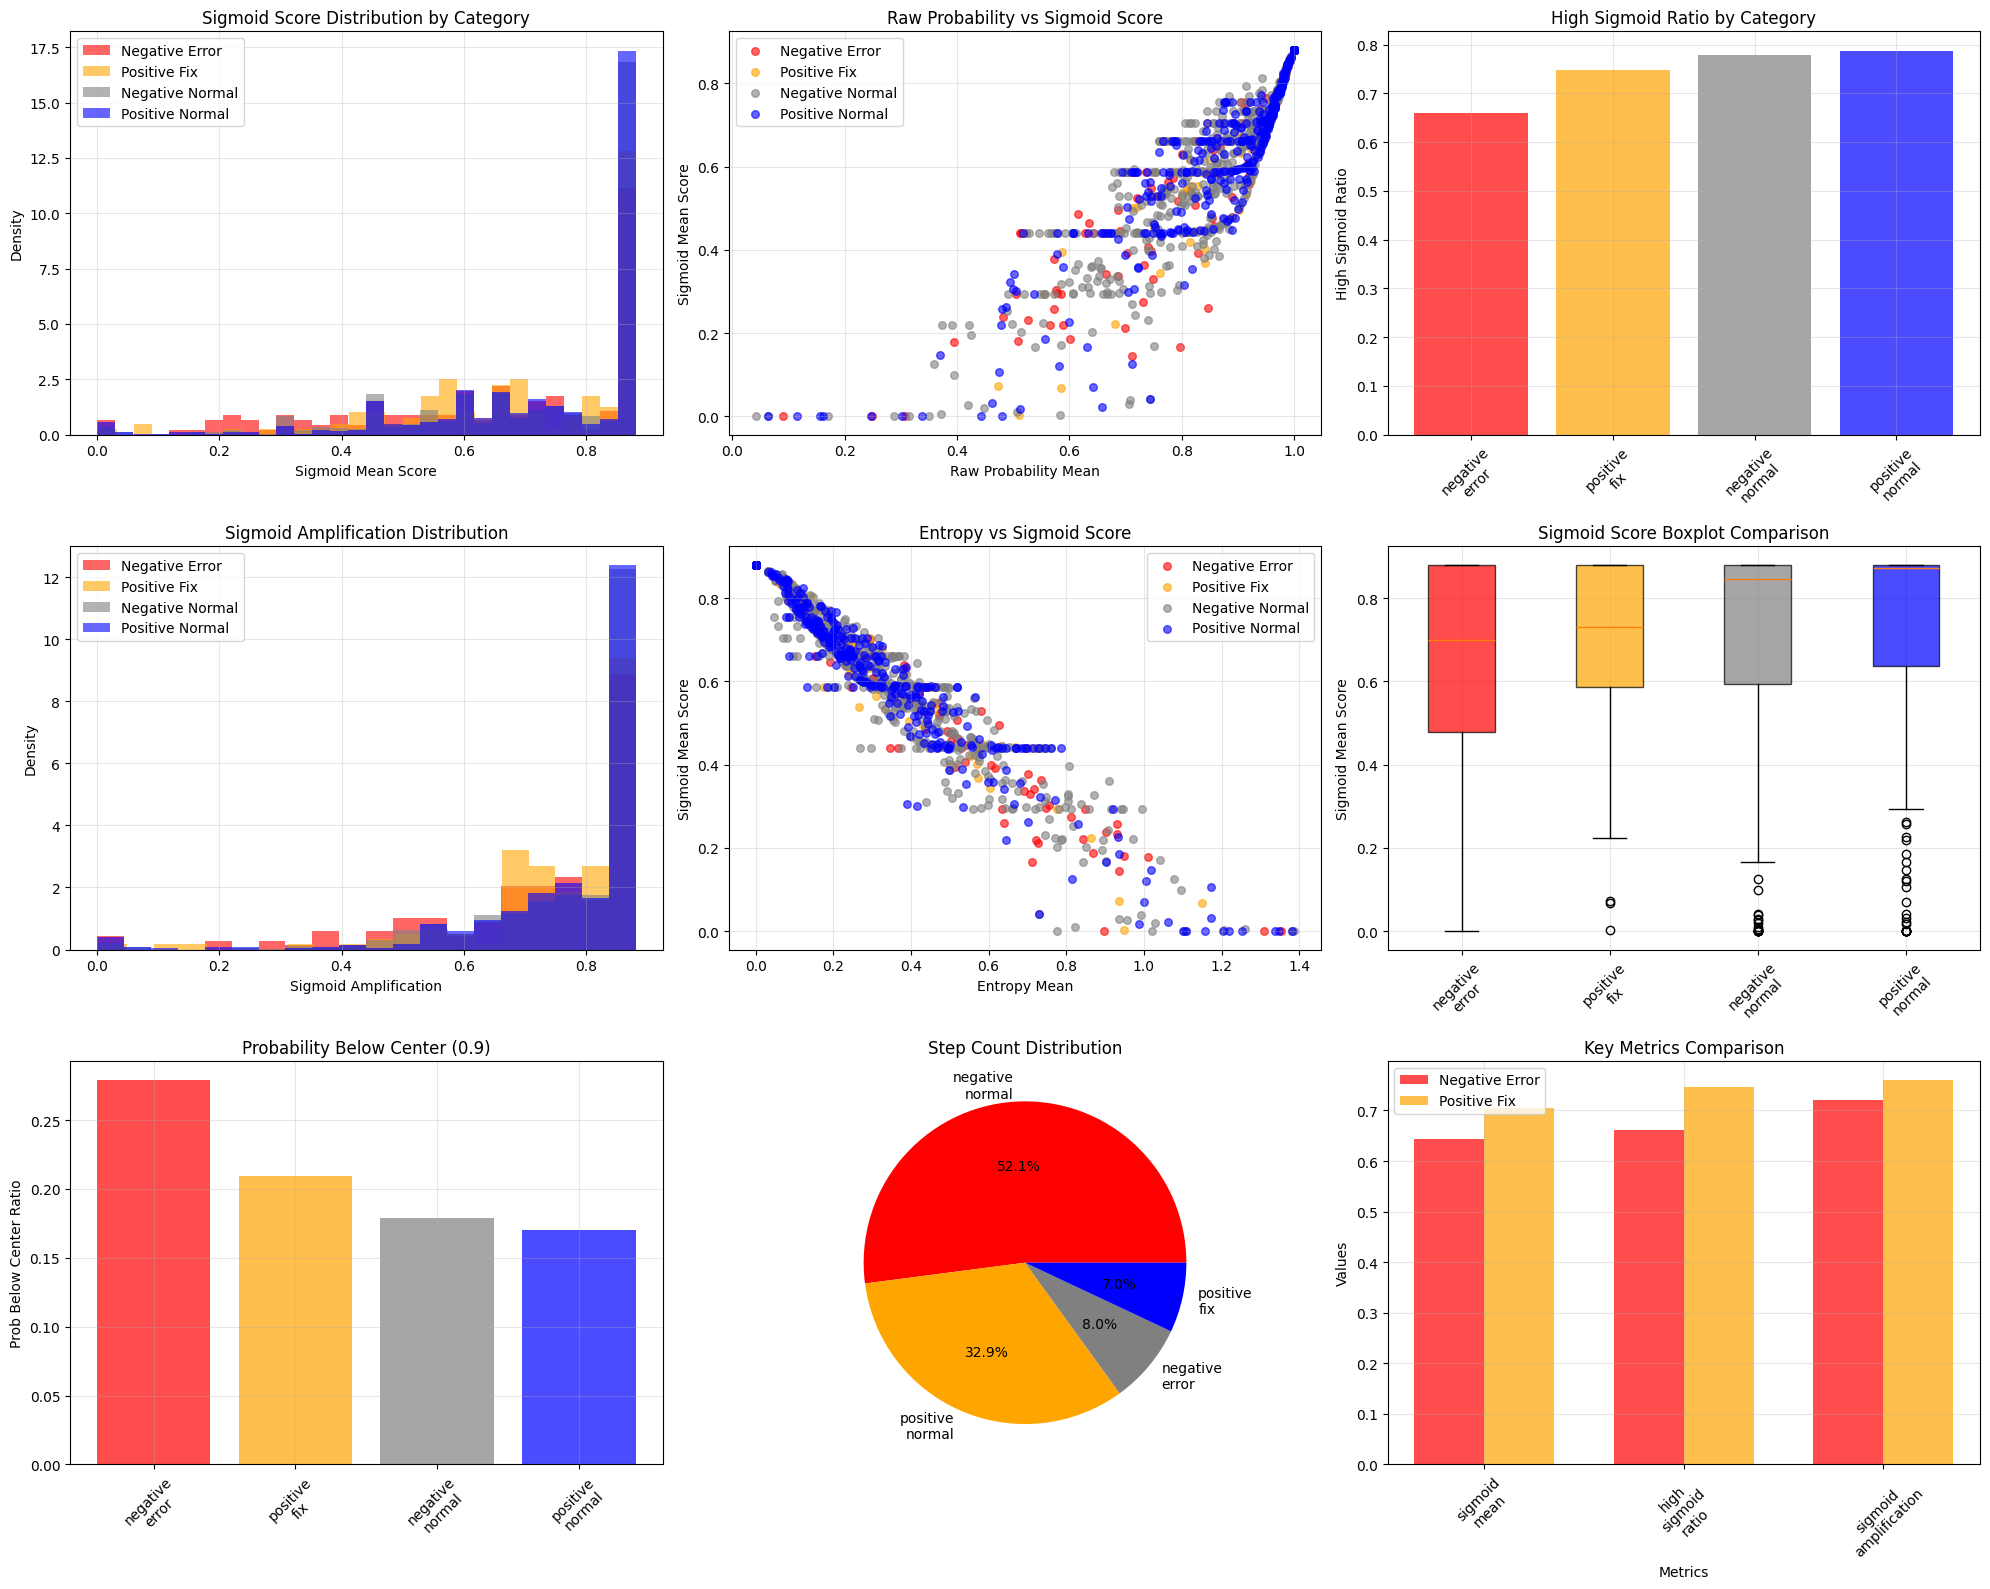

📊 综合分析图已保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/sigmoid_analysis_comprehensive_700-731.png
✅ 分析结果已保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/sigmoid_analysis_results_700-731.json
✅ 分析数据已保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/sigmoid_analysis_data_700-731.csv

Sigmoid分析完成！
📊 总步骤数: 1944
📊 类别分布:
  negative_normal: 1012
  positive_normal: 640
  negative_error: 156
  positive_fix: 136
📁 所有文件保存在: /content/drive/MyDrive/Cluster-proj/output/step_cross


In [ ]:
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import entropy, ks_2samp, mannwhitneyu, ttest_ind
import seaborn as sns

# ✅ 参数设置
start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json"
SAVE_PATH = f"{BASE_PATH}/output/step_cross2"
os.makedirs(SAVE_PATH, exist_ok=True)

# # ✅ 加载数据
# with open(LOGITS_PATH, "r") as f:
#     logits_data = json.load(f)

# with open(ERROR_INDEX_PATH, "r") as f:
#     index_data = json.load(f)

# === Step 1: 构建 step_data（从 logits_data 和 index_data 中提取） ===

def map_error_index_to_steps(similarities, error_start, error_end, steps):
    """映射error索引到steps"""
    error_steps = set()
    for i in range(len(steps) - 1):
        s, e = steps[i], steps[i+1]
        if any(error_start <= j <= error_end for j in range(s, e)):
            error_steps.add(i)
    return error_steps

def map_fix_index_to_steps(similarities, fix_start, fix_end, steps):
    """映射fix索引到steps"""
    fix_steps = set()
    for i in range(len(steps) - 1):
        s, e = steps[i], steps[i+1]
        if any(fix_start <= j <= fix_end for j in range(s, e)):
            fix_steps.add(i)
    return fix_steps

def compute_token_similarities(token_level):
    """计算token间的cosine similarity"""
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        np.dot(vectors[i], vectors[i+1]) /
        (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[i+1]) + 1e-8)
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    """基于similarity valleys找到step boundaries"""
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

# 建立负样本到正样本的映射
neg_to_pos_mapping = {}
for qid, sid_dict in index_data.items():
    for neg_sid, region_info in sid_dict.items():
        correct_sid = region_info.get("correct_sampling_id")
        if correct_sid:
            neg_to_pos_mapping[(qid, neg_sid)] = (qid, correct_sid)

print(f"✅ 找到 {len(neg_to_pos_mapping)} 个负样本->正样本映射")

# 构建step_data
step_data = {}

# 处理所有样本 (正样本和负样本)
all_samples = set()
for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid in sample and "token_probs" in sample[sid]:
            all_samples.add((qid, sid))

for qid, sid in all_samples:
    sample = logits_data[qid][sid]
    token_level = sample["token_probs"]
    similarities = compute_token_similarities(token_level)
    steps = find_steps(similarities)

    for i in range(len(steps) - 1):
        s_idx, e_idx = steps[i], steps[i+1]

        # 提取step内的token数据
        vecs = [token_level[j]["hidden_vector"] for j in range(s_idx, e_idx) if "hidden_vector" in token_level[j]]
        probs = [token_level[j]["chosen_prob"] for j in range(s_idx, e_idx) if "chosen_prob" in token_level[j]]
        ents = [token_level[j]["topk_info"]["entropy"] for j in range(s_idx, e_idx)
                if "topk_info" in token_level[j] and "entropy" in token_level[j]["topk_info"]]

        if not vecs:
            continue

        step_key = f"step_{i}"
        if qid not in step_data:
            step_data[qid] = {}
        if sid not in step_data[qid]:
            step_data[qid][sid] = {}

        step_info = {
            "token_range": f"{s_idx}-{e_idx}",
            "vec_mean": np.mean(vecs, axis=0).tolist(),
            "entropy_mean": float(np.mean(ents)) if ents else 0.0,
            "probs": probs,
            "sample_type": "unknown",  # 将被后续设置
            "region_type": "normal",   # normal, error, fix
            "step_index": i
        }

        # 检查是否是负样本
        if qid in index_data and sid in index_data[qid]:
            step_info["sample_type"] = "negative"

            # 检查error region
            err_info = index_data[qid][sid]
            err_start = err_info.get("error_token_begin_index")
            err_end = err_info.get("error_token_end_index")

            if err_start is not None and err_end is not None and err_start != -1 and err_end != -1:
                try:
                    error_steps = map_error_index_to_steps(similarities, err_start, err_end, steps)
                    if i in error_steps:
                        step_info["region_type"] = "error"
                except Exception as e:
                    print(f"❌ Error映射失败: qid={qid}, sid={sid}, err=({err_start}, {err_end}) -> {e}")
                    continue

        # 检查是否是对应的正样本
        for (neg_qid, neg_sid), (pos_qid, pos_sid) in neg_to_pos_mapping.items():
            if pos_qid == qid and pos_sid == sid:
                step_info["sample_type"] = "positive"
                step_info["corresponding_negative"] = f"{neg_qid}_{neg_sid}"

                # 检查fix region
                neg_region_info = index_data[neg_qid][neg_sid]
                fix_start = neg_region_info.get("fix_token_begin_index")
                fix_end = neg_region_info.get("fix_token_end_index")

                if fix_start is not None and fix_end is not None and fix_start != -1 and fix_end != -1:
                    try:
                        fix_steps = map_fix_index_to_steps(similarities, fix_start, fix_end, steps)
                        if i in fix_steps:
                            step_info["region_type"] = "fix"
                    except Exception as e:
                        print(f"❌ Fix映射失败: qid={qid}, sid={sid}, fix=({fix_start}, {fix_end}) -> {e}")
                        continue
                break

        step_data[qid][sid][step_key] = step_info

print("✅ step_data 构建完成")

# === Step 2: Sigmoid处理和指标计算 ===

def sigmoid_scaled(x, center=0.9, scale=20):
    """Scaled sigmoid function"""
    return 1 / (1 + np.exp(-scale * (x - center)))

def compute_sigmoid_metrics(probs, center=0.9, scale=20):
    """计算sigmoid相关指标"""
    if not probs or len(probs) == 0:
        return {}

    probs = np.array(probs)
    sigmoid_scores = sigmoid_scaled(probs, center=center, scale=scale)

    metrics = {
        # 基础统计
        'raw_prob_mean': float(np.mean(probs)),
        'raw_prob_std': float(np.std(probs)),
        'raw_prob_min': float(np.min(probs)),
        'raw_prob_max': float(np.max(probs)),

        # Sigmoid转换后统计
        'sigmoid_mean': float(np.mean(sigmoid_scores)),
        'sigmoid_std': float(np.std(sigmoid_scores)),
        'sigmoid_min': float(np.min(sigmoid_scores)),
        'sigmoid_max': float(np.max(sigmoid_scores)),

        # 分布特征
        'high_sigmoid_ratio': float(np.mean(sigmoid_scores > 0.8)),      # 高sigmoid比例
        'medium_sigmoid_ratio': float(np.mean((sigmoid_scores > 0.5) & (sigmoid_scores <= 0.8))),  # 中等sigmoid比例
        'low_sigmoid_ratio': float(np.mean(sigmoid_scores <= 0.5)),      # 低sigmoid比例

        # 原始概率特征
        'high_prob_ratio': float(np.mean(probs > 0.9)),                  # 高概率比例
        'medium_prob_ratio': float(np.mean((probs > 0.7) & (probs <= 0.9))),  # 中等概率比例
        'low_prob_ratio': float(np.mean(probs <= 0.7)),                  # 低概率比例

        # Sigmoid变换效果
        'sigmoid_amplification': float(np.mean(sigmoid_scores) / (np.mean(probs) + 1e-8)),  # 放大效果
        'sigmoid_variance_ratio': float(np.var(sigmoid_scores) / (np.var(probs) + 1e-8)),   # 方差变化

        # 极值统计
        'prob_below_center': float(np.mean(probs < center)),             # 低于center的比例
        'sigmoid_saturation_high': float(np.mean(sigmoid_scores > 0.99)), # 高饱和比例
        'sigmoid_saturation_low': float(np.mean(sigmoid_scores < 0.01)),  # 低饱和比例

        # token数量
        'n_tokens': len(probs)
    }

    return metrics

# 为每个step计算sigmoid指标
for qid, qid_data in step_data.items():
    for sid, steps in qid_data.items():
        for step_key, step_info in steps.items():
            probs = step_info.get("probs", [])
            if probs:
                sigmoid_metrics = compute_sigmoid_metrics(probs)
                step_info.update(sigmoid_metrics)

print("✅ Sigmoid指标计算完成")

# === Step 3: 数据整理和统计分析 ===

# 构建分析用的DataFrame
analysis_rows = []

for qid, qid_data in step_data.items():
    for sid, steps in qid_data.items():
        for step_key, step_info in steps.items():
            if step_info.get("sample_type") in ["positive", "negative"] and "sigmoid_mean" in step_info:
                row = {
                    "qid": qid,
                    "sid": sid,
                    "step": step_key,
                    "sample_type": step_info["sample_type"],
                    "region_type": step_info["region_type"],
                    "category": f"{step_info['sample_type']}_{step_info['region_type']}",
                    "entropy_mean": step_info["entropy_mean"],
                }

                # 添加所有sigmoid指标
                for key in ['raw_prob_mean', 'sigmoid_mean', 'high_sigmoid_ratio',
                           'sigmoid_amplification', 'prob_below_center', 'n_tokens']:
                    if key in step_info:
                        row[key] = step_info[key]

                analysis_rows.append(row)

df_analysis = pd.DataFrame(analysis_rows)

print(f"✅ 分析数据构建完成，共 {len(df_analysis)} 个steps")
print("分类统计:")
print(df_analysis['category'].value_counts())

# === Step 4: 统计分析 ===

def compute_category_statistics(df, metric_cols):
    """计算各类别的统计数据"""
    stats = {}

    for category in df['category'].unique():
        cat_data = df[df['category'] == category]

        stats[category] = {}
        for col in metric_cols:
            if col in cat_data.columns:
                values = cat_data[col].dropna()
                if len(values) > 0:
                    stats[category][col] = {
                        'mean': float(np.mean(values)),
                        'std': float(np.std(values)),
                        'median': float(np.median(values)),
                        'min': float(np.min(values)),
                        'max': float(np.max(values)),
                        'count': len(values)
                    }

    return stats

# 关键指标
key_metrics = ['raw_prob_mean', 'sigmoid_mean', 'high_sigmoid_ratio',
               'sigmoid_amplification', 'prob_below_center', 'entropy_mean']

category_stats = compute_category_statistics(df_analysis, key_metrics)

# 打印统计结果
print("\n" + "="*60)
print("各类别Sigmoid指标统计")
print("="*60)

for category, stats in category_stats.items():
    print(f"\n📊 {category}:")
    for metric, values in stats.items():
        print(f"  {metric}: {values['mean']:.3f} ± {values['std']:.3f} "
              f"(min: {values['min']:.3f}, max: {values['max']:.3f}, n: {values['count']})")

# === Step 5: 显著性测试 ===

def statistical_tests(df, metric):
    """对不同类别进行统计显著性测试"""

    # 主要对比: negative_error vs positive_fix
    neg_error = df[df['category'] == 'negative_error'][metric].dropna()
    pos_fix = df[df['category'] == 'positive_fix'][metric].dropna()

    results = {}

    if len(neg_error) > 0 and len(pos_fix) > 0:
        # T检验
        t_stat, t_p = ttest_ind(neg_error, pos_fix)

        # Mann-Whitney U检验
        u_stat, u_p = mannwhitneyu(neg_error, pos_fix, alternative='two-sided')

        # Kolmogorov-Smirnov检验
        ks_stat, ks_p = ks_2samp(neg_error, pos_fix)

        results['negative_error_vs_positive_fix'] = {
            't_test': {'statistic': float(t_stat), 'p_value': float(t_p)},
            'mannwhitney': {'statistic': float(u_stat), 'p_value': float(u_p)},
            'ks_test': {'statistic': float(ks_stat), 'p_value': float(ks_p)},
            'effect_size': float((np.mean(neg_error) - np.mean(pos_fix)) /
                                np.sqrt((np.var(neg_error) + np.var(pos_fix)) / 2))
        }

    return results

print("\n" + "="*60)
print("统计显著性测试结果")
print("="*60)

for metric in ['sigmoid_mean', 'high_sigmoid_ratio', 'sigmoid_amplification']:
    if metric in df_analysis.columns:
        test_results = statistical_tests(df_analysis, metric)

        if 'negative_error_vs_positive_fix' in test_results:
            results = test_results['negative_error_vs_positive_fix']
            print(f"\n🔍 {metric} (Negative Error vs Positive Fix):")
            print(f"  T检验: t={results['t_test']['statistic']:.3f}, p={results['t_test']['p_value']:.3f}")
            print(f"  Mann-Whitney: U={results['mannwhitney']['statistic']:.3f}, p={results['mannwhitney']['p_value']:.3f}")
            print(f"  K-S检验: KS={results['ks_test']['statistic']:.3f}, p={results['ks_test']['p_value']:.3f}")
            print(f"  效应量: {results['effect_size']:.3f}")

# === Step 6: 可视化 ===

def create_comprehensive_plots(df):
    """创建综合可视化"""

    # 设置图形样式
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 16))

    # 1. Sigmoid分数分布对比
    ax1 = plt.subplot(3, 3, 1)
    categories = ['negative_error', 'positive_fix', 'negative_normal', 'positive_normal']
    colors = ['red', 'orange', 'gray', 'blue']

    for category, color in zip(categories, colors):
        if category in df['category'].values:
            data = df[df['category'] == category]['sigmoid_mean'].dropna()
            if len(data) > 0:
                plt.hist(data, bins=30, alpha=0.6, label=category.replace('_', ' ').title(),
                        color=color, density=True)

    plt.xlabel('Sigmoid Mean Score')
    plt.ylabel('Density')
    plt.title('Sigmoid Score Distribution by Category')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. 原始概率 vs Sigmoid分数散点图
    ax2 = plt.subplot(3, 3, 2)
    for category, color in zip(categories, colors):
        if category in df['category'].values:
            cat_data = df[df['category'] == category]
            if len(cat_data) > 0:
                plt.scatter(cat_data['raw_prob_mean'], cat_data['sigmoid_mean'],
                           alpha=0.6, c=color, label=category.replace('_', ' ').title(), s=30)

    plt.xlabel('Raw Probability Mean')
    plt.ylabel('Sigmoid Mean Score')
    plt.title('Raw Probability vs Sigmoid Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. 高Sigmoid比例对比
    ax3 = plt.subplot(3, 3, 3)
    cat_means = []
    cat_names = []
    cat_colors = []

    for category, color in zip(categories, colors):
        if category in df['category'].values:
            data = df[df['category'] == category]['high_sigmoid_ratio'].dropna()
            if len(data) > 0:
                cat_means.append(np.mean(data))
                cat_names.append(category.replace('_', '\n'))
                cat_colors.append(color)

    plt.bar(cat_names, cat_means, color=cat_colors, alpha=0.7)
    plt.ylabel('High Sigmoid Ratio')
    plt.title('High Sigmoid Ratio by Category')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 4. Sigmoid放大效果
    ax4 = plt.subplot(3, 3, 4)
    for category, color in zip(categories, colors):
        if category in df['category'].values:
            data = df[df['category'] == category]['sigmoid_amplification'].dropna()
            if len(data) > 0:
                plt.hist(data, bins=20, alpha=0.6, label=category.replace('_', ' ').title(),
                        color=color, density=True)

    plt.xlabel('Sigmoid Amplification')
    plt.ylabel('Density')
    plt.title('Sigmoid Amplification Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. 熵值 vs Sigmoid分数
    ax5 = plt.subplot(3, 3, 5)
    for category, color in zip(categories, colors):
        if category in df['category'].values:
            cat_data = df[df['category'] == category]
            if len(cat_data) > 0:
                plt.scatter(cat_data['entropy_mean'], cat_data['sigmoid_mean'],
                           alpha=0.6, c=color, label=category.replace('_', ' ').title(), s=30)

    plt.xlabel('Entropy Mean')
    plt.ylabel('Sigmoid Mean Score')
    plt.title('Entropy vs Sigmoid Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. 箱型图对比
    ax6 = plt.subplot(3, 3, 6)
    box_data = []
    box_labels = []

    for category in categories:
        if category in df['category'].values:
            data = df[df['category'] == category]['sigmoid_mean'].dropna()
            if len(data) > 0:
                box_data.append(data)
                box_labels.append(category.replace('_', '\n'))

    bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    plt.ylabel('Sigmoid Mean Score')
    plt.title('Sigmoid Score Boxplot Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 7. 低于center的概率比例
    ax7 = plt.subplot(3, 3, 7)
    cat_means = []
    cat_names = []

    for category in categories:
        if category in df['category'].values:
            data = df[df['category'] == category]['prob_below_center'].dropna()
            if len(data) > 0:
                cat_means.append(np.mean(data))
                cat_names.append(category.replace('_', '\n'))

    plt.bar(cat_names, cat_means, color=colors[:len(cat_means)], alpha=0.7)
    plt.ylabel('Prob Below Center Ratio')
    plt.title('Probability Below Center (0.9)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 8. Step数量分布
    ax8 = plt.subplot(3, 3, 8)
    step_counts = df['category'].value_counts()
    plt.pie(step_counts.values, labels=[cat.replace('_', '\n') for cat in step_counts.index],
            autopct='%1.1f%%', colors=colors[:len(step_counts)])
    plt.title('Step Count Distribution')

    # 9. 综合对比雷达图 (简化版)
    ax9 = plt.subplot(3, 3, 9)
    metrics_for_radar = ['sigmoid_mean', 'high_sigmoid_ratio', 'sigmoid_amplification']

    # 计算各类别的标准化指标
    radar_data = {}
    for category in ['negative_error', 'positive_fix']:
        if category in df['category'].values:
            cat_data = df[df['category'] == category]
            radar_values = []
            for metric in metrics_for_radar:
                if metric in cat_data.columns:
                    radar_values.append(np.mean(cat_data[metric].dropna()))
                else:
                    radar_values.append(0)
            radar_data[category] = radar_values

    x = np.arange(len(metrics_for_radar))
    width = 0.35

    if 'negative_error' in radar_data and 'positive_fix' in radar_data:
        plt.bar(x - width/2, radar_data['negative_error'], width,
               label='Negative Error', color='red', alpha=0.7)
        plt.bar(x + width/2, radar_data['positive_fix'], width,
               label='Positive Fix', color='orange', alpha=0.7)

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Key Metrics Comparison')
    plt.xticks(x, [m.replace('_', '\n') for m in metrics_for_radar], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # 保存图片
    save_path = os.path.join(SAVE_PATH, f"sigmoid_analysis_comprehensive_{range_tag}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📊 综合分析图已保存到: {save_path}")

# 生成可视化
create_comprehensive_plots(df_analysis)

# === Step 7: 保存结果 ===

# 保存统计结果
results = {
    "category_statistics": category_stats,
    "data_summary": {
        "total_steps": len(df_analysis),
        "categories": df_analysis['category'].value_counts().to_dict(),
        "range_tag": range_tag
    },
    "key_findings": {
        "most_discriminative_metrics": [],
        "significant_differences": []
    }
}

# 保存到JSON
results_path = os.path.join(SAVE_PATH, f"sigmoid_analysis_results_{range_tag}.json")
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"✅ 分析结果已保存到: {results_path}")

# 保存DataFrame
df_path = os.path.join(SAVE_PATH, f"sigmoid_analysis_data_{range_tag}.csv")
df_analysis.to_csv(df_path, index=False)
print(f"✅ 分析数据已保存到: {df_path}")

print("\n" + "="*60)
print("Sigmoid分析完成！")
print("="*60)
print(f"📊 总步骤数: {len(df_analysis)}")
print("📊 类别分布:")
for category, count in df_analysis['category'].value_counts().items():
    print(f"  {category}: {count}")
print(f"📁 所有文件保存在: {SAVE_PATH}")

In [ ]:
# === Step 8: 单独比较 error 和 fix 区域 ===

def compare_error_fix_regions(df, metrics):
    # 过滤出 error 和 fix 区域
    error_df = df[df["region_type"] == "error"]
    fix_df = df[df["region_type"] == "fix"]

    print("\n" + "="*60)
    print("📊 Error Region vs Fix Region 比较")
    print("="*60)

    comparison_results = []

    for metric in metrics:
        error_vals = error_df[metric].dropna()
        fix_vals = fix_df[metric].dropna()

        if len(error_vals) == 0 or len(fix_vals) == 0:
            print(f"⚠️ 指标 {metric} 缺少数据，跳过")
            continue

        t_stat, t_p = ttest_ind(error_vals, fix_vals)
        u_stat, u_p = mannwhitneyu(error_vals, fix_vals, alternative='two-sided')
        ks_stat, ks_p = ks_2samp(error_vals, fix_vals)
        effect_size = (np.mean(error_vals) - np.mean(fix_vals)) / np.sqrt((np.var(error_vals) + np.var(fix_vals)) / 2)

        print(f"\n🔍 指标: {metric}")
        print(f"  📌 Error: mean={np.mean(error_vals):.3f}, std={np.std(error_vals):.3f}, n={len(error_vals)}")
        print(f"  📌 Fix:   mean={np.mean(fix_vals):.3f}, std={np.std(fix_vals):.3f}, n={len(fix_vals)}")
        print(f"  ✅ T检验: t={t_stat:.3f}, p={t_p:.3f}")
        print(f"  ✅ Mann-Whitney: U={u_stat:.3f}, p={u_p:.3f}")
        print(f"  ✅ K-S检验: KS={ks_stat:.3f}, p={ks_p:.3f}")
        print(f"  ✅ 效应量 (Cohen's d): {effect_size:.3f}")

        comparison_results.append({
            "metric": metric,
            "error_mean": float(np.mean(error_vals)),
            "fix_mean": float(np.mean(fix_vals)),
            "t_test_p": float(t_p),
            "u_test_p": float(u_p),
            "ks_test_p": float(ks_p),
            "effect_size": float(effect_size)
        })

    return comparison_results

# 选择关键指标进行比较
region_metrics = ["sigmoid_mean", "high_sigmoid_ratio", "sigmoid_amplification",
                  "raw_prob_mean", "prob_below_center", "entropy_mean"]

region_comparison = compare_error_fix_regions(df_analysis, region_metrics)

# ✅ 保存结果
region_path = os.path.join(SAVE_PATH, f"region_comparison_{range_tag}.json")
with open(region_path, "w") as f:
    json.dump(region_comparison, f, indent=2)

print(f"\n📁 区域对比分析结果已保存到: {region_path}")



📊 Error Region vs Fix Region 比较

🔍 指标: sigmoid_mean
  📌 Error: mean=0.644, std=0.236, n=156
  📌 Fix:   mean=0.704, std=0.192, n=136
  ✅ T检验: t=-2.364, p=0.019
  ✅ Mann-Whitney: U=9355.000, p=0.078
  ✅ K-S检验: KS=0.148, p=0.073
  ✅ 效应量 (Cohen's d): -0.280

🔍 指标: high_sigmoid_ratio
  📌 Error: mean=0.661, std=0.312, n=156
  📌 Fix:   mean=0.747, std=0.248, n=136
  ✅ T检验: t=-2.581, p=0.010
  ✅ Mann-Whitney: U=9112.000, p=0.034
  ✅ K-S检验: KS=0.145, p=0.084
  ✅ 效应量 (Cohen's d): -0.306

🔍 指标: sigmoid_amplification
  📌 Error: mean=0.721, std=0.191, n=156
  📌 Fix:   mean=0.760, std=0.154, n=136
  ✅ T检验: t=-1.889, p=0.060
  ✅ Mann-Whitney: U=9686.000, p=0.194
  ✅ K-S检验: KS=0.141, p=0.097
  ✅ 效应量 (Cohen's d): -0.224

🔍 指标: raw_prob_mean
  📌 Error: mean=0.857, std=0.176, n=156
  📌 Fix:   mean=0.908, std=0.118, n=136
  ✅ T检验: t=-2.879, p=0.004
  ✅ Mann-Whitney: U=9168.000, p=0.041
  ✅ K-S检验: KS=0.163, p=0.037
  ✅ 效应量 (Cohen's d): -0.343

🔍 指标: prob_below_center
  📌 Error: mean=0.279, std=0.284, n=15

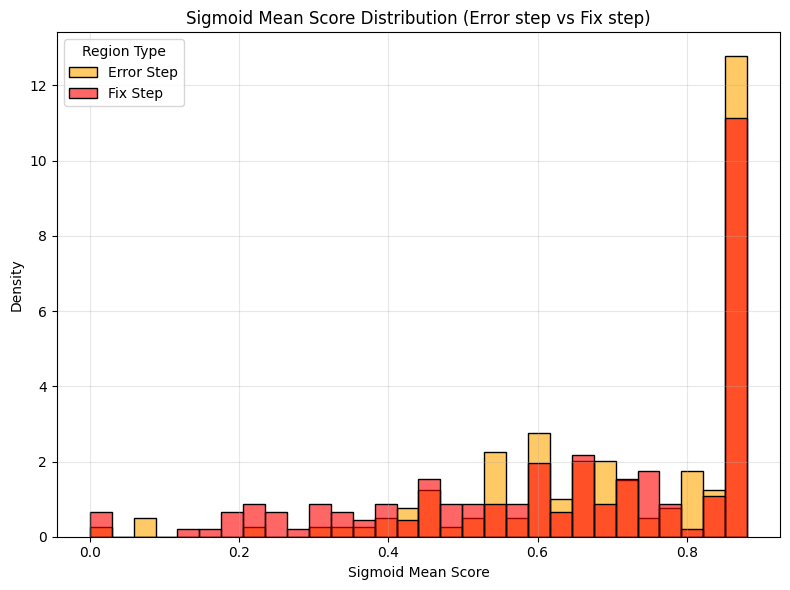

✅ Sigmoid Mean 分布图（Error vs Fix）已保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/sigmoid_mean_error_vs_fix_700-731.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sigmoid_distribution_error_vs_fix(df, save_dir, tag):
    # 筛选 error 和 fix
    subset_df = df[df["region_type"].isin(["error", "fix"]) & df["sigmoid_mean"].notnull()]

    plt.figure(figsize=(8, 6))

    sns.histplot(
        data=subset_df,
        x="sigmoid_mean",
        hue="region_type",
        hue_order=["error", "fix"],
        bins=30,
        stat="density",
        common_norm=False,
        palette={"error": "red", "fix": "orange"},
        alpha=0.6
    )

    plt.title("Sigmoid Mean Score Distribution (Error step vs Fix step)")
    plt.xlabel("Sigmoid Mean Score")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Region Type", labels=["Error Step", "Fix Step"])

    save_path = os.path.join(save_dir, f"sigmoid_mean_error_vs_fix_{tag}.png")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"✅ Sigmoid Mean 分布图（Error vs Fix）已保存到: {save_path}")

# 调用函数
plot_sigmoid_distribution_error_vs_fix(
    df=df_analysis,
    save_dir=SAVE_PATH,
    tag=range_tag
)


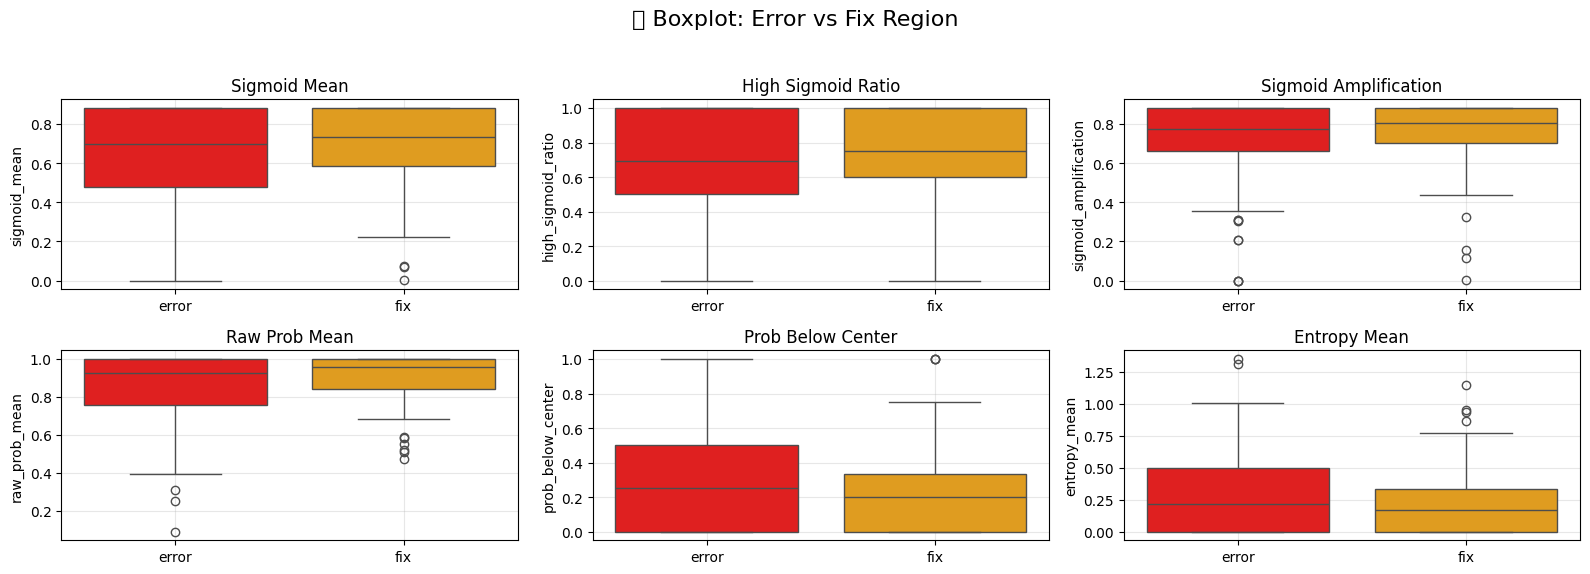

✅ 箱型图保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/error_fix_boxplot_700-731.png


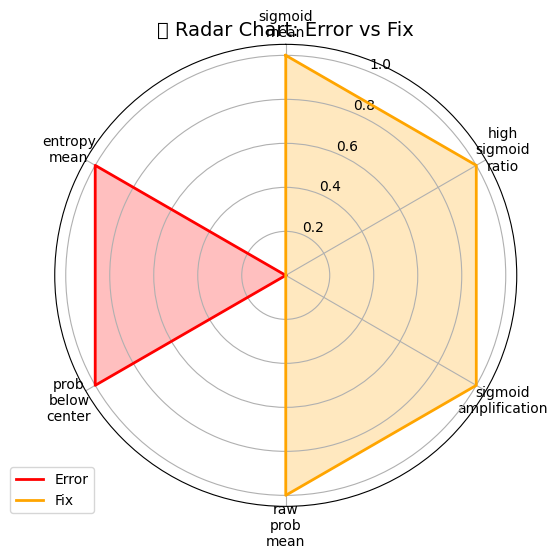

✅ 雷达图保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/error_fix_radar_700-731.png


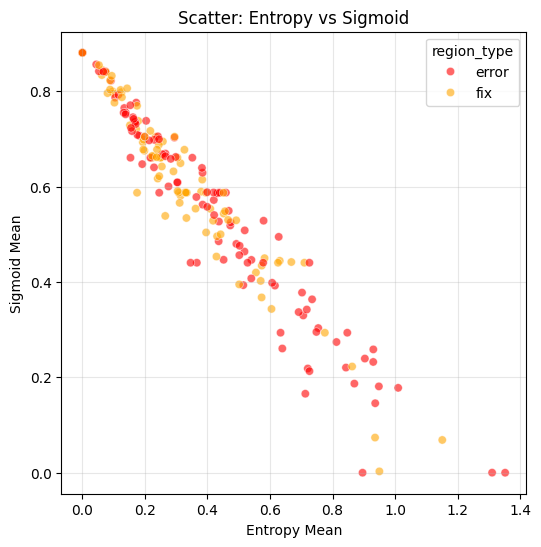

✅ 散点图保存到: /content/drive/MyDrive/Cluster-proj/output/step_cross/error_fix_entropy_sigmoid_700-731.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_error_vs_fix(df, metrics, save_dir, tag):
    # 筛选 error 和 fix 区域
    error_df = df[df["region_type"] == "error"]
    fix_df = df[df["region_type"] == "fix"]

    if error_df.empty or fix_df.empty:
        print("❌ 没有足够的 error 或 fix 区域数据，跳过可视化")
        return

    # 1. 📦 箱型图对比
    plt.figure(figsize=(16, 6))
    for i, metric in enumerate(metrics):
        plt.subplot(2, (len(metrics)+1)//2, i+1)
        sns.boxplot(
            data=df[df["region_type"].isin(["error", "fix"])],
            x="region_type",
            y=metric,
            palette={"error": "red", "fix": "orange"}
        )
        plt.title(metric.replace("_", " ").title())
        plt.xlabel("")
        plt.grid(True, alpha=0.3)
    plt.suptitle("📦 Boxplot: Error vs Fix Region", fontsize=16)
    boxplot_path = os.path.join(save_dir, f"error_fix_boxplot_{tag}.png")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(boxplot_path, dpi=300)
    plt.show()
    print(f"✅ 箱型图保存到: {boxplot_path}")

    # 2. 📈 雷达图对比
    from math import pi

    radar_metrics = metrics
    values_error = [error_df[m].mean() for m in radar_metrics]
    values_fix = [fix_df[m].mean() for m in radar_metrics]

    # 归一化 0-1（防止尺度差异）
    all_values = np.array([values_error, values_fix])
    norm_min = all_values.min(axis=0)
    norm_max = all_values.max(axis=0)
    norm_values = (all_values - norm_min) / (norm_max - norm_min + 1e-8)

    categories = radar_metrics
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], [m.replace("_", "\n") for m in categories], size=10)

    for values, label, color in zip(norm_values, ["Error", "Fix"], ["red", "orange"]):
        data = list(values) + [values[0]]
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=label, color=color)
        ax.fill(angles, data, alpha=0.25, color=color)

    plt.title("🌐 Radar Chart: Error vs Fix", size=14)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    radar_path = os.path.join(save_dir, f"error_fix_radar_{tag}.png")
    plt.savefig(radar_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ 雷达图保存到: {radar_path}")

    # 3. 🔍 散点图：熵 vs Sigmoid
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=df[df["region_type"].isin(["error", "fix"])],
        x="entropy_mean", y="sigmoid_mean", hue="region_type",
        palette={"error": "red", "fix": "orange"}, alpha=0.6
    )
    plt.title("Scatter: Entropy vs Sigmoid")
    plt.grid(True, alpha=0.3)
    plt.xlabel("Entropy Mean")
    plt.ylabel("Sigmoid Mean")
    scatter_path = os.path.join(save_dir, f"error_fix_entropy_sigmoid_{tag}.png")
    plt.savefig(scatter_path, dpi=300)
    plt.show()
    print(f"✅ 散点图保存到: {scatter_path}")

# 调用可视化函数
visualize_error_vs_fix(
    df=df_analysis,
    metrics=["sigmoid_mean", "high_sigmoid_ratio", "sigmoid_amplification",
             "raw_prob_mean", "prob_below_center", "entropy_mean"],
    save_dir=SAVE_PATH,
    tag=range_tag
)


In [ ]:
qid_to_step_data['q_700'].keys()

dict_keys(['sampling0', 'sampling1', 'sampling2'])

In [ ]:
qid_to_step_data['q_700']['sampling1']['step_4'].keys()

dict_keys(['start', 'end', 'vec_mean', 'entropy_mean', 'prob_mean', 'is_error_step', 'is_fix_step', 'step_type'])

In [ ]:
qid_to_step_data['q_700']['sampling2']['step_6']['start']

31

In [ ]:
index_data['q_721']

{'sampling2': {'first_error_sentence': 'What is your answer?',
  'error_reason': 'The answer does not address the question or attempt any calculations; instead, it asks a question back to the user.',
  'fix_sentence': 'To buy one smartphone, you have to pay $300.',
  'fix_reason': 'This initiates the proper solution process by starting the necessary price breakdown for the products as required by the problem.',
  'correct_sampling_id': 'sampling0',
  'error_token_begin_index': 0,
  'error_token_end_index': 4,
  'fix_token_begin_index': 5,
  'fix_token_end_index': 18}}

In [ ]:
logits_data['q_721'].keys()


dict_keys(['question', 'true_whole_answer', 'true_final_result', 'sampling0', 'sampling1', 'sampling2'])

In [ ]:
logits_data['q_721']['true_final_result']


'2200'

In [ ]:
logits_data['q_721']['sampling0'].keys()

dict_keys(['whole_answer', 'token_probs', 'final_result'])

In [ ]:
logits_data['q_721']['sampling0']['token_probs'][7].keys()

dict_keys(['token', 'chosen_prob', 'information_content', 'topk_info', 'hidden_vector'])

In [ ]:
logits_data['q_721']['sampling0']['token_probs'][7]['topk_info']

{'indices': [634, 245, 0],
 'logits': [55.98214340209961, 55.84821701049805, -inf],
 'softmax': [0.5334315896034241, 0.46656835079193115, 0.0],
 'entropy': 0.9967726958495955,
 'information_content': [0.9066248316506884, 1.0998396480542127, 0.0]}

In [ ]:
logits_data['q_721']['sampling0']['final_result']

'2200'

In [ ]:
def compute_token_similarities(token_level):
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
        for i in range(len(vectors) - 1)
    ]


In [ ]:
sim = compute_token_similarities(logits_data['q_721']['sampling0']['token_probs'])

In [ ]:
sim[119]

np.float64(-0.020867949255977125)

In [ ]:
len(compute_token_similarities(logits_data['q_721']['sampling0']['token_probs']))

120

In [ ]:
len(logits_data['q_721']['sampling0']['token_probs'])

121

In [ ]:
def find_steps(similarities, distance=15, prominence=0.3):
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    # print([0] + peaks.tolist() + [len(similarities)])
    return [0] + peaks.tolist() + [len(similarities)]  # 保证首尾闭合

In [ ]:
find_steps(sim)

[0,
 2,
 7,
 12,
 17,
 19,
 23,
 29,
 32,
 39,
 42,
 45,
 49,
 55,
 58,
 65,
 67,
 72,
 75,
 78,
 83,
 88,
 92,
 96,
 98,
 101,
 105,
 108,
 111,
 114,
 117,
 120]

In [ ]:
def map_index_to_step(similarities, start, end, steps):
    # step_bounds = find_steps(similarities)
    steps = set()
    for i in range(len(steps) - 1):
        s, e = steps[i], steps[i+1]
        if any(start <= j <= end for j in range(s, e)):
            steps.add(i)
    return steps


In [ ]:
# 快速检查前5个 token 是否包含 entropy 字段
for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid in sample and "token_probs" in sample[sid]:
            tokens = sample[sid]["token_probs"]
            for i, tok in enumerate(tokens[:5]):
                print(f"[{qid}][{sid}][{i}] keys = {list(tok.keys())}")
            break
    break


[q_700][sampling0][0] keys = ['token', 'chosen_prob', 'information_content', 'topk_info', 'hidden_vector']
[q_700][sampling0][1] keys = ['token', 'chosen_prob', 'information_content', 'topk_info', 'hidden_vector']
[q_700][sampling0][2] keys = ['token', 'chosen_prob', 'information_content', 'topk_info', 'hidden_vector']
[q_700][sampling0][3] keys = ['token', 'chosen_prob', 'information_content', 'topk_info', 'hidden_vector']
[q_700][sampling0][4] keys = ['token', 'chosen_prob', 'information_content', 'topk_info', 'hidden_vector']


In [ ]:
# ✅ 输出 JSON 路径
json_save_path = os.path.join(SAVE_PATH, f"stepwise_{range_tag}.json")

# ✅ 创建总字典
qid_to_step_data = {}

for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid not in sample or "token_probs" not in sample[sid]:
            continue

        token_level = sample[sid]["token_probs"]
        similarities = compute_token_similarities(token_level)
        steps = find_steps(similarities)

        step_info_list = []
        for i in range(len(steps) - 1):
            s_idx, e_idx = steps[i], steps[i+1]

            vecs = [
                token_level[j]["hidden_vector"]
                for j in range(s_idx, e_idx)
                if "hidden_vector" in token_level[j]
            ]
            ents = [
                token_level[j]["topk_info"]["entropy"]
                for j in range(s_idx, e_idx)
                if "topk_info" in token_level[j] and "entropy" in token_level[j]["topk_info"]
            ]


            if not vecs:
                continue  # skip if no vectors

            step_key = f"{i}"
            step_info = {
                "start": s_idx,
                "end": e_idx,
                "vec_mean": np.mean(vecs, axis=0).tolist(),
                "entropy_mean": float(np.mean(ents)) if ents else 0.0,
            }

            # 如果是负样本并且有 error index，可标注是否为 error step
            if qid in index_data and sid in index_data[qid]:
                err_info = index_data[qid][sid]
                err_start = err_info.get("error_token_begin_index")
                err_end = err_info.get("error_token_end_index")
                if err_start is not None and err_end is not None:
                  try:
                      error_steps = map_index_to_step(similarities, err_start, err_end, steps)
                      if not isinstance(error_steps, set):
                          raise ValueError("error_steps 不是 set 类型")
                      step_info["is_error_step"] = i in error_steps
                  except Exception as e:
                      print(f"❌ map_error_index_to_steps 出错: qid={qid}, sid={sid}, err=({err_start}, {err_end}) -> {e}")
                      break  # 跳出当前 sampling 的所有 step（避免记录错误数据）

            # 保存到主结构
            if qid not in qid_to_step_data:
                qid_to_step_data[qid] = {}
            if sid not in qid_to_step_data[qid]:
                qid_to_step_data[qid][sid] = {}
            qid_to_step_data[qid][sid][step_key] = step_info

# ✅ 保存为 JSON 文件
with open(json_save_path, "w") as f:
    json.dump(qid_to_step_data, f, indent=2)

print(f"✅ step-wise 信息已保存到: {json_save_path}")


✅ step-wise 信息已保存到: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/stepwise_features_by_token_range_700-731.json


In [ ]:

# ✅ 所有可能配对的 question-sampling 对列表
paired_qid_sids = []

for qid, sid_dict in index_data.items():
    all_sids = {"sampling0", "sampling1", "sampling2"}
    error_sids = set(sid_dict.keys())
    correct_sids = all_sids - error_sids

    # 至少有一对正负组合
    if error_sids and correct_sids:
        for err_sid in error_sids:
            for cor_sid in correct_sids:
                paired_qid_sids.append((qid, err_sid, cor_sid))  # (qid, neg_sid, pos_sid)

# ✅ 打印所有有效的 (qid, neg_sid, pos_sid) 配对
print(f"✅ 共找到 {len(paired_qid_sids)} 个正负样本配对:")
for item in paired_qid_sids:
    print(item)


✅ 共找到 38 个正负样本配对:
('q_700', 'sampling2', 'sampling1')
('q_700', 'sampling0', 'sampling1')
('q_701', 'sampling1', 'sampling2')
('q_701', 'sampling1', 'sampling0')
('q_703', 'sampling1', 'sampling2')
('q_703', 'sampling1', 'sampling0')
('q_705', 'sampling1', 'sampling0')
('q_705', 'sampling2', 'sampling0')
('q_707', 'sampling2', 'sampling1')
('q_707', 'sampling0', 'sampling1')
('q_709', 'sampling2', 'sampling1')
('q_709', 'sampling0', 'sampling1')
('q_710', 'sampling1', 'sampling2')
('q_710', 'sampling1', 'sampling0')
('q_711', 'sampling0', 'sampling1')
('q_711', 'sampling0', 'sampling2')
('q_712', 'sampling1', 'sampling2')
('q_712', 'sampling0', 'sampling2')
('q_714', 'sampling1', 'sampling2')
('q_714', 'sampling0', 'sampling2')
('q_715', 'sampling1', 'sampling2')
('q_715', 'sampling1', 'sampling0')
('q_717', 'sampling1', 'sampling2')
('q_717', 'sampling1', 'sampling0')
('q_718', 'sampling2', 'sampling1')
('q_718', 'sampling2', 'sampling0')
('q_720', 'sampling1', 'sampling2')
('q_720', 

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ✅ 加载 stepwise 特征文件
json_path = os.path.join(SAVE_PATH, f"stepwise_features_by_token_range_{range_tag}.json")
with open(json_path, "r") as f:
    step_data = json.load(f)



In [ ]:
step_data['q_703']['sampling0'].keys()

dict_keys(['step_0', 'step_1', 'step_2', 'step_3', 'step_4', 'step_5', 'step_6', 'step_7', 'step_8', 'step_9', 'step_10', 'step_11', 'step_12', 'step_13', 'step_14', 'step_15', 'step_16', 'step_17', 'step_18', 'step_19', 'step_20', 'step_21', 'step_22', 'step_23', 'step_24', 'step_25', 'step_26', 'step_27', 'step_28', 'step_29', 'step_30', 'step_31', 'step_32', 'step_33', 'step_34', 'step_35', 'step_36', 'step_37', 'step_38', 'step_39', 'step_40', 'step_41', 'step_42', 'step_43', 'step_44', 'step_45', 'step_46', 'step_47', 'step_48', 'step_49', 'step_50', 'step_51', 'step_52', 'step_53', 'step_54', 'step_55', 'step_56', 'step_57', 'step_58', 'step_59', 'step_60', 'step_61', 'step_62', 'step_63', 'step_64', 'step_65'])

In [ ]:
step_data['q_703'].keys()

dict_keys(['sampling0', 'sampling1', 'sampling2'])

In [ ]:
step_data['q_703']['sampling1'].keys()

dict_keys(['step_0', 'step_1', 'step_2', 'step_3', 'step_4', 'step_5', 'step_6', 'step_7', 'step_8', 'step_9', 'step_10', 'step_11', 'step_12', 'step_13', 'step_14', 'step_15', 'step_16', 'step_17', 'step_18', 'step_19', 'step_20', 'step_21', 'step_22', 'step_23', 'step_24', 'step_25', 'step_26', 'step_27', 'step_28', 'step_29', 'step_30', 'step_31', 'step_32', 'step_33', 'step_34', 'step_35', 'step_36', 'step_37', 'step_38', 'step_39', 'step_40', 'step_41', 'step_42', 'step_43', 'step_44', 'step_45', 'step_46', 'step_47', 'step_48', 'step_49', 'step_50', 'step_51', 'step_52', 'step_53', 'step_54', 'step_55', 'step_56', 'step_57', 'step_58', 'step_59', 'step_60', 'step_61', 'step_62', 'step_63', 'step_64', 'step_65', 'step_66', 'step_67', 'step_68', 'step_69', 'step_70', 'step_71', 'step_72', 'step_73', 'step_74', 'step_75', 'step_76', 'step_77', 'step_78'])

In [ ]:
step_data['q_703']['sampling1']

In [ ]:
for qid, neg_sid, pos_sid in paired_qid_sids:
    if qid not in step_data:
        print(f"⚠️ qid {qid} 不在 step_data 中，跳过")
        continue
    if neg_sid not in step_data[qid] or pos_sid not in step_data[qid]:
        print(f"⚠️ qid {qid} 缺失 sid 数据，跳过")
        continue

    # ✅ 检查 error_index 是否有效
    err_info = index_data.get(qid, {}).get(neg_sid, {})
    if err_info.get("first_error_token_index", 0) == -1 or err_info.get("last_error_token_index", 0) == -1:
        print(f"⚠️ qid {qid} 的 {neg_sid} error index 为 -1，跳过")
        continue

    neg_steps = step_data[qid][neg_sid]
    pos_steps = step_data[qid][pos_sid]

    # ✅ 提取 step_i 编号进行对齐（适配 step_0 格式）
    neg_index_to_key = {k.replace("step_", ""): k for k in neg_steps}
    pos_index_to_key = {k.replace("step_", ""): k for k in pos_steps}
    common_step_indices = sorted(set(neg_index_to_key.keys()) & set(pos_index_to_key.keys()))

    if len(common_step_indices) < 1:
        print(f"⚠️ qid {qid} 没有对齐的 step_i，跳过")
        continue

    # === 收集向量和错误标记 ===
    vecs_neg, vecs_pos, error_info = [], [], []
    for idx in common_step_indices:
        step_key_neg = neg_index_to_key[idx]
        step_key_pos = pos_index_to_key[idx]

        try:
            vec_neg = np.array(neg_steps[step_key_neg]["vec_mean"]) # 用的是每个step 的mean, 怎么用全量
            vec_pos = np.array(pos_steps[step_key_pos]["vec_mean"])
            is_error = neg_steps[step_key_neg].get("is_error_step", False)
        except KeyError:
            continue

        vecs_neg.append(vec_neg)
        vecs_pos.append(vec_pos)
        error_info.append((idx, is_error))

    # === PCA 降维 ===
    X = np.concatenate([vecs_neg, vecs_pos], axis=0)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X)
    explained = pca.explained_variance_ratio_

    # === 可视化 ===
    plt.figure(figsize=(10, 8))
    plt.scatter([], [], color='red', label="Negative Error")
    plt.scatter([], [], color='green', label="Negative Correct")
    plt.scatter([], [], color='blue', label="Positive")

    for i, (step_idx, is_error) in enumerate(error_info):
        label = f"step_{step_idx}"
        idx_neg = i
        idx_pos = i + len(error_info)

        # 正样本
        plt.scatter(reduced[idx_pos, 0], reduced[idx_pos, 1], color='blue', alpha=0.7)
        plt.text(reduced[idx_pos, 0] + 0.2, reduced[idx_pos, 1], label, fontsize=8, color='blue')

        # 负样本
        color = 'red' if is_error else 'green'
        plt.scatter(reduced[idx_neg, 0], reduced[idx_neg, 1], color=color, alpha=0.7)
        plt.text(reduced[idx_neg, 0] + 0.2, reduced[idx_neg, 1], label, fontsize=8, color=color)

        # 虚线连接
        plt.plot(
            [reduced[idx_neg, 0], reduced[idx_pos, 0]],
            [reduced[idx_neg, 1], reduced[idx_pos, 1]],
            linestyle="--", color="gray", linewidth=0.5
        )

    # ✅ 图标题标注哪个是错误的 sampling
    title = (
        f"Step-wise PCA Comparison\n"
        f"QID: {qid} | Error: {neg_sid} | Correct: {pos_sid}\n"
        f"Explained: {explained[0]:.2f}, {explained[1]:.2f}"
    )
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # === 保存图像 ===
    filename = f"pca_steps_{qid}_{neg_sid}_vs_{pos_sid}.png"
    img_dir = os.path.join(SAVE_PATH, "img3")
    os.makedirs(img_dir, exist_ok=True)
    save_fp = os.path.join(img_dir, filename)
    plt.savefig(save_fp)
    plt.close()
    print(f"✅ 图保存完成: {save_fp}")


✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_700_sampling2_vs_sampling1.png
✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_700_sampling0_vs_sampling1.png
✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_701_sampling1_vs_sampling2.png
✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_701_sampling1_vs_sampling0.png
✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_703_sampling1_vs_sampling2.png
✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_703_sampling1_vs_sampling0.png
✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_705_sampling1_vs_sampling0.png
✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_705_sampling2_vs_sampling0.png
✅ 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img3/pca_steps_q_707_s

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# ✅ 保存目录
ent_img_dir = os.path.join(SAVE_PATH, "img_entropy5")
os.makedirs(ent_img_dir, exist_ok=True)

for qid, neg_sid, pos_sid in paired_qid_sids:
    if qid not in step_data or neg_sid not in step_data[qid] or pos_sid not in step_data[qid]:
        continue

    neg_steps = step_data[qid][neg_sid]
    pos_steps = step_data[qid][pos_sid]

    # ✅ 提取 step_i 编号并按数字排序
    neg_index_to_key = {k.replace("step_", ""): k for k in neg_steps}
    pos_index_to_key = {k.replace("step_", ""): k for k in pos_steps}
    common_step_indices = sorted(
        set(neg_index_to_key.keys()) & set(pos_index_to_key.keys()),
        key=lambda x: int(x)
    )

    if len(common_step_indices) < 1:
        continue

    # ✅ 提取信息
    ent_pos, ent_neg, is_error_flags = [], [], []
    for idx in common_step_indices:
        k_neg = neg_index_to_key[idx]
        k_pos = pos_index_to_key[idx]
        try:
            ent_pos.append(pos_steps[k_pos]["entropy_mean"])
            ent_neg.append(neg_steps[k_neg]["entropy_mean"])
            is_error = neg_steps[k_neg].get("is_error_step", False)
            is_error_flags.append(is_error)
        except:
            continue

    labels = [f"step_{idx}" for idx in common_step_indices]

    if not ent_pos or not ent_neg:
        continue

    # === 画图 ===
    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))

    # ✅ 正样本：蓝色连线
    plt.plot(x, ent_pos, marker='o', color='blue', label="Positive")

    # ✅ 负样本：先画绿色连线（全体），然后用 scatter 把红色错误 step 点覆盖上
    plt.plot(x, ent_neg, color='green', linewidth=1.5, label="Negative")
    for i, is_err in enumerate(is_error_flags):
        if is_err:
            plt.scatter(x[i], ent_neg[i], color='red', edgecolor='black', zorder=5, label="Error Step" if i == 0 else "")

    plt.xticks(x, labels, rotation=45)
    plt.xlabel("Step Index")
    plt.ylabel("Mean Entropy")
    plt.title(f"Step Entropy Comparison\nQID: {qid} | Positive: {pos_sid} vs Negative: {neg_sid}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = os.path.join(ent_img_dir, f"entropy_curve_{qid}_{neg_sid}_vs_{pos_sid}.png")
    plt.savefig(save_path)
    plt.close()
    print(f"📊 Entropy 图保存完成: {save_path}")


📊 Entropy 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img_entropy5/entropy_curve_q_700_sampling2_vs_sampling1.png
📊 Entropy 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img_entropy5/entropy_curve_q_700_sampling0_vs_sampling1.png
📊 Entropy 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img_entropy5/entropy_curve_q_701_sampling1_vs_sampling2.png
📊 Entropy 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img_entropy5/entropy_curve_q_701_sampling1_vs_sampling0.png
📊 Entropy 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img_entropy5/entropy_curve_q_703_sampling1_vs_sampling2.png
📊 Entropy 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img_entropy5/entropy_curve_q_703_sampling1_vs_sampling0.png
📊 Entropy 图保存完成: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/img_entropy5/entropy_curve_q_705_sampling1_vs_sampling0.png
📊 Entropy 图保存完成: /content/drive/MyDrive/Cluster-proj/output/st

✅ step_data 构建完成


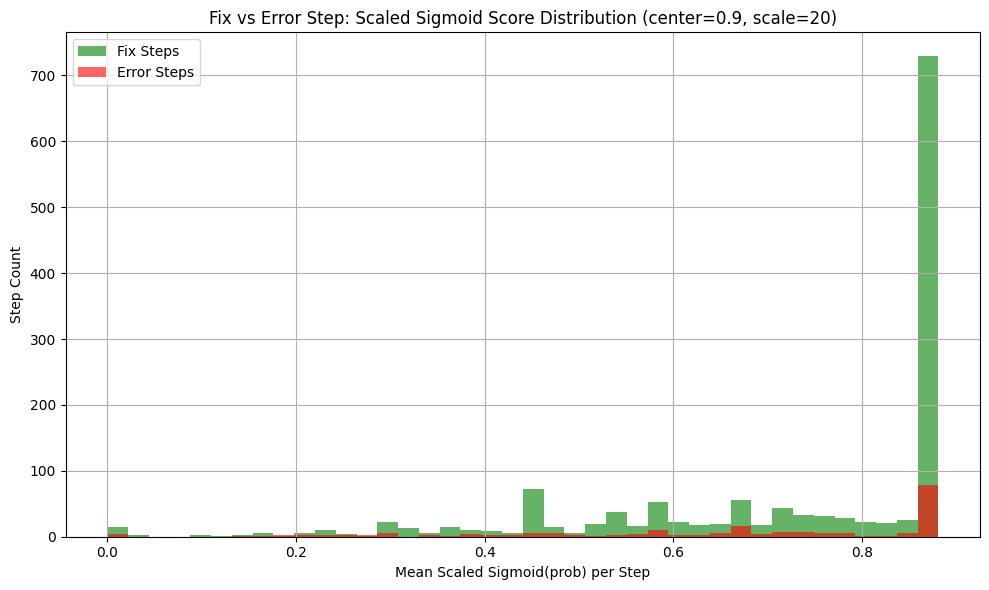

In [ ]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# === Step 1: 构建 step_data（从 logits_data 和 index_data 中提取） ===

def map_error_index_to_steps(similarities, error_start, error_end, steps):
    error_steps = set()
    for i in range(len(steps) - 1):
        s, e = steps[i], steps[i+1]
        if any(error_start <= j <= error_end for j in range(s, e)):
            error_steps.add(i)
    return error_steps

def compute_token_similarities(token_level):
    vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
    return [
        np.dot(vectors[i], vectors[i+1]) /
        (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[i+1]) + 1e-8)
        for i in range(len(vectors) - 1)
    ]

def find_steps(similarities, distance=15, prominence=0.3):
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
    return [0] + peaks.tolist() + [len(similarities)]

step_data = {}

for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid not in sample or "token_probs" not in sample[sid]:
            continue

        token_level = sample[sid]["token_probs"]
        similarities = compute_token_similarities(token_level)
        steps = find_steps(similarities)

        for i in range(len(steps) - 1):
            s_idx, e_idx = steps[i], steps[i+1]
            vecs = [token_level[j]["hidden_vector"] for j in range(s_idx, e_idx) if "hidden_vector" in token_level[j]]
            probs = [token_level[j]["chosen_prob"] for j in range(s_idx, e_idx) if "chosen_prob" in token_level[j]]
            ents = [token_level[j]["topk_info"]["entropy"] for j in range(s_idx, e_idx)
                    if "topk_info" in token_level[j] and "entropy" in token_level[j]["topk_info"]]

            if not vecs:
                continue

            step_key = f"step_{i}"
            if qid not in step_data:
                step_data[qid] = {}
            if sid not in step_data[qid]:
                step_data[qid][sid] = {}

            step_info = {
                "token_range": f"{s_idx}-{e_idx}",
                "vec_mean": np.mean(vecs, axis=0).tolist(),
                "entropy_mean": float(np.mean(ents)) if ents else 0.0,
                "probs": probs,
            }

            if qid in index_data and sid in index_data[qid]:
                err_info = index_data[qid][sid]
                err_start = err_info.get("first_error_token_index")
                err_end = err_info.get("last_error_token_index")
                if err_start is not None and err_end is not None:
                    try:
                        error_steps = map_error_index_to_steps(similarities, err_start, err_end, steps)
                        if not isinstance(error_steps, set):
                            raise ValueError("map_error_index_to_steps returned non-set")
                        step_info["is_error_step"] = i in error_steps
                    except Exception as e:
                        print(f"❌ 错误映射失败: qid={qid}, sid={sid}, err=({err_start}, {err_end}) -> {e}")
                        break

            step_data[qid][sid][step_key] = step_info

print("✅ step_data 构建完成")

# === Step 2: 计算 sigmoid 分数并统计 ===

def sigmoid_scaled(x, center=0.9, scale=20):
    return 1 / (1 + np.exp(-scale * (x - center)))

def avg_sigmoid_score_scaled(probs, center=0.9, scale=20):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)
    return np.mean(sigmoid_scaled(probs, center=center, scale=scale))

# ✅ 构建 DataFrame
rows = []

for qid, sid_dict in step_data.items():
    for sid, steps in sid_dict.items():
        any_error = any(steps[k].get("is_error_step", False) for k in steps)
        if not any_error:
            continue  # 只处理负样本

        for step_key, step_info in steps.items():
            probs = step_info.get("probs", [])
            if not probs or not isinstance(probs, list):
                continue

            avg_score = avg_sigmoid_score_scaled(probs, center=0.9, scale=20)
            step_type = "error" if step_info.get("is_error_step") else "fix"

            rows.append({
                "qid": qid,
                "sid": sid,
                "step": step_key,
                "avg_sigmoid_score_scaled": avg_score,
                "type": step_type
            })

df_steps = pd.DataFrame(rows)

# === Step 3: 绘图 ===

fix_scores = df_steps[df_steps["type"] == "fix"]["avg_sigmoid_score_scaled"].values
error_scores = df_steps[df_steps["type"] == "error"]["avg_sigmoid_score_scaled"].values

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Steps', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Steps', color='red')
plt.xlabel("Mean Scaled Sigmoid(prob) per Step")
plt.ylabel("Step Count")
plt.title("Fix vs Error Step: Scaled Sigmoid Score Distribution (center=0.9, scale=20)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
step_data.keys()

dict_keys(['q_700', 'q_701', 'q_702', 'q_703', 'q_704', 'q_705', 'q_706', 'q_707', 'q_708', 'q_709', 'q_710', 'q_711', 'q_712', 'q_713', 'q_714', 'q_715', 'q_716', 'q_717', 'q_718', 'q_719', 'q_720', 'q_721', 'q_722', 'q_723', 'q_724', 'q_725', 'q_726', 'q_727', 'q_728', 'q_729', 'q_730'])

In [ ]:
step_data['q_715'].keys()

dict_keys(['sampling0', 'sampling1', 'sampling2'])

In [ ]:
step_data['q_715']['sampling1']['step_2']['is_error_step']

True

In [ ]:
# === Step 4: 聚类准备 =======================================================

import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans         # 可替换为其它聚类器
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import matplotlib.pyplot as plt

rows = []
for qid, sid_dict in step_data.items():
    for sid, steps in sid_dict.items():
        for step_key, info in steps.items():
            # -------- 真实标签映射 ----------
            # 判定当前 step 属于哪一类
            if "is_error_step" in info and info["is_error_step"]:
                true_label = "neg_error"     # 红
            elif (qid in index_data and sid in index_data[qid]):
                true_label = "neg_correct"   # 绿
            else:
                true_label = "pos"           # 蓝

            rows.append({
                "qid"      : qid,
                "sid"      : sid,
                "step"     : step_key,
                "vec"      : info["vec_mean"],
                "entropy"  : info["entropy_mean"],
                "true_lab" : true_label
            })

df_steps_all = pd.DataFrame(rows)
print(f"✅ 总样本数: {len(df_steps_all)}")

# === Step 5: 组装特征矩阵 ===================================================

vecs          = np.vstack(df_steps_all["vec"].values)          # (N, hidden_dim)
entropy_feat  = df_steps_all["entropy"].values.reshape(-1, 1)   # (N, 1)
X_raw         = np.hstack([vecs, entropy_feat])                # (N, D+1)

# 标准化 + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)       # (N, 20) 解释度≈80%+

# === Step 6: 聚类 ===========================================================

clusterer  = KMeans(n_clusters=3, random_state=42, n_init="auto")
cluster_id = clusterer.fit_predict(X_pca)
df_steps_all["cluster"] = cluster_id

# === 评估 (如果你有真标签的话) =============================================

label_map = {"pos":0, "neg_correct":1, "neg_error":2}
y_true    = df_steps_all["true_lab"].map(label_map).values
ari       = adjusted_rand_score(y_true, cluster_id)
print(f"\nAdjusted Rand Index (vs 红绿蓝真标签) = {ari:.4f}")
print("\nConfusion Matrix (rows=true, cols=cluster):")
print(confusion_matrix(y_true, cluster_id))

# === Step 7: 2-D 可视化 (仅用于肉眼检验) ====================================

plt.figure(figsize=(9,7))
colors = ['tab:blue','tab:orange','tab:green']   # 聚类着色
for cid in np.unique(cluster_id):
    idx = cluster_id == cid
    plt.scatter(X_pca[idx,0], X_pca[idx,1],
                s=28, alpha=0.6, color=colors[cid], label=f'Cluster {cid}')

# 叠加真实标签边框：蓝/绿/红
edge_color_map = {'pos':'blue', 'neg_correct':'green', 'neg_error':'red'}
for lab, edge_c in edge_color_map.items():
    idx = df_steps_all["true_lab"] == lab
    plt.scatter(X_pca[idx,0], X_pca[idx,1],
                facecolors='none', edgecolors=edge_c, linewidths=0.8,
                s=60, label=f'{lab} (truth)')

plt.title("PCA-2 → KMeans-3 聚类可视化")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(fontsize=8, ncol=2)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# === 可选：保存图 ============================================================
out_dir = os.path.join(SAVE_PATH, "cluster_vis")
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, "pca_kmeans_clusters_2.png"))
plt.close()
print(f"📊 聚类可视化已保存至 {out_dir}/pca_kmeans_cluster_2.png")


✅ 总样本数: 3856

Adjusted Rand Index (vs 红绿蓝真标签) = -0.0034

Confusion Matrix (rows=true, cols=cluster):
[[1024  815  351]
 [ 825  405  227]
 [ 123   67   19]]


/tmp/ipython-input-17-17684000.py:84: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-17684000.py:84: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-17684000.py:84: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-17684000.py:84: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-17684000.py:84: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-17684000.py:89: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(out_dir, "pca_kmeans_clusters_2.png"))
/tmp/ipython-input-17-17684000.py:89: UserWarning

📊 聚类可视化已保存至 /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/cluster_vis/pca_kmeans_cluster_2.png


In [ ]:
# =============================================================================
# Improved Unsupervised Clustering  (vec_mean + entropy + mean_prob)
#   - PCA(30)  -> GaussianMixture(full-cov, k=4)
#   - ARI / Confusion  评估
#   - 2-D Visualization  (PC1-PC2)
# -----------------------------------------------------------------------------
# 依赖: step_data, index_data, SAVE_PATH 已存在
# =============================================================================

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, confusion_matrix

# ---------- 1. 组装样本表 -----------------------------------------------
rows = []
for qid, sid_dict in step_data.items():
    for sid, steps in sid_dict.items():
        for step_key, info in steps.items():
            # 真标签
            if info.get("is_error_step", False):
                true_lab = "neg_error"
            elif (qid in index_data and sid in index_data[qid]):
                true_lab = "neg_correct"
            else:
                true_lab = "pos"

            # mean_prob 计算：若缺失则给 0
            probs = info.get("probs", [])
            mean_p = float(np.mean(probs)) if probs else 0.0

            rows.append({
                "qid"      : qid,
                "sid"      : sid,
                "step"     : step_key,
                "vec"      : info["vec_mean"],
                "entropy"  : info["entropy_mean"],
                "mean_prob": mean_p,
                "true_lab" : true_lab,
            })

df = pd.DataFrame(rows)
print(f"✅ 样本: {len(df)} 行 | 隐向量维：{len(df.iloc[0]['vec'])}")

# ---------- 2. 组装特征矩阵 (vec + entropy + mean_prob) -----------------
vecs   = np.vstack(df["vec"].values)                       # (N, D)
entropy_feat = df["entropy"].values.reshape(-1,1)          # (N,1)
prob_feat    = df["mean_prob"].values.reshape(-1,1)        # (N,1)
X_raw  = np.hstack([vecs, entropy_feat, prob_feat])        # (N, D+2)

# ---------- 3. 标准化 + PCA(30) -----------------------------------------
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

pca      = PCA(n_components=30, random_state=42)
X_pca    = pca.fit_transform(X_scaled)
print(f"  PCA30 累积解释方差: {pca.explained_variance_ratio_.sum():.3f}")

# ---------- 4. (可选) BIC 网格搜索 k 最优 -------------------------------
# 设置 use_bic=True 可自动挑 k，否则默认 k=4
use_bic = False
if use_bic:
    bics = []
    for k in range(2, 7):
        gmm = GaussianMixture(n_components=k, covariance_type='full',
                              random_state=42, reg_covar=1e-4).fit(X_pca)
        bics.append(gmm.bic(X_pca))
    best_k = np.argmin(bics) + 2
    print(f"  👉 BIC 最佳 k = {best_k}")
else:
    best_k = 4

# ---------- 5. 高斯混合聚类 ---------------------------------------------
gmm = GaussianMixture(n_components=best_k, covariance_type='full',
                      random_state=42, reg_covar=1e-4)
cluster_id = gmm.fit_predict(X_pca)
df["cluster"] = cluster_id

# ---------- 6. 评估 ------------------------------------------------------
label_map = {"pos":0, "neg_correct":1, "neg_error":2}
y_true = df["true_lab"].map(label_map).values
ari    = adjusted_rand_score(y_true, cluster_id)
print(f"\nAdjusted Rand Index  = {ari:.4f}\n")
print("Confusion Matrix (行=true, 列=cluster):")
print(confusion_matrix(y_true, cluster_id))

# ---------- 7. 2-D 可视化 -----------------------------------------------
plt.figure(figsize=(9,7))
celuts = plt.cm.get_cmap('tab10', best_k)
for cid in range(best_k):
    idx = cluster_id == cid
    plt.scatter(X_pca[idx,0], X_pca[idx,1],
                s=20, alpha=0.65, color=celuts(cid), label=f'Cluster {cid}')

edge_map = {'pos':'blue', 'neg_correct':'green', 'neg_error':'red'}
for lab, ec in edge_map.items():
    idx = df["true_lab"] == lab
    plt.scatter(X_pca[idx,0], X_pca[idx,1],
                facecolors='none', edgecolors=ec, linewidths=0.8,
                s=60, label=f'{lab} (truth)')

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA-30 → GMM-{best_k} 聚类可视化")
plt.legend(fontsize=8, ncol=2)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

out_dir = os.path.join(SAVE_PATH, "cluster_vis_improved")
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, f"pca_gmm_k{best_k}.png"))
plt.close()
print(f"📊 可视化已保存: {out_dir}/pca_gmm_k{best_k}.png")


✅ 样本: 3856 行 | 隐向量维：4096
  PCA30 累积解释方差: 0.451

Adjusted Rand Index  = 0.0435

Confusion Matrix (行=true, 列=cluster):
[[320 689 911 270]
 [568 363 384 142]
 [ 86  61  52  10]
 [  0   0   0   0]]


/tmp/ipython-input-19-2183526987.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  celuts = plt.cm.get_cmap('tab10', best_k)
/tmp/ipython-input-19-2183526987.py:107: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-19-2183526987.py:107: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-19-2183526987.py:107: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-19-2183526987.py:107: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-19-2183526987.py:107: UserWarning: Glyph 21270 (\N{CJK UNIF

📊 可视化已保存: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/cluster_vis_improved/pca_gmm_k4.png


In [ ]:



# =============================================================================
# HDBSCAN / SpectralClustering  (vec_mean + entropy)
# -----------------------------------------------------------------------------
# 依赖: step_data, index_data, SAVE_PATH 均已存在
# =============================================================================
!pip install -q hdbscan  # 若已安装可忽略

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, confusion_matrix

# ---------- 1. 组装样本表 ----------------------------------------------------
rows = []
for qid, sid_dict in step_data.items():
    for sid, steps in sid_dict.items():
        for step_key, info in steps.items():
            # 真标签
            if info.get("is_error_step", False):
                lab = "neg_error"
            elif (qid in index_data and sid in index_data[qid]):
                lab = "neg_correct"
            else:
                lab = "pos"
            rows.append({
                "qid": qid, "sid": sid, "step": step_key,
                "vec": info["vec_mean"],
                "entropy": info["entropy_mean"],
                "true_lab": lab,
            })

df = pd.DataFrame(rows)
print(f"✅ 样本: {len(df)} 行 | 隐向量维: {len(df.iloc[0]['vec'])}")

# ---------- 2. 构造特征 (vec + entropy) --------------------------------------
vecs = np.vstack(df["vec"].values)                       # (N, D)
ent  = df["entropy"].values.reshape(-1,1)                # (N,1)
X_raw = np.hstack([vecs, ent])                           # (N, D+1)

# ---------- 3. 标准化 + PCA(30) ------------------------------------------------
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

pca      = PCA(n_components=30, random_state=42)
X_pca    = pca.fit_transform(X_scaled)
print(f"  PCA30 累积解释方差: {pca.explained_variance_ratio_.sum():.3f}")

# ---------- 4. 选择聚类器 ------------------------------------------------------
use_hdbscan = True   # ← 改成 False 可切换 SpectralClustering

if use_hdbscan:
    import hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=30,
                                min_samples=10,
                                metric='euclidean',
                                cluster_selection_epsilon=0.5)
    labels = clusterer.fit_predict(X_pca)                # -1 = 噪声
    algo_name = "HDBSCAN"
else:
    from sklearn.cluster import SpectralClustering
    clusterer = SpectralClustering(n_clusters=4,          # 可调
                                   affinity='nearest_neighbors',
                                   n_neighbors=25,
                                   assign_labels='kmeans',
                                   random_state=42)
    labels = clusterer.fit_predict(X_pca)
    algo_name = "Spectral"

df["cluster"] = labels

# ---------- 5. 评估 ARI -------------------------------------------------------
label_map = {"pos":0, "neg_correct":1, "neg_error":2}
y_true = df["true_lab"].map(label_map).values
ari    = adjusted_rand_score(y_true, labels)
print(f"\nAdjusted Rand Index  = {ari:.4f}")

# 若含噪声 (-1)，在混淆矩阵前先映射为连续正整数
unique_lbls = np.unique(labels)
lbl_map = {l:i for i,l in enumerate(unique_lbls)}
cm = confusion_matrix(y_true, [lbl_map[l] for l in labels])
print("\nConfusion Matrix (行=true, 列=cluster/噪声):")
print(cm)

# ---------- 6. 2-D 可视化 -----------------------------------------------------
plt.figure(figsize=(9,7))

# 背景散点：按聚类着色
cmap = plt.cm.get_cmap('tab10', len(unique_lbls))
for cid in unique_lbls:
    idx = labels == cid
    if cid == -1:
        # 噪声点
        plt.scatter(X_pca[idx,0], X_pca[idx,1],
                    marker='x', color='gray', alpha=0.6, label='Noise (-1)')
    else:
        plt.scatter(X_pca[idx,0], X_pca[idx,1],
                    s=22, alpha=0.6, color=cmap(lbl_map[cid]),
                    label=f'Cluster {cid}')

# 真实标签：空心描边
edge_map = {'pos':'blue', 'neg_correct':'green', 'neg_error':'red'}
for lab, ec in edge_map.items():
    idx = df["true_lab"] == lab
    plt.scatter(X_pca[idx,0], X_pca[idx,1],
                facecolors='none', edgecolors=ec, linewidths=0.8,
                s=60, label=f'{lab} (truth)')

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA-30 → {algo_name} 聚类可视化")
plt.legend(fontsize=8, ncol=2)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# ---------- 7. 保存 -----------------------------------------------------------
out_dir = os.path.join(SAVE_PATH, f"cluster_vis_{algo_name.lower()}")
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, f"pca_{algo_name.lower()}.png"))
plt.close()
print(f"📊 可视化已保存: {out_dir}/pca_{algo_name.lower()}.png")


✅ 样本: 3856 行 | 隐向量维: 4096
  PCA30 累积解释方差: 0.451


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Adjusted Rand Index  = -0.0124

Confusion Matrix (行=true, 列=cluster/噪声):
[[ 772   60 1302   56]
 [ 336   29 1063   29]
 [  49    1  158    1]
 [   0    0    0    0]]


/tmp/ipython-input-20-728047799.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_lbls))
/tmp/ipython-input-20-728047799.py:112: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-20-728047799.py:112: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-20-728047799.py:112: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-20-728047799.py:112: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-20-728047799.py:112: UserWarning: Glyph 21270 (\N{CJK UN

📊 可视化已保存: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/cluster_vis_hdbscan/pca_hdbscan.png


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.1 MB/s eta 0:00:00
✅ 样本 3856
  PCA100 方差占比 0.652


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



=== XGBoost on Test ===
              precision    recall  f1-score   support

           0      0.813     0.895     0.852       219
           1      0.731     0.726     0.729       146
           2      0.000     0.000     0.000        21

    accuracy                          0.782       386
   macro avg      0.515     0.540     0.527       386
weighted avg      0.738     0.782     0.759       386



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  % (pos_label, average),
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  % (pos_label, average),
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  % (pos_label, average),


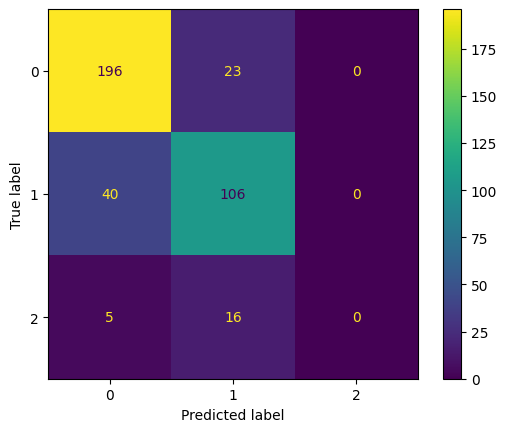

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  # that has no feature names.



=== MLP on Test ===
              precision    recall  f1-score   support

           0      0.888     0.868     0.878       219
           1      0.739     0.815     0.775       146
           2      0.455     0.238     0.312        21

    accuracy                          0.813       386
   macro avg      0.694     0.640     0.655       386
weighted avg      0.808     0.813     0.808       386



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  # that has no feature names.


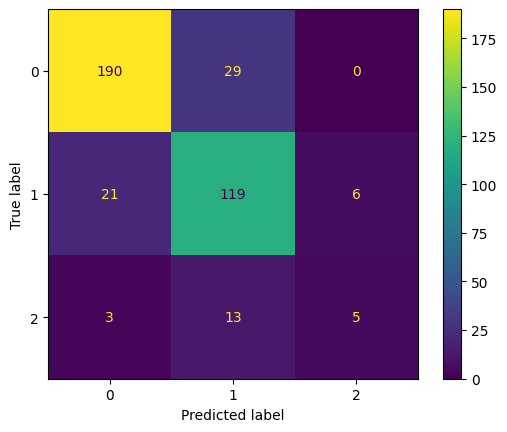

💾 模型已保存至 /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/supervised_models/step_classifier.joblib


In [ ]:
# ================================================================
# Supervised Classification  (XGBoost & optional MLP)
# ================================================================
!pip install --quiet xgboost==2.0.3 scikit-learn==1.4.2

import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# ---------- 1. 组装样本 ------------------------------------------
rows = []
for qid, sid_dict in step_data.items():
    for sid, steps in sid_dict.items():
        for step_key, info in steps.items():
            if info.get("is_error_step", False):
                lab = "neg_error"
            elif (qid in index_data and sid in index_data[qid]):
                lab = "neg_correct"
            else:
                lab = "pos"
            mean_p = float(np.mean(info.get("probs", []))) if info.get("probs") else 0.0
            rows.append({
                "vec": info["vec_mean"],
                "entropy": info["entropy_mean"],
                "mean_prob": mean_p,
                "label": lab,
            })

df = pd.DataFrame(rows)
print("✅ 样本", len(df))

# ---------- 2. 构造特征矩阵 + 标签 -------------------------------
vecs   = np.vstack(df["vec"].values)
ent    = df["entropy"].values.reshape(-1,1)
prob   = df["mean_prob"].values.reshape(-1,1)
X_raw  = np.hstack([vecs, ent, prob])
y      = df["label"].map({'pos':0, 'neg_correct':1, 'neg_error':2}).values

# ---------- 3. train / val / test split -------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
        X_raw, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ---------- 4. 预处理 (手动 scaler + PCA) ------------------------
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

pca = PCA(n_components=100, random_state=42).fit(X_train_s)
X_train_p = pca.transform(X_train_s)
X_val_p   = pca.transform(X_val_s)
X_test_p  = pca.transform(X_test_s)

print("  PCA100 方差占比", pca.explained_variance_ratio_.sum().round(3))

# ---------- 5. 训练 XGBoost --------------------------------------
clf = xgb.XGBClassifier(
        n_estimators=600, learning_rate=0.05,
        max_depth=8, subsample=0.9, colsample_bytree=0.8,
        objective='multi:softprob', eval_metric='mlogloss',
        num_class=3, random_state=42)
clf.fit(X_train_p, y_train,
        eval_set=[(X_val_p, y_val)],
        verbose=False, early_stopping_rounds=40)

print("\n=== XGBoost on Test ===")
y_pred = clf.predict(X_test_p)
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# ---------- 6. (可选) 训练 MLP ------------------------------------
mlp = MLPClassifier(hidden_layer_sizes=(512,128),
                    activation='relu', max_iter=200,
                    random_state=42, verbose=False)
mlp.fit(X_train_p, y_train)

print("\n=== MLP on Test ===")
y_pred2 = mlp.predict(X_test_p)
print(classification_report(y_test, y_pred2, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred2)
plt.show()

# ---------- 7. 保存模型 + 预处理器 -------------------------------
model_dir = os.path.join(SAVE_PATH, "supervised_models")
os.makedirs(model_dir, exist_ok=True)
joblib.dump({'scaler':scaler, 'pca':pca, 'xgb':clf, 'mlp':mlp},
            os.path.join(model_dir, "step_classifier.joblib"))
print(f"💾 模型已保存至 {model_dir}/step_classifier.joblib")


In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# ---------- 0. 构建 DataFrame (vec_mean + entropy) --------------------------
rows = []
for qid, sid_dict in step_data.items():
    for sid, steps in sid_dict.items():
        for step_key, info in steps.items():
            label = ("neg_error"  if info.get("is_error_step", False) else
                     "neg_correct" if (qid in index_data and sid in index_data[qid])
                     else "pos")
            rows.append({
                "qid": qid, "sid": sid, "step": step_key,
                "vec": info["vec_mean"],
                "entropy": info["entropy_mean"],
                "truth": label
            })

df = pd.DataFrame(rows)
print(f"✅ 样本数: {len(df)} | 隐向量维度: {len(df.iloc[0]['vec'])}")

# ---------- 1. 特征 → 标准化 → PCA(2) ---------------------------------------
vecs  = np.vstack(df["vec"].values)
ent   = df["entropy"].values.reshape(-1, 1)
X_raw = np.hstack([vecs, ent])

scaler = StandardScaler().fit(X_raw)
X_scaled = scaler.transform(X_raw)

pca2 = PCA(n_components=2, random_state=42).fit(X_scaled)
X_pca = pca2.transform(X_scaled)
print("  PCA-2 累积解释方差:", pca2.explained_variance_ratio_.sum().round(3))

# ---------- 2. 训练 / 复用 2-D GMM-4 ----------------------------------------
# 若工作区已有 gmm 且是 2-D，可直接用；否则重训
use_existing = "gmm" in globals() and getattr(gmm, "n_features_in_", None) == 2
if use_existing:
    gmm2d = gmm
    print("✅ 复用已有 2-D GMM")
else:
    gmm2d = GaussianMixture(
        n_components=4, covariance_type='full',
        random_state=42, reg_covar=1e-4
    ).fit(X_pca)
    print("🔄 重新训练 2-D GMM-4")

labels = gmm2d.predict(X_pca)
df["cluster"] = labels
n_comp = gmm2d.n_components
cmap   = plt.cm.get_cmap('tab10', n_comp)

# ---------- 3. Matplotlib: 决策面 + 椭圆 + 真实标签 --------------------------
fig, ax = plt.subplots(figsize=(9, 7))

# 3-A 决策面 (背景上色 alpha=0.2)
xx, yy = np.meshgrid(
    np.linspace(X_pca[:, 0].min() - 2, X_pca[:, 0].max() + 2, 400),
    np.linspace(X_pca[:, 1].min() - 2, X_pca[:, 1].max() + 2, 400)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = gmm2d.predict(grid).reshape(xx.shape)
ax.pcolormesh(xx, yy, zz, cmap='Pastel2', alpha=0.20, shading='auto')

# 3-B 散点（填充色=簇）
for cid in range(n_comp):
    idx = labels == cid
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1],
               s=18, alpha=0.7, color=cmap(cid), label=f'Cluster {cid}')

# 3-C 真实标签（空心描边）
edge_map = {'pos': 'blue', 'neg_correct': 'green', 'neg_error': 'red'}
for lab, ec in edge_map.items():
    idx = df["truth"] == lab
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1],
               facecolors='none', edgecolors=ec, linewidths=0.8,
               s=60, label=f'{lab} (truth)')

# 3-D 1-σ 椭圆轮廓
for k in range(n_comp):
    mean = gmm2d.means_[k]
    cov  = gmm2d.covariances_[k]
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    w, h  = 2 * np.sqrt(vals)                     # 1-sigma
    ell = Ellipse(mean, width=w, height=h, angle=angle,
                  edgecolor=cmap(k), facecolor='none',
                  linestyle='--', linewidth=2)
    ax.add_patch(ell)

ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title("GMM (4) · 1-σ Ellipse + Decision Surface")
ax.legend(fontsize=8, ncol=2)
ax.grid(alpha=0.3, linestyle='--')
fig.tight_layout()

# ---------- 4. 保存静态图 ----------------------------------------------------
vis_dir = os.path.join(SAVE_PATH, "gmm_vis_advanced")
os.makedirs(vis_dir, exist_ok=True)
static_path = os.path.join(vis_dir, "gmm_ellipse_decision.png")
fig.savefig(static_path)
plt.close(fig)
print("📊 Matplotlib 图保存:", static_path)

# ---------- 5. Plotly 交互 ---------------------------------------------------
import plotly.graph_objects as go
plot_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": labels.astype(str),
    "truth": df["truth"],
    "qid": df["qid"],
    "sid": df["sid"],
    "step": df["step"]
})

fig_p = px.scatter(
    plot_df, x="PC1", y="PC2",
    color="cluster", symbol="truth",
    opacity=0.75,
    hover_data=["qid", "sid", "step", "truth", "cluster"],
    title="Interactive 2-D PCA · GMM Clusters"
)
fig_p.update_layout(width=900, height=700, legend=dict(itemsizing='constant'))

html_path = os.path.join(vis_dir, "gmm_interactive.html")
fig_p.write_html(html_path)
print("🌐 Plotly 交互 HTML 保存:", html_path)

# 内联显示（Notebook 中可缩放）
fig_p.show()

✅ 样本数: 3856 | 隐向量维度: 4096
  PCA-2 累积解释方差: 0.118
🔄 重新训练 2-D GMM-4


/tmp/ipython-input-24-267619192.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = plt.cm.get_cmap('tab10', n_comp)
/tmp/ipython-input-24-267619192.py:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


📊 Matplotlib 图保存: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/gmm_vis_advanced/gmm_ellipse_decision.png
🌐 Plotly 交互 HTML 保存: /content/drive/MyDrive/Cluster-proj/output/step_wise_pca/gmm_vis_advanced/gmm_interactive.html
